In [152]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from collections import defaultdict
import seaborn as sns
from scipy.stats import f_oneway, norm, shapiro, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests


df = pd.read_excel('c:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Raman_Bunmi\\Master_Data\\Data_Master_Sheet1.xlsx', sheet_name = "Master")

In [25]:
df.iloc[:, 5:].drop('details1', axis=1)#.set_index('details')


details   752.901   754.044   755.187   756.329   757.471  \
0    0616-Ctrl-20mins-Orth -0.004580  0.014198  0.033234  0.052258  0.070999   
1    0616-Ctrl-20mins-Orth -0.002485  0.054030  0.099156  0.134131  0.160196   
2    0616-Ctrl-20mins-Orth -0.006735  0.049518  0.097465  0.137848  0.171408   
3    0616-Ctrl-20mins-Orth  0.016831  0.032360  0.041923  0.046839  0.048433   
4    0616-Ctrl-20mins-Orth -0.002913  0.041236  0.079787  0.113092  0.141507   
..                     ...       ...       ...       ...       ...       ...   
873   0609-Trt-60mins-Para  0.025701  0.019553  0.014295  0.009905  0.006361   
874   0609-Trt-60mins-Para -0.007358  0.022695  0.046221  0.064111  0.077253   
875   0609-Trt-60mins-Para  0.133186  0.152916  0.159233  0.154450  0.140882   
876   0609-Trt-60mins-Para  0.030676  0.015587  0.007095  0.004418  0.006771   
877   0609-Trt-60mins-Para -0.009088  0.086792  0.169038  0.238403  0.295637   

      758.613   759.754   760.896   762.036  ...   1727.14   1728.02  \
0    0.089188  0.106554  0.122828  0.138315  ...  0.063764  0.060871   
1    0.178590  0.190554  0.197327  0.201143  ...  0.089793  0.091843   
2    0.198886  0.221023  0.238559  0.253089  ...  0.305150  0.310110   
3    0.048025  0.046937  0.046491  0.049473  ...  0.140087  0.142750   
4    0.165383  0.185075  0.200937  0.213499  ...  0.222366  0.224526   
..        ...       ...       ...       ...  ...       ...       ...   
873  0.003638  0.001716  0.000570  0.000098  ...  0.153886  0.153877   
874  0.086536  0.092848  0.097079  0.100884  ...  0.316235  0.309218   
875  0.120840  0.096640  0.070594  0.047294  ...  0.181936  0.182247   
876  0.013371  0.023435  0.036179  0.049503  ...  0.191811  0.196527   
877  0.341494  0.376723  0.402078  0.418830  ...  0.339262  0.332494   

       1728.9   1729.78   1730.66   1731.54   1732.42   1733.29   1734.17  \
0    0.058869  0.058241  0.058690  0.060554  0.064038  0.069348  0.076688   
1    0.094528  0.097768  0.101272  0.104856  0.108352  0.111590  0.114402   
2    0.314895  0.319764  0.324469  0.329269  0.334224  0.339393  0.344836   
3    0.144948  0.146399  0.147567  0.148977  0.150814  0.153261  0.156503   
4    0.226351  0.227929  0.229314  0.230770  0.232435  0.234444  0.236937   
..        ...       ...       ...       ...       ...       ...       ...   
873  0.152938  0.150287  0.146837  0.142780  0.138306  0.133605  0.128870   
874  0.304731  0.303583  0.304322  0.306906  0.311292  0.317438  0.325301   
875  0.186264  0.191120  0.198225  0.207921  0.220552  0.236461  0.255989   
876  0.201630  0.207425  0.213069  0.218280  0.222780  0.226290  0.228528   
877  0.323920  0.313144  0.302666  0.293407  0.286284  0.282217  0.282123   

      1735.05  
0    0.086265  
1    0.116619  
2    0.350614  
3    0.160724  
4    0.240051  
..        ...  
873  0.124290  
874  0.334838  
875  0.279480  
876  0.229216  
877  0.286923  

[878 rows x 977 columns]

In [59]:
# --- Peak models ---
def gaussian(x, amp, cen, wid):
    return amp * np.exp(-(x - cen) ** 2 / (2 * wid ** 2))

def lorentzian(x, amp, cen, wid):
    return amp * (wid**2 / ((x - cen)**2 + wid**2))

# --- Peak fitting function ---
def fit_peak(x, y, peak_pos, window=5, model="gaussian", max_width=20): #mp.inf
    # Subset spectrum around the suggested peak
    mask = (x >= peak_pos - window) & (x <= peak_pos + window)
    x_region, y_region = x[mask], y[mask]

    if len(x_region) < 5:  # too few points to fit
        return None

    # Initial guess
    amp_guess = np.max(y_region)
    cen_guess = x_region[np.argmax(y_region)]
    wid_guess = (x_region[-1] - x_region[0]) / 4

    if model == "gaussian":
        func = gaussian
    else:
        func = lorentzian

    try:
        popt, _ = curve_fit(func, x_region, y_region, p0=[amp_guess, cen_guess, wid_guess],
                            bounds = (
                                [0, peak_pos - window, 0],             # lower bounds
                                    [np.inf, peak_pos + window, max_width] # upper bounds (width limited)
                            ))
        amp, cen, wid = popt

        # Area and FWHM formulas
        if model == "gaussian":
            fwhm = 2.3548 * wid
            area = amp * wid * np.sqrt(2 * np.pi)
        else:  # Lorentzian
            fwhm = 2 * wid
            area = np.pi * amp * wid

        return {"peak_pos": peak_pos, "fit_pos": cen, "amp": amp, "fwhm": fwhm, "area": area}

    except RuntimeError:
        return None

# --- Main function ---
def analyze_spectra(df, peak_positions, model="gaussian"):
    results = []
    x = df.iloc[:, 7:].columns.astype(float).values

    # Average spectra by group
   # grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details").mean(numeric_only=True)
    dff = df.iloc[:, 5:].drop('details1', axis=1).set_index('details')

    for peak in peak_positions:
        for group, spectrum in dff.iterrows():
        #grouped.iterrows():
            y = spectrum.values
            fit = fit_peak(x, y, peak, model=model)
            if fit:
                fit["group"] = group
                results.append(fit)

                # Plot
                '''plt.figure(figsize=(6, 4))
                plt.plot(x, y, label=f"{group} spectrum")
                plt.axvline(peak, color="gray", linestyle="--", lw=0.5, label="suggested peak")

                # Overlay fitted peak
                if model == "gaussian":
                    fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                else:
                    fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)
                plt.plot(x, fit_curve, "r--", label=f"Fitted {model}")

                plt.title(f"Peak fit near {peak} cm⁻¹ ({group})")
                plt.xlabel("Raman Shift (cm⁻¹)")
                plt.ylabel("Intensity (a.u.)")
                plt.legend()
                plt.show()'''

    return pd.DataFrame(results)



In [8]:
def plot_spectra(df, peak_positions, model="gaussian"):
    x = df.iloc[:, 7:].columns.astype(float).values
    grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details1").mean(numeric_only=True)
    for group, spectrum in grouped.iterrows():
                y = spectrum.values
                fits_for_group = []

                plt.figure(figsize=(10, 5))
                plt.plot(x, y, label=f"{group} spectrum", color="black")

                for peak in peak_positions:
                    fit = fit_peak(x, y, peak, model=model, max_width = 30)
                    if fit:
                        fit["group"] = group
                        fits_for_group.append(fit)
                        #results.append(fit)
        # overlay fitted curve
                        if model == "gaussian":
                            fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                        else:  # lorentzian
                            fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)

                        plt.plot(x, fit_curve, "--", label=f"Fit @ {fit['fit_pos']:.1f} cm⁻¹")

                        # vertical line at target peak
                        plt.axvline(peak, color="gray", linestyle=":", lw=0.8)

                plt.title(f"Peak fits for {group}")
                plt.xlabel("Raman Shift (cm⁻¹)")
                plt.ylabel("Intensity (a.u.)")
                plt.xticks(np.arange(750, 1800, 100))
                plt.legend(fontsize=8, bbox_to_anchor = (1,1))
                plt.tight_layout()
                plt.show()


In [49]:
def plot_spectra(df, peak_positions, model="gaussian"):
    x = df.iloc[:, 7:].columns.astype(float).values
    grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details1").mean(numeric_only=True)

    for group, spectrum in grouped.iterrows():
        y = spectrum.values
        fits_for_group = []
        peak_curves = []   # NEW: store each fitted peak curve

        plt.figure(figsize=(10, 5))
        plt.plot(x, y, label=f"{group} spectrum", color="black")

        for peak in peak_positions:
            fit = fit_peak(x, y, peak, model=model, max_width=20)
            if fit:
                fit["group"] = group
                fits_for_group.append(fit)

                # overlay fitted curve
                if model == "gaussian":
                    fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                else:  # lorentzian
                    fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)

                peak_curves.append(fit_curve)   # NEW: collect each peak fit
                plt.plot(x, fit_curve, "--", label=f"Fit @ {fit['fit_pos']:.1f} cm⁻¹")

                # vertical line at target peak
                plt.axvline(peak, color="gray", linestyle=":", lw=0.8)

        # --- NEW: compute and plot sum of fitted peaks ---
        if peak_curves:
            y_sum = np.sum(peak_curves, axis=0)
            plt.plot(x, y_sum, "r", linewidth=2, label="Sum of fitted peaks")

        plt.title(f"Peak fits for {group}")
        plt.xlabel("Raman Shift (cm⁻¹)")
        plt.ylabel("Intensity (a.u.)")
        plt.xticks(np.arange(750, 1800, 100))
        plt.legend(fontsize=8, bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()


In [52]:
def plot_spectra(df, peak_positions, model="gaussian"):
    x = df.iloc[:, 7:].columns.astype(float).values
    grouped = df.drop(['exp', 'spectra_num'], axis=1).groupby("details").mean(numeric_only=True)

    for group, spectrum in grouped.iterrows():
        y = spectrum.values
        fits_for_group = []
        peak_curves = []

        plt.figure(figsize=(10, 5))
        plt.plot(x, y, label=f"{group} spectrum", color="black")

        # --- Step 1: local peak fits (same as before) ---
        for peak in peak_positions:
            fit = fit_peak(x, y, peak, model=model, max_width=30)
            if fit:
                fit["group"] = group
                fits_for_group.append(fit)

                # overlay fitted curve
                if model == "gaussian":
                    fit_curve = gaussian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2.3548)
                else:  # lorentzian
                    fit_curve = lorentzian(x, fit["amp"], fit["fit_pos"], fit["fwhm"]/2)

                peak_curves.append(fit_curve)
                plt.plot(x, fit_curve, "--", label=f"Fit @ {fit['fit_pos']:.1f} cm⁻¹")
                plt.axvline(peak, color="gray", linestyle=":", lw=0.8)

        # --- Step 2: global composite fit (NEW) ---
        if fits_for_group:
            from scipy.optimize import curve_fit

            def sum_of_gauss_lin(x, *params):
                n = len(fits_for_group)
                y_fit = np.zeros_like(x)
                for i in range(n):
                    a, c, w = params[3*i:3*i+3]
                    y_fit += gaussian(x, a, c, w)
                # add linear baseline
                b0, b1 = params[-2], params[-1]
                return y_fit + (b0 + b1*x)

            # initial guesses from local fits
            p0, lb, ub = [], [], []
            for fit in fits_for_group:
                a0 = fit["amp"]
                c0 = fit["fit_pos"]
                w0 = fit["fwhm"]/2.3548 if model == "gaussian" else fit["fwhm"]/2
                p0 += [a0, c0, w0]
                lb += [0, c0-5, 0.2]       # tighter bounds
                ub += [np.inf, c0+5, 100]

            # baseline params
            p0 += [0, 0]
            lb += [-np.inf, -np.inf]
            ub += [np.inf, np.inf]

            try:
                popt, _ = curve_fit(sum_of_gauss_lin, x, y, p0=p0, bounds=(lb, ub), maxfev=20000)
                y_sum_refined = sum_of_gauss_lin(x, *popt)
                plt.plot(x, y_sum_refined, "r-", linewidth=2, label="Global composite fit")

                # optional residuals metric
                residuals = y - y_sum_refined
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                print(f"{group} R² of global fit: {1 - ss_res/ss_tot:.4f}")

            except RuntimeError:
                print(f"Global fit failed for {group}")

        plt.title(f"Peak fits for {group}")
        plt.xlabel("Raman Shift (cm⁻¹)")
        plt.ylabel("Intensity (a.u.)")
        plt.xticks(np.arange(750, 1800, 100))
        plt.legend(fontsize=8, bbox_to_anchor=(1, 1))
        plt.tight_layout()
        plt.show()


0429-Ctrl-20mins-Orth R² of global fit: 0.9938


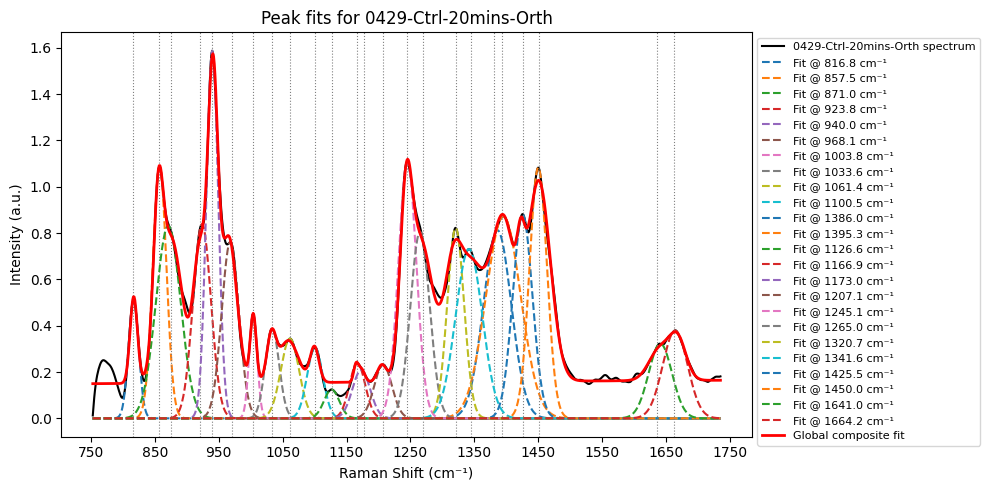

0429-Ctrl-20mins-Para R² of global fit: 0.9954


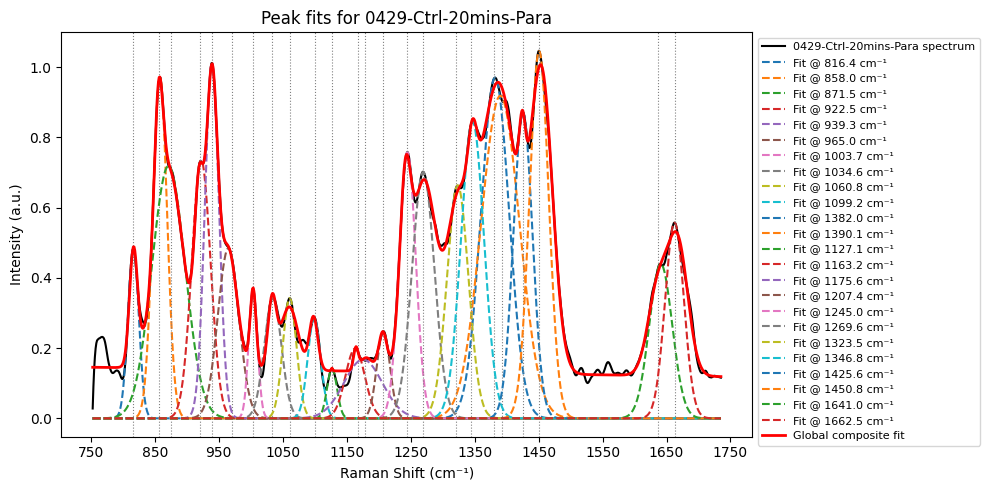

KeyboardInterrupt: 

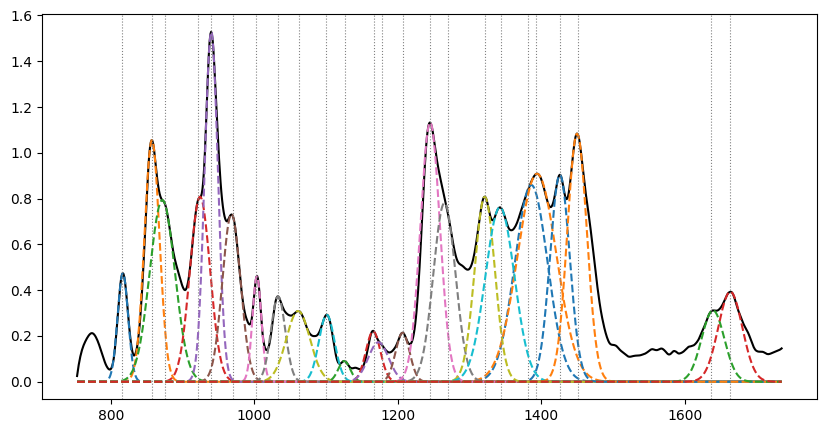

In [60]:
peak_positions = [816, 857, 876, 921, 940, 970, 1003, 1033, 1062, 1100, 1381, 1393, 
                  1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1426, 1451, 1636, 1663]
results = plot_spectra(df, peak_positions)

In [68]:
# --- Example usage ---
#df = pd.read_csv("raman_spectra.csv")  # must include a 'details' column peak_positions = [1000, 1200, 1450, 1650]
peak_positions = [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]
results = analyze_spectra(df, peak_positions, model="gaussian")
#print(results)

In [70]:
dt = results['group'].str.split('-', expand=True).rename({0: 'date', 1:'sample', 2: 'trt_time', 3: 'orient'}, axis=1)
result_df = pd.concat([dt, results], axis=1)

In [71]:
result_df

date sample trt_time orient  peak_pos      fit_pos       amp  \
0      0616   Ctrl   20mins   Orth      1033  1033.274762  0.365779   
1      0616   Ctrl   20mins   Orth      1033  1034.532967  0.330249   
2      0616   Ctrl   20mins   Orth      1033  1032.204981  0.477864   
3      0616   Ctrl   20mins   Orth      1033  1034.194092  0.300392   
4      0616   Ctrl   20mins   Orth      1033  1032.838506  0.395860   
...     ...    ...      ...    ...       ...          ...       ...   
14043  0609    Trt   60mins   Para      1663  1668.000000  0.605345   
14044  0609    Trt   60mins   Para      1663  1665.515359  0.861578   
14045  0609    Trt   60mins   Para      1663  1664.357403  0.823978   
14046  0609    Trt   60mins   Para      1663  1667.161039  0.626750   
14047  0609    Trt   60mins   Para      1663  1662.366005  0.748873   

            fwhm       area                  group  
0      17.228328   6.708077  0616-Ctrl-20mins-Orth  
1      19.669968   6.914829  0616-Ctrl-20mins-Orth  
2      26.295195  13.375714  0616-Ctrl-20mins-Orth  
3      27.163247   8.685727  0616-Ctrl-20mins-Orth  
4      27.219577  11.469872  0616-Ctrl-20mins-Orth  
...          ...        ...                    ...  
14043  39.143661  25.223206   0609-Trt-60mins-Para  
14044  47.095998  43.193097   0609-Trt-60mins-Para  
14045  32.121751  28.174131   0609-Trt-60mins-Para  
14046  46.415528  30.966587   0609-Trt-60mins-Para  
14047  44.712977  35.643264   0609-Trt-60mins-Para  

[14048 rows x 10 columns]

In [72]:
res_mean = result_df.groupby(['date', 'sample', 'trt_time', 'orient', 'peak_pos']).mean(numeric_only=True).reset_index()
#res_mean['peak_pos'] = result_df['peak_pos']
res_mean

date   sample   trt_time orient  peak_pos      fit_pos       amp  \
0     0429     Ctrl     20mins   Orth      1033  1033.876493  0.389056   
1     0429     Ctrl     20mins   Orth      1062  1060.794913  0.346572   
2     0429     Ctrl     20mins   Orth      1100  1100.422982  0.306241   
3     0429     Ctrl     20mins   Orth      1127  1124.317971  0.130653   
4     0429     Ctrl     20mins   Orth      1167  1166.571542  0.242150   
...    ...      ...        ...    ...       ...          ...       ...   
2235  0616  Trt_24h  60mins24h   Para      1381  1381.359742  1.116398   
2236  0616  Trt_24h  60mins24h   Para      1426  1425.158215  0.906883   
2237  0616  Trt_24h  60mins24h   Para      1451  1450.453305  1.048222   
2238  0616  Trt_24h  60mins24h   Para      1636  1637.065582  0.423907   
2239  0616  Trt_24h  60mins24h   Para      1663  1663.298041  0.557753   

           fwhm       area  
0     26.939075  11.272624  
1     35.246286  12.783190  
2     30.147400   9.877698  
3     30.577963   4.239314  
4     31.640687   8.298279  
...         ...        ...  
2235  47.096000  55.967902  
2236  42.461201  40.698787  
2237  37.278790  41.550049  
2238  37.615236  16.728198  
2239  42.267637  25.002690  

[2240 rows x 9 columns]

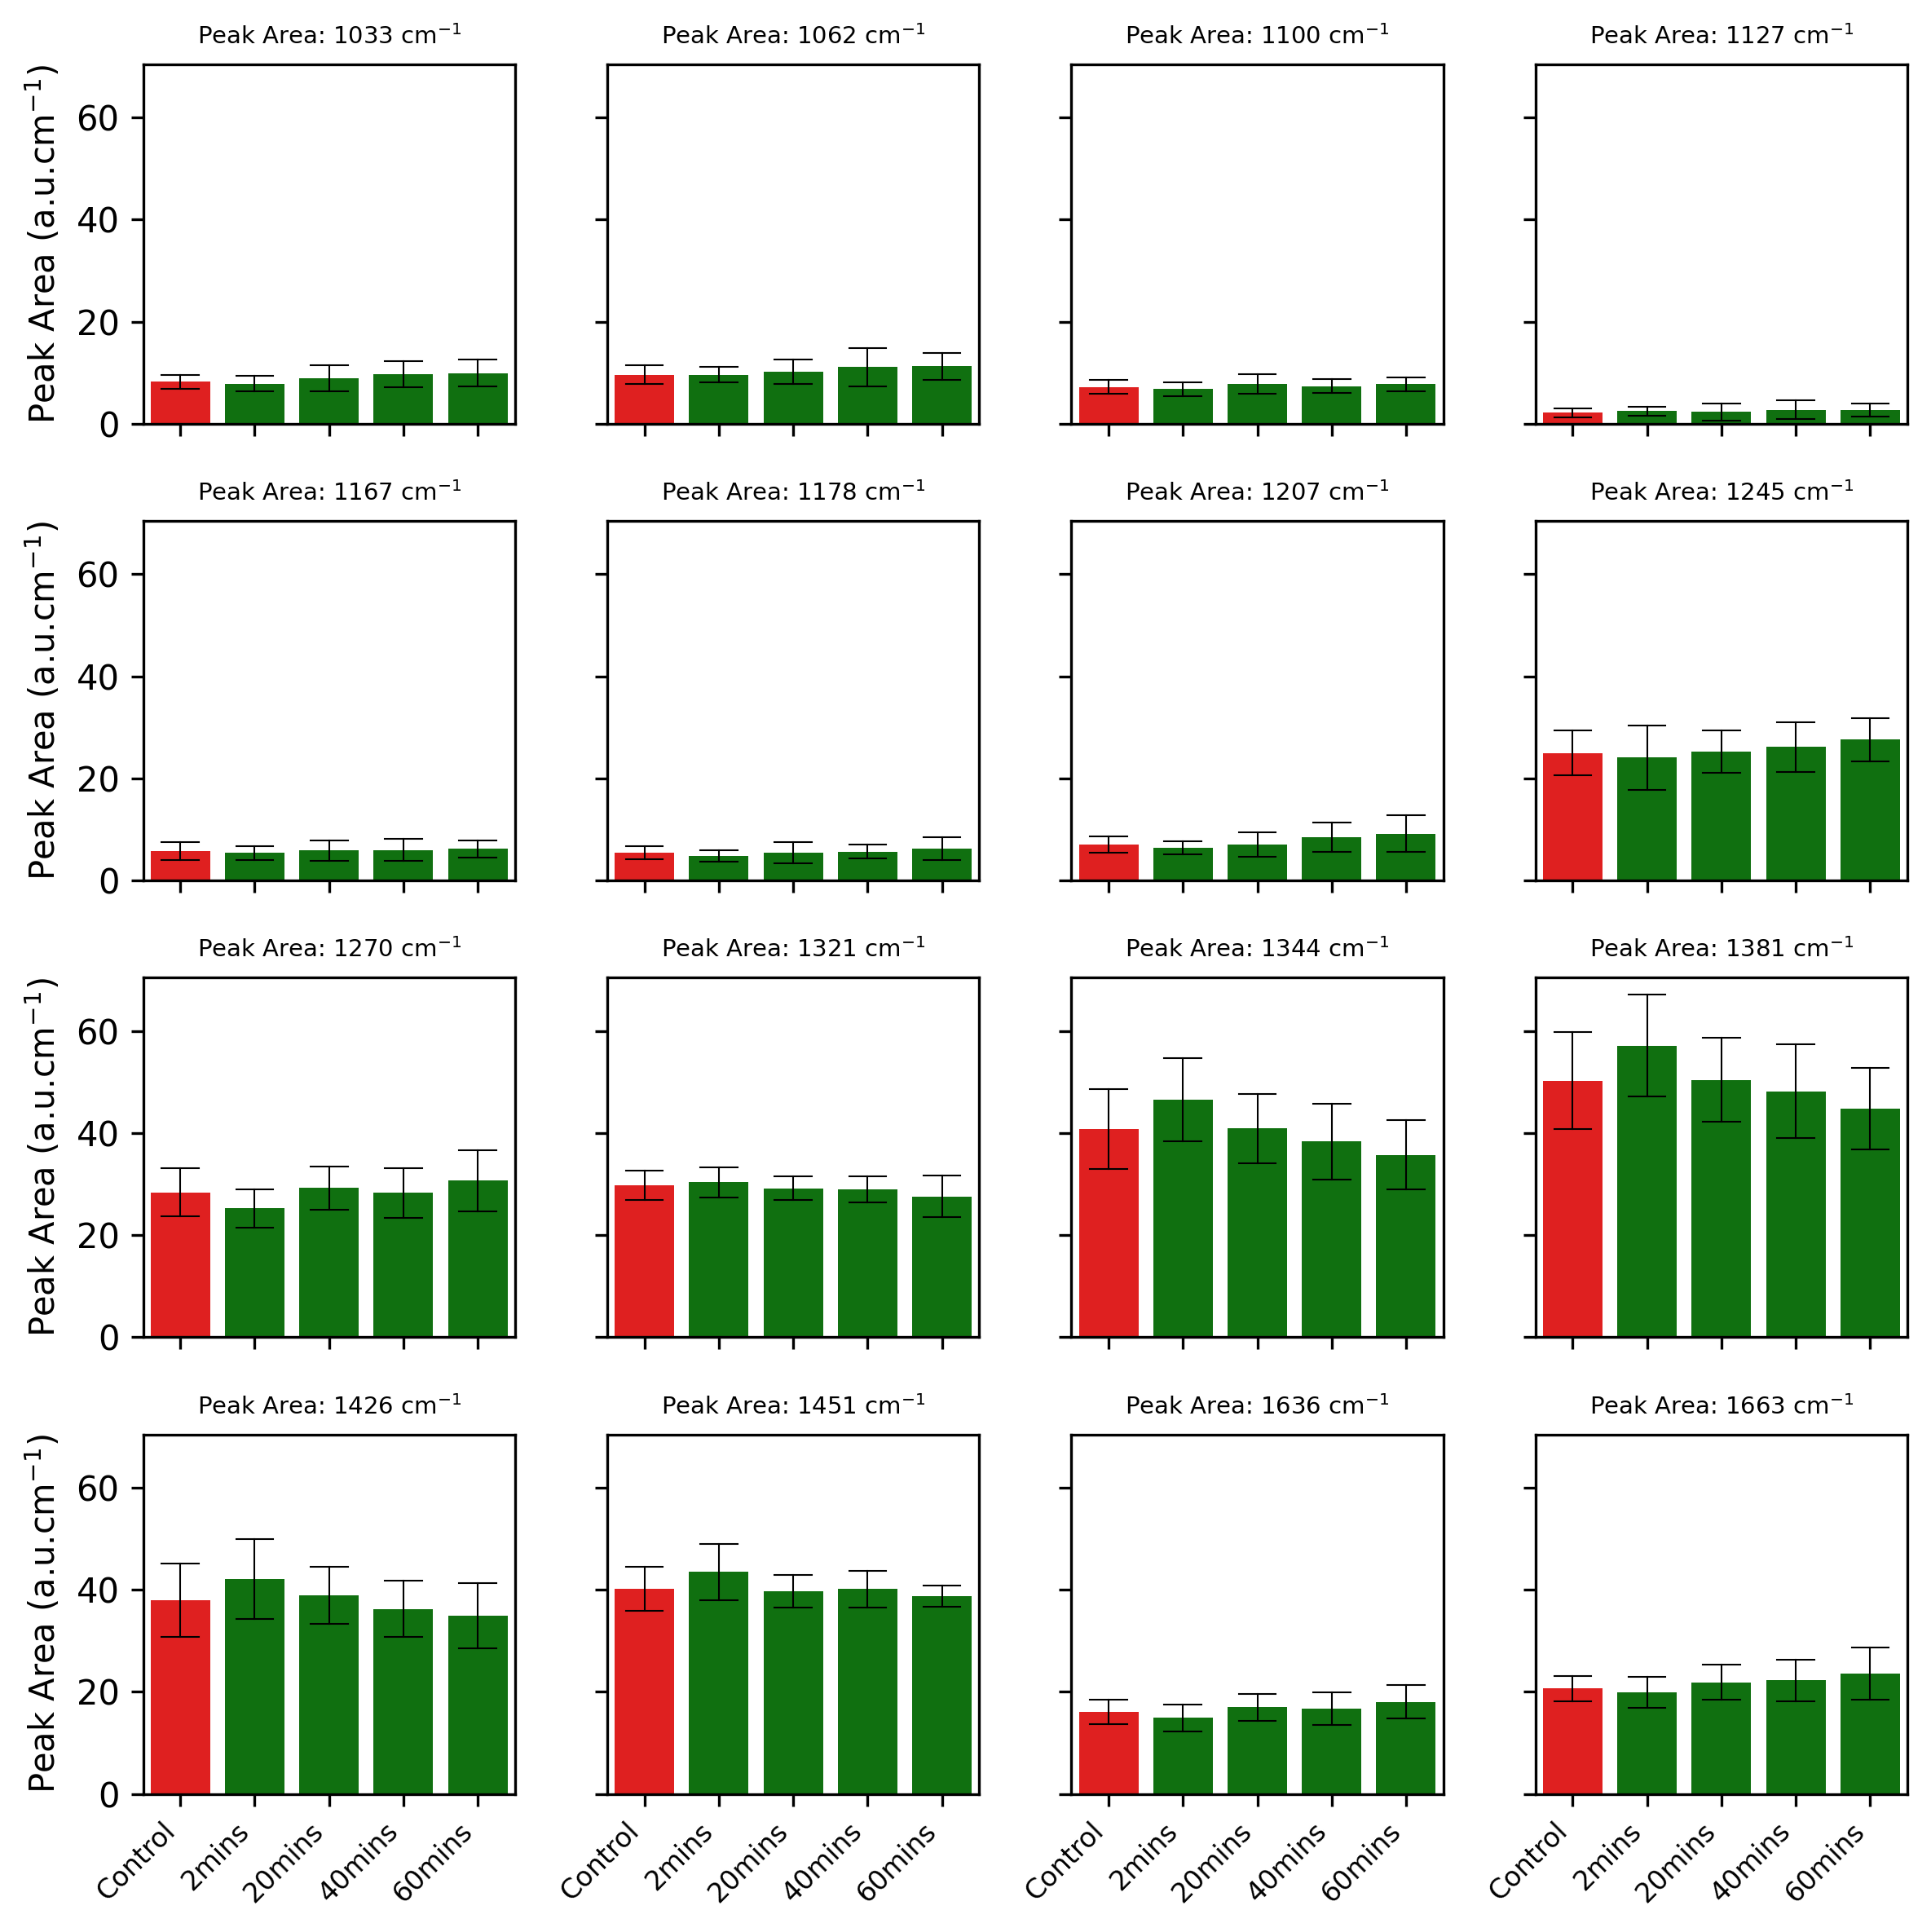

In [162]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (8, 8), dpi = 300, sharex = True, sharey = True)
ax_flat = axes.flatten()
pks = [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]
#plt.figure(figsize = (8, 2), dpi = 300);#(res_mean['trt_time'].isin(['2mins', '20mins','40mins', '60mins'])) & (res_mean['peak_pos'].isin([1636]))
for i, ax in enumerate(ax_flat):
    sns.barplot(
        data = res_mean[(res_mean['orient'] == 'Para') & (res_mean['sample'] == 'Ctrl') & (res_mean['peak_pos'] == pks[i])],
        x = 'sample',
        y = 'area',
        #hue = 'trt_time',
        #order = ['2mins', '20mins','40mins', '60mins'],
        estimator = 'mean',
        errorbar='sd',
        #legend = False,
        color = 'red',
        capsize = .5,
        # edgecolor = 'black',
        err_kws={'linewidth': .5, 'color': 'black'},
        #markersize = 3,
        #linewidth =1
        ax = ax
    )
    sns.barplot(
        data = res_mean[(res_mean['orient'] == 'Para') & (res_mean['peak_pos'] == pks[i])  & (res_mean['sample'] != 'Trt_24h')],
        x = 'trt_time',
        y = 'area',
        #hue = 'trt_time',
        order = ['2mins', '20mins','40mins', '60mins'],
        estimator = 'mean',
        errorbar='sd',
        #legend = False,
        color = 'green',
        #palette="hls",
        capsize = .5,
        #edgecolor = 'black',
        err_kws={'linewidth': .5, 'color': 'black'},
        #markersize = 3,
        #linewidth =1'''
        #dodge = 1,
        #size = 5,
        #edgecolor='black',
        #linewidth = .5,'''
        ax = ax
    )
    ax.set_xticks([0, 1, 2, 3, 4]) 
    ax.set_xticklabels(['Control', '2mins', '20mins','40mins', '60mins'], rotation=45, ha = 'right', fontsize = 8);
    #ax.set_yticklabels(rotation=45, ha = 'right', fontsize = 6);
    ax.set_ylabel('Peak Area (a.u.cm$^{-1}$)')
    ax.set_xlabel('')
    ax.set_title(f'Peak Area: {pks[i]} cm$^{{-1}}$', fontsize = 7)

plt.tight_layout()
plt.savefig(f'C:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Reports\\Paper\\Figures\\Peakfit_Area_Para.tif', dpi = 600, bbox_inches='tight')

In [166]:
pvals = []
stats = []
for rat in [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]:
    for o in ['Orth']:
        for x in ['2mins','20mins', '40mins', '60mins']:
            exp_mean_ctrl = res_mean[(res_mean['orient'] == o) & (res_mean['sample'] == 'Ctrl') & (res_mean['peak_pos'] == rat)]['area'].values
            exp_mean_trt = res_mean[(res_mean['orient'] == o) & (res_mean['sample'] == 'Trt') & (res_mean['trt_time'] == x) & (res_mean['peak_pos'] == rat)]['area'].values

            tstat, p = ttest_ind(exp_mean_ctrl, exp_mean_trt, equal_var=False, alternative='two-sided')
            pvals.append(p)
            stats.append(tstat)


            reject, pvals_corr, _, _ = multipletests(
                p,
                alpha=0.05,
                method='holm-sidak'
                )
            
            if pvals_corr < .05:
                print(rat, o, x)
                print(reject, pvals_corr)
                print('///////////////////////////////////////////////////')
            else:
                pass

1426 Orth 40mins
[ True] [0.04669895]
///////////////////////////////////////////////////


In [181]:
res_mean

date   sample   trt_time orient  peak_pos      fit_pos       amp  \
0     0429     Ctrl     20mins   Orth      1033  1033.876493  0.389056   
1     0429     Ctrl     20mins   Orth      1062  1060.794913  0.346572   
2     0429     Ctrl     20mins   Orth      1100  1100.422982  0.306241   
3     0429     Ctrl     20mins   Orth      1127  1124.317971  0.130653   
4     0429     Ctrl     20mins   Orth      1167  1166.571542  0.242150   
...    ...      ...        ...    ...       ...          ...       ...   
2235  0616  Trt_24h  60mins24h   Para      1381  1381.359742  1.116398   
2236  0616  Trt_24h  60mins24h   Para      1426  1425.158215  0.906883   
2237  0616  Trt_24h  60mins24h   Para      1451  1450.453305  1.048222   
2238  0616  Trt_24h  60mins24h   Para      1636  1637.065582  0.423907   
2239  0616  Trt_24h  60mins24h   Para      1663  1663.298041  0.557753   

           fwhm       area  
0     26.939075  11.272624  
1     35.246286  12.783190  
2     30.147400   9.877698  
3     30.577963   4.239314  
4     31.640687   8.298279  
...         ...        ...  
2235  47.096000  55.967902  
2236  42.461201  40.698787  
2237  37.278790  41.550049  
2238  37.615236  16.728198  
2239  42.267637  25.002690  

[2240 rows x 9 columns]

In [209]:
for i in range(4):
    print(i)

0
1
2
3


In [217]:
diff_results = []
for p in [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]:
    for tp in ['Para', 'Orth']:
        for tt in ['2mins','20mins', '40mins', '60mins']:
            for i in range(5):
                treated = res_mean[(res_mean['trt_time'].str.contains(tt)) 
                        & (res_mean['orient']==tp)  
                        & (res_mean['sample'] == 'Ctrl')
                        & (res_mean['peak_pos']==p)].groupby(['date', 'sample', 'trt_time']).mean(numeric_only=True).reset_index()
                ctrl = res_mean[(res_mean['orient']==tp)  
                                & (res_mean['sample'] == 'Ctrl')
                        & (res_mean['peak_pos']==p)].groupby(['date', 'sample', 'trt_time']).mean(numeric_only=True).mean(numeric_only=True)
                #print(treated)
                diff_amp = treated.loc[i, 'amp'] - ctrl['amp']
                diff_fwhm = treated.loc[i, 'fwhm'] - ctrl['fwhm']
                diff_area = treated.loc[i, 'area'] - ctrl['area']
                results = {'peak_pos': p,
                        'trt_time': tt,
                        'orient': tp,
                        'diff_amp': diff_amp,
                        'diff_fwhm': diff_fwhm,
                        'diff_area': diff_area
                        }
                diff_results.append(results)

In [218]:
diff_result_df = pd.DataFrame(diff_results)
diff_result_df

peak_pos trt_time orient  diff_amp  diff_fwhm  diff_area
0        1033    2mins   Para -0.028401   1.163571  -0.648018
1        1033    2mins   Para -0.009181   2.490860   0.666084
2        1033    2mins   Para -0.091480  -1.170538  -2.858619
3        1033    2mins   Para -0.009001   6.424016   1.959430
4        1033    2mins   Para -0.050567  -0.735202  -1.456851
..        ...      ...    ...       ...        ...        ...
635      1663   60mins   Orth  0.065072  -2.241546   1.597530
636      1663   60mins   Orth -0.005494   1.299929   0.343370
637      1663   60mins   Orth  0.081601   0.332651   3.565230
638      1663   60mins   Orth -0.052350   1.724449  -1.558176
639      1663   60mins   Orth -0.017443   1.791192   0.116314

[640 rows x 6 columns]

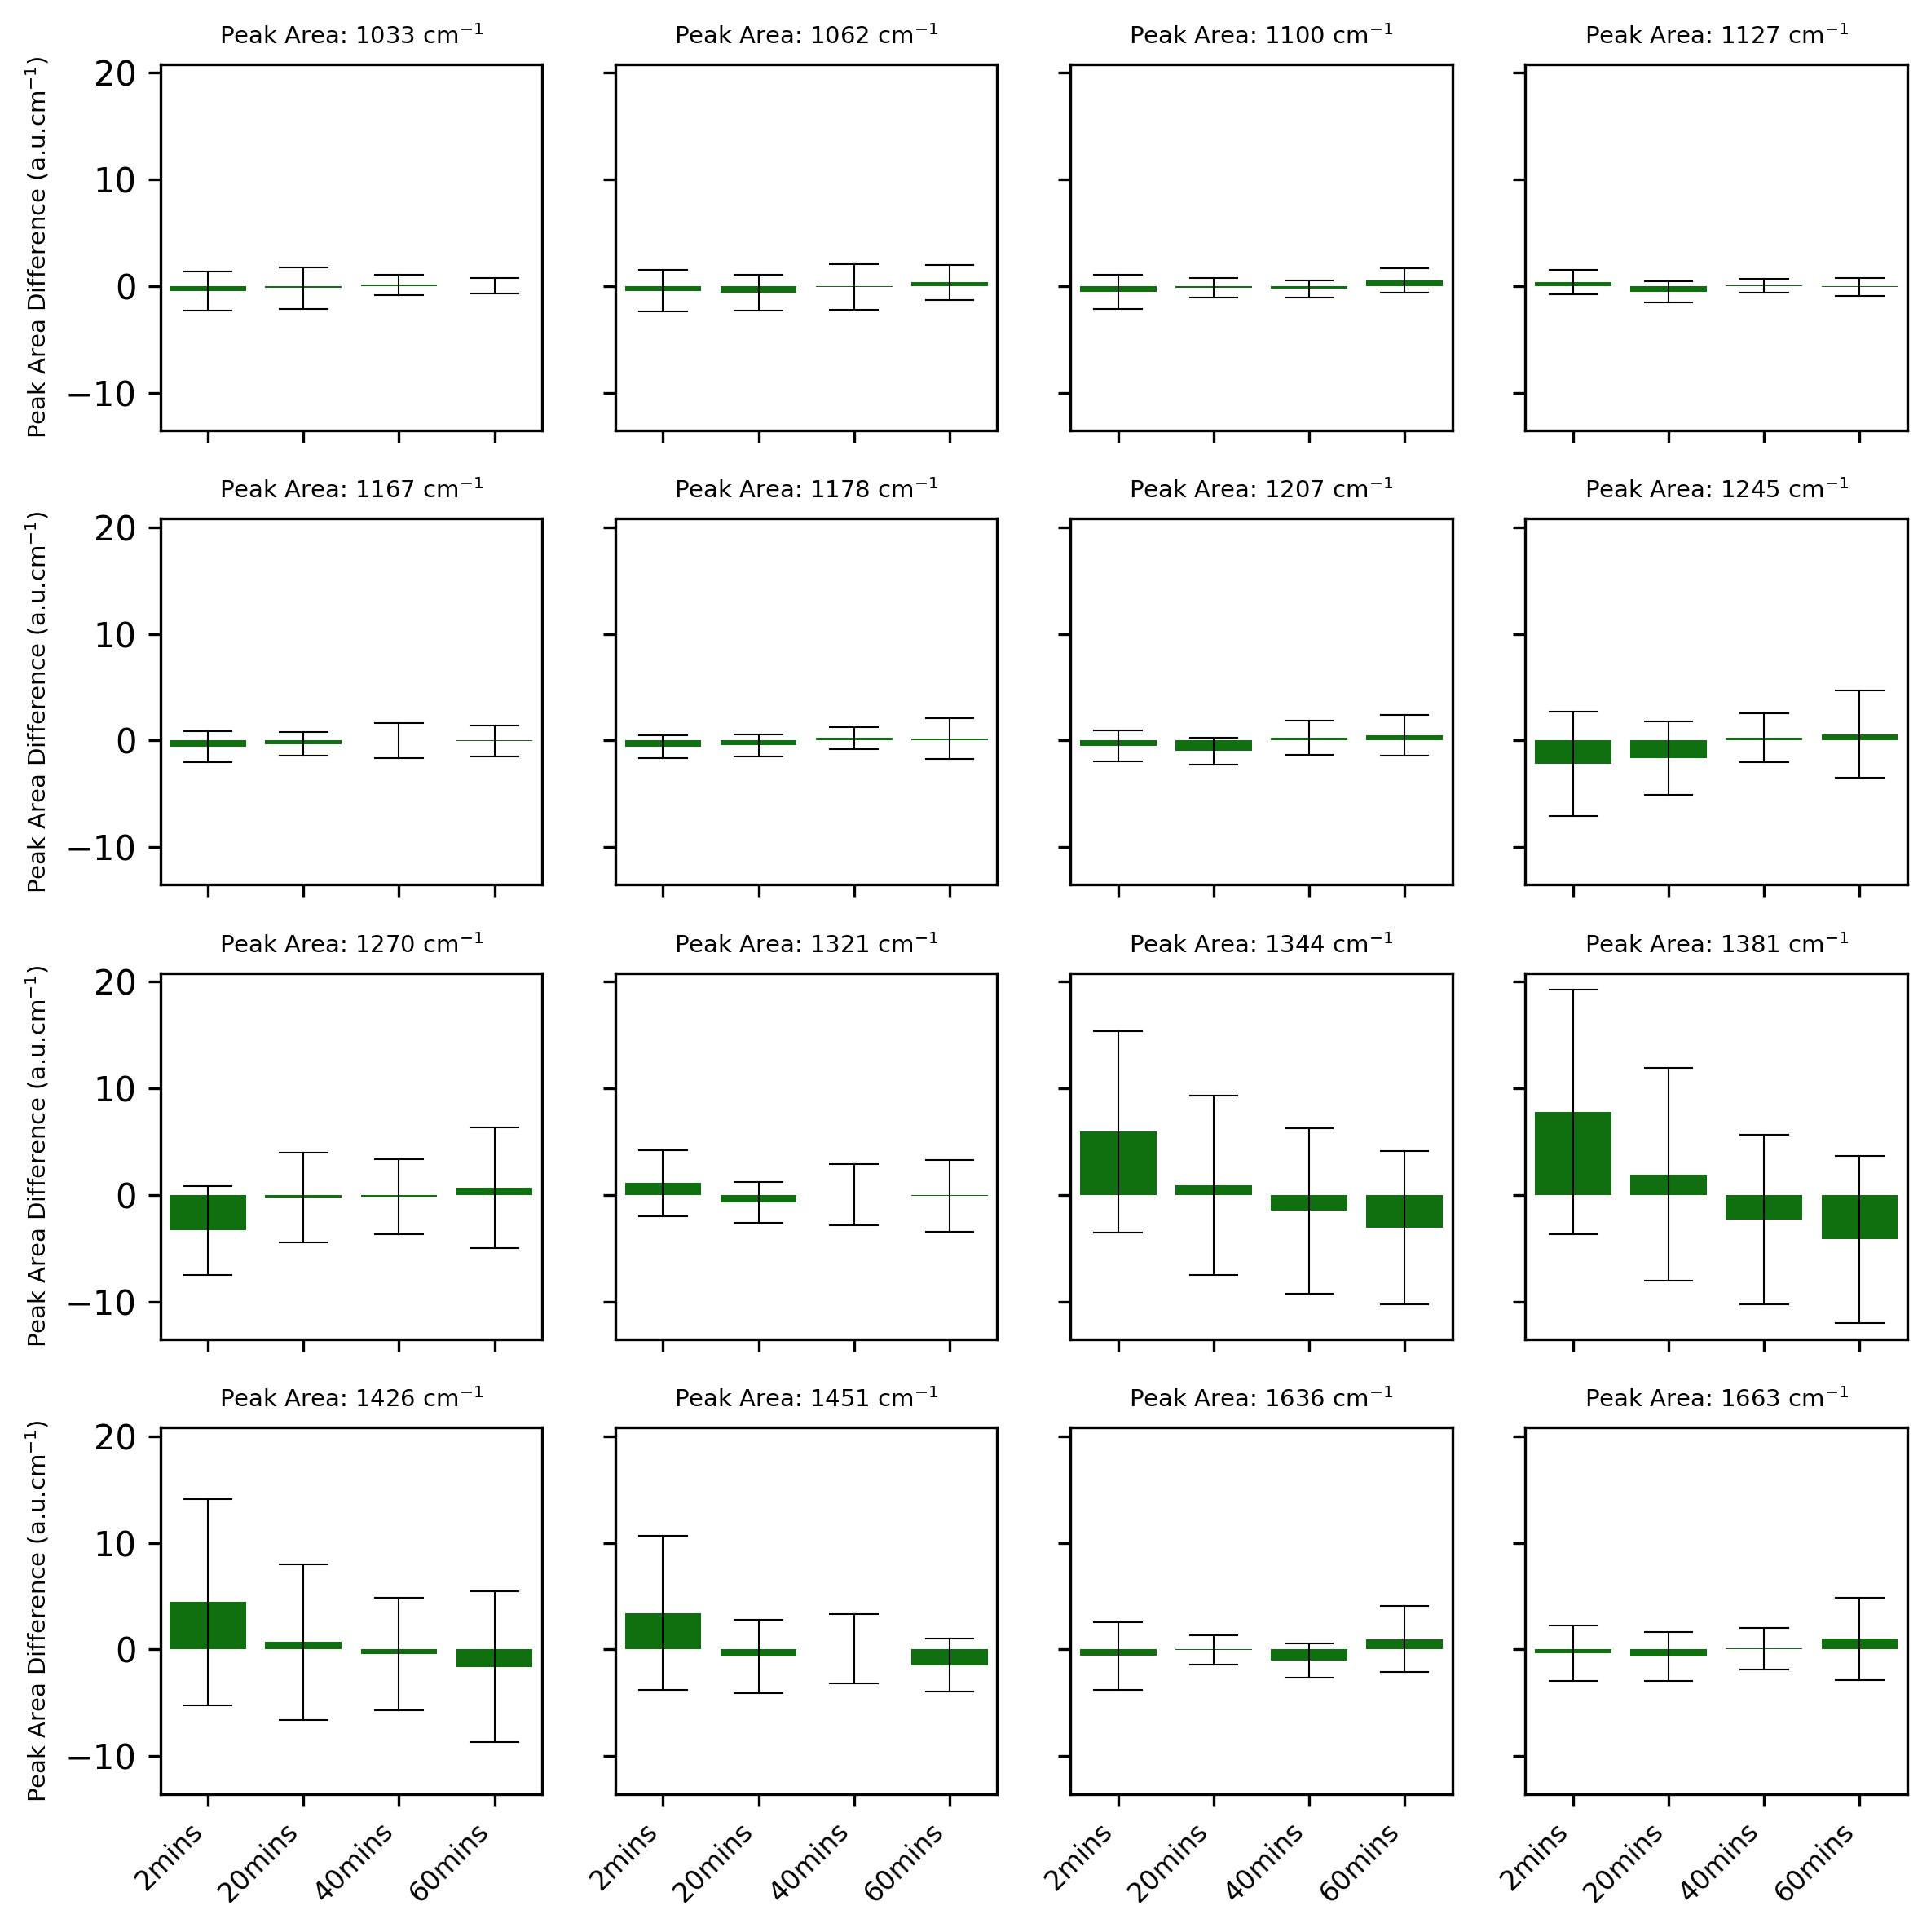

In [219]:
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (8, 8), dpi = 300, sharex = True, sharey = True)
ax_flat = axes.flatten()
pks = [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]
#plt.figure(figsize = (8, 2), dpi = 300);#(diff_result_df['trt_time'].isin(['2mins', '20mins','40mins', '60mins'])) & (diff_result_df['peak_pos'].isin([1636]))
for i, ax in enumerate(ax_flat):
    
    sns.barplot(
        data = diff_result_df[(diff_result_df['orient'] == 'Para') & (diff_result_df['peak_pos'] == pks[i])],
        x = 'trt_time',
        y = 'diff_area',
        #hue = 'trt_time',
        order = ['2mins', '20mins','40mins', '60mins'],
        estimator = 'mean',
        errorbar='sd',
        #legend = False,
        color = 'green',
        #palette="hls",
        capsize = .5,
        #edgecolor = 'black',
        err_kws={'linewidth': .5, 'color': 'black'},
        #markersize = 3,
        #linewidth =1'''
        #dodge = 1,
        #size = 5,
        #edgecolor='black',
        #linewidth = .5,'''
        ax = ax
    )
    ax.set_xticks([0, 1, 2, 3]) 
    ax.set_xticklabels([ '2mins', '20mins','40mins', '60mins'], rotation=45, ha = 'right', fontsize = 8);
    #ax.set_yticklabels(rotation=45, ha = 'right', fontsize = 6);
    ax.set_ylabel('Peak Area Difference (a.u.cm$^{-1}$)', fontsize = 7)
    ax.set_xlabel('')
    ax.set_title(f'Peak Area: {pks[i]} cm$^{{-1}}$', fontsize = 7)

plt.tight_layout()
#plt.savefig(f'C:\\Users\\oadeji01\\OneDrive - Tufts\\Bunmi - NavehLab-01\\Reports\\Paper\\Figures\\Peakfit_Area_Para.tif', dpi = 600, bbox_inches='tight')

In [220]:
diff_result_df

peak_pos trt_time orient  diff_amp  diff_fwhm  diff_area
0        1033    2mins   Para -0.028401   1.163571  -0.648018
1        1033    2mins   Para -0.009181   2.490860   0.666084
2        1033    2mins   Para -0.091480  -1.170538  -2.858619
3        1033    2mins   Para -0.009001   6.424016   1.959430
4        1033    2mins   Para -0.050567  -0.735202  -1.456851
..        ...      ...    ...       ...        ...        ...
635      1663   60mins   Orth  0.065072  -2.241546   1.597530
636      1663   60mins   Orth -0.005494   1.299929   0.343370
637      1663   60mins   Orth  0.081601   0.332651   3.565230
638      1663   60mins   Orth -0.052350   1.724449  -1.558176
639      1663   60mins   Orth -0.017443   1.791192   0.116314

[640 rows x 6 columns]

In [226]:
data = []
for x in ['diff_amp', 'diff_fwhm', 'diff_area']:
    for o in ['Para', 'Orth']:
        for p in diff_result_df['peak_pos'].unique():
            tukey = pairwise_tukeyhsd(endog=diff_result_df[(diff_result_df['orient'] == o) & (diff_result_df['peak_pos'] == p)][x],
                                        #dff['Scores on Comp 3 (52.75%)'], dff['Scores on Comp 2 (16.16%)']
                                        groups=diff_result_df[(diff_result_df['orient'] == o) & (diff_result_df['peak_pos'] == p)]['trt_time'],
                                        alpha=0.05
                                        )
            #display results
            #print(f"Results for {x}, {o}, {p}")
            #print(tukey)
            #print('*****************************************************')
            data.append(pd.DataFrame(tukey.summary().data[1:], columns = tukey.summary().data[0]))

In [230]:
pd.concat(data, ignore_index=True)

group1  group2  meandiff   p-adj   lower   upper  reject
0    20mins   2mins   -0.0365  0.4853 -0.1082  0.0352   False
1    20mins  40mins    0.0123  0.9598 -0.0594  0.0840   False
2    20mins  60mins    0.0036  0.9989 -0.0681  0.0754   False
3     2mins  40mins    0.0488  0.2483 -0.0229  0.1205   False
4     2mins  60mins    0.0401  0.4057 -0.0316  0.1118   False
..      ...     ...       ...     ...     ...     ...     ...
571  20mins  40mins    0.7953  0.9510 -3.5137  5.1043   False
572  20mins  60mins    1.3562  0.8047 -2.9528  5.6652   False
573   2mins  40mins    0.7721  0.9549 -3.5369  5.0811   False
574   2mins  60mins    1.3330  0.8126 -2.9760  5.6420   False
575  40mins  60mins    0.5609  0.9817 -3.7481  4.8699   False

[576 rows x 7 columns]

In [ ]:
pvals = []
stats = []
for rat in [1033, 1062, 1100, 1127, 1167, 1178, 1207, 1245, 1270, 1321, 1344, 1381, 1426, 1451, 1636, 1663]:
    for o in ['Orth']:
        for x in ['2mins','20mins', '40mins', '60mins']:
            exp_mean_ctrl = diff_result_df[(diff_result_df['orient'] == o) & (diff_result_df['sample'] == 'Ctrl') & (diff_result_df['peak_pos'] == rat)]['area'].values
            exp_mean_trt = diff_result_df[(diff_result_df['orient'] == o) & (diff_result_df['sample'] == 'Trt') & (diff_result_df['trt_time'] == x) & (diff_result_df['peak_pos'] == rat)]['area'].values

            tstat, p = ttest_ind(exp_mean_ctrl, exp_mean_trt, equal_var=False, alternative='two-sided')
            pvals.append(p)
            stats.append(tstat)


            reject, pvals_corr, _, _ = multipletests(
                p,
                alpha=0.05,
                method='holm-sidak'
                )
            
            if pvals_corr < .05:
                print(rat, o, x)
                print(reject, pvals_corr)
                print('///////////////////////////////////////////////////')
            else:
                pass

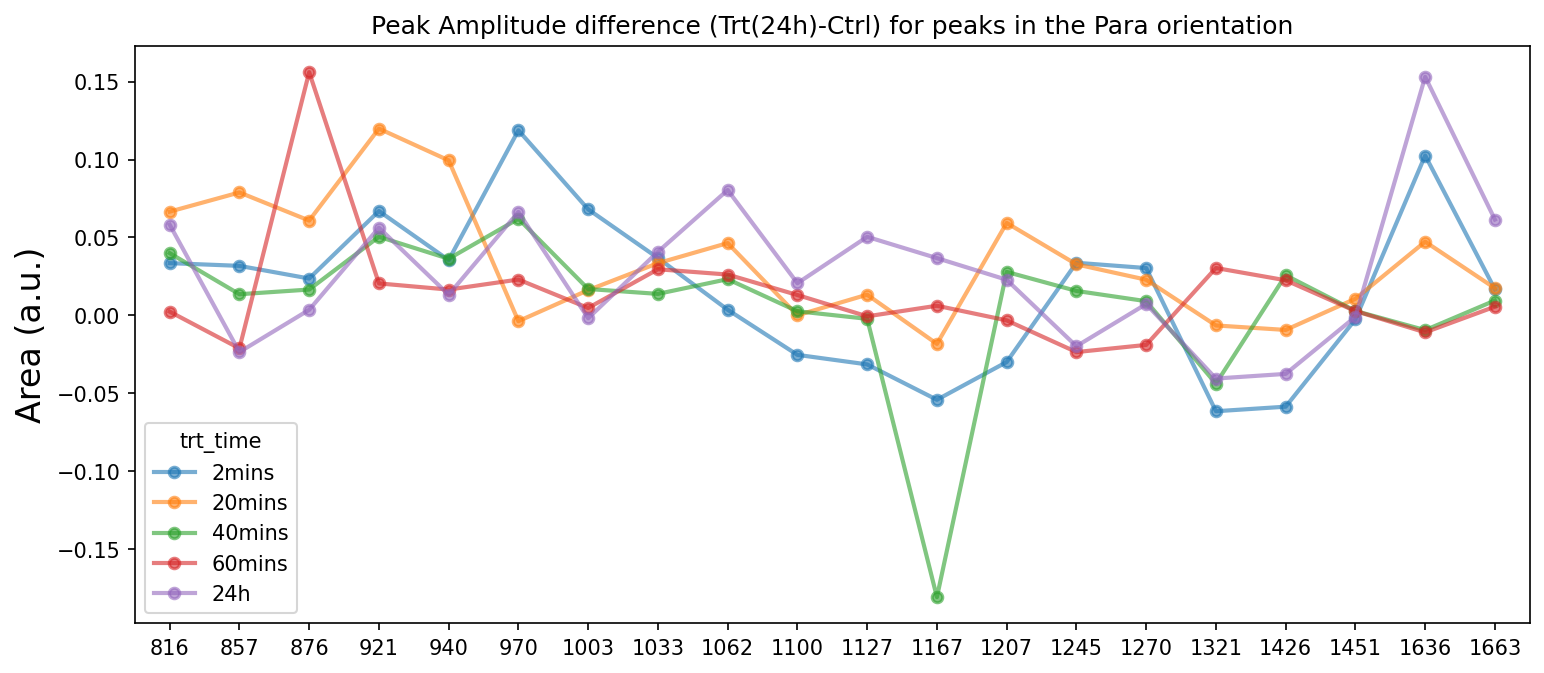

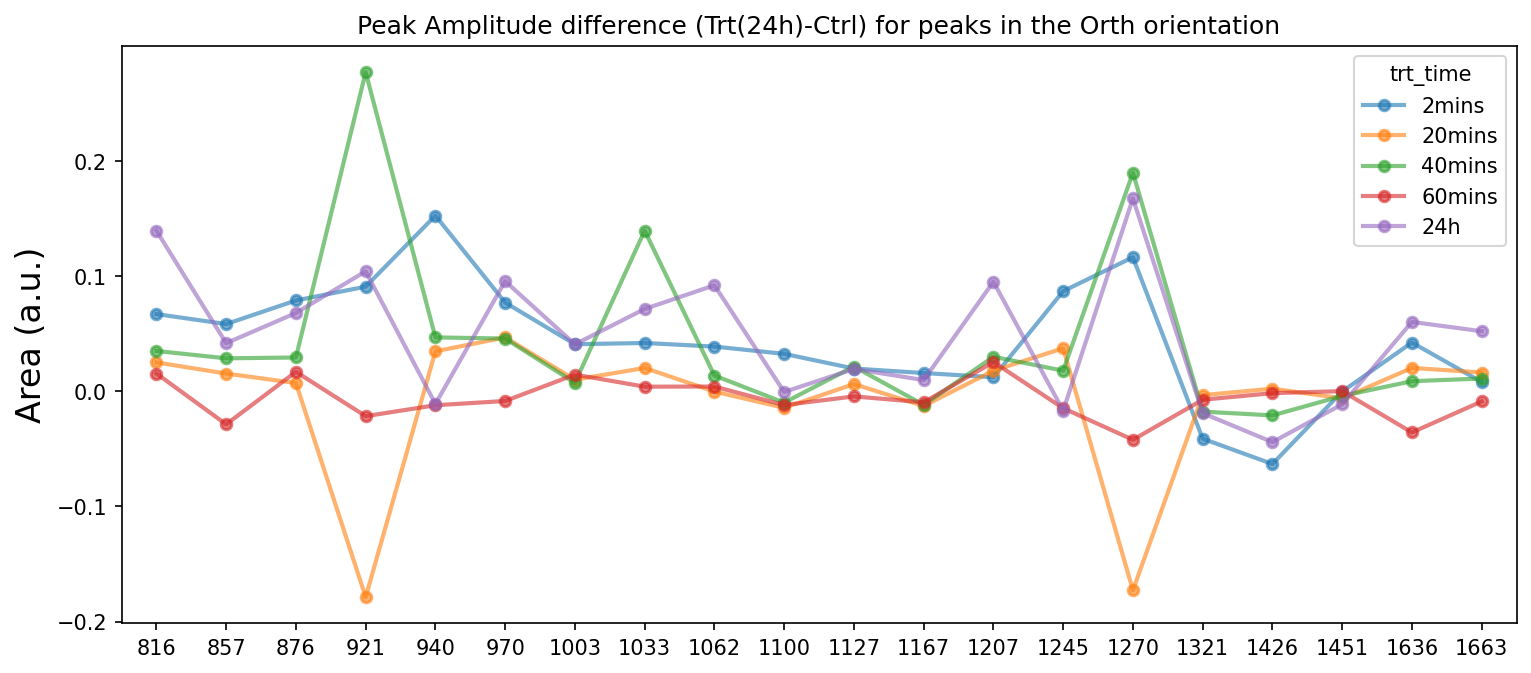

In [180]:
diff_result_df = pd.DataFrame(diff_results)


#for p in peak_positions:
for tp in diff_result_df['orient'].unique():
    plt.figure(figsize = (12, 5), dpi = 150);
    sns.pointplot(
                    data = diff_result_df[(diff_result_df['orient']==tp) & (diff_result_df['peak_pos'].isin([1344, 1381]) == False)],
                        x = 'peak_pos',
                        y = 'diff_amp',
                        hue = 'trt_time',
                        #order = [816, 857, 876, 921, 940, 970, 1003, 1033, 1062, 1100, 1127, 1167, 
                         #       1207, 1245, 1270, 1321,  1381, 1426, 1451, 1636, 1663],#1344,
                        #['2mins','20mins', '40mins', '60mins', '24h'],
                           # width = .5,
                            #dodge = .5, 
                            linewidth = 2,
                            #marker_kws={'edgecolor': 'gray', 'linewidth': 1},
                           alpha = .6,
                           errorbar='se'
                    );
    plt.title(f'Peak Amplitude difference (Trt(24h)-Ctrl) for peaks in the {tp} orientation')
    plt.ylabel('Area (a.u.)', fontsize = 16)
    plt.xlabel('')

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_1376\874550747.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (10, 5), dpi = 150);


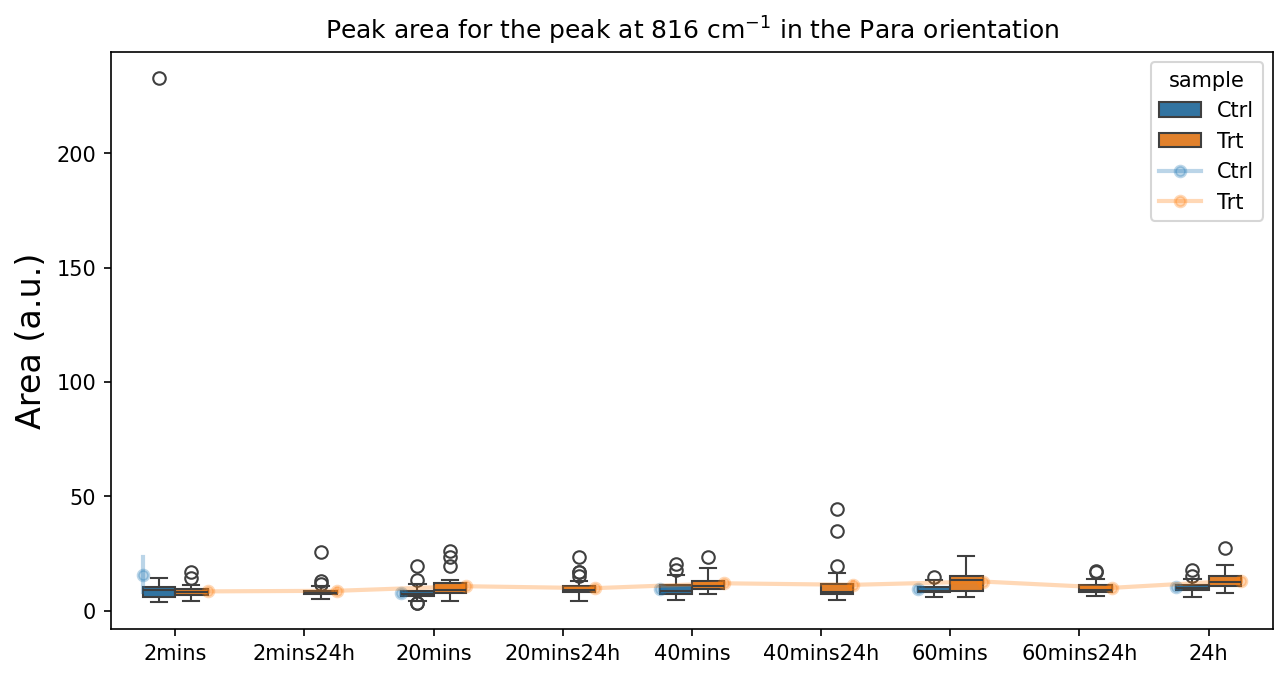

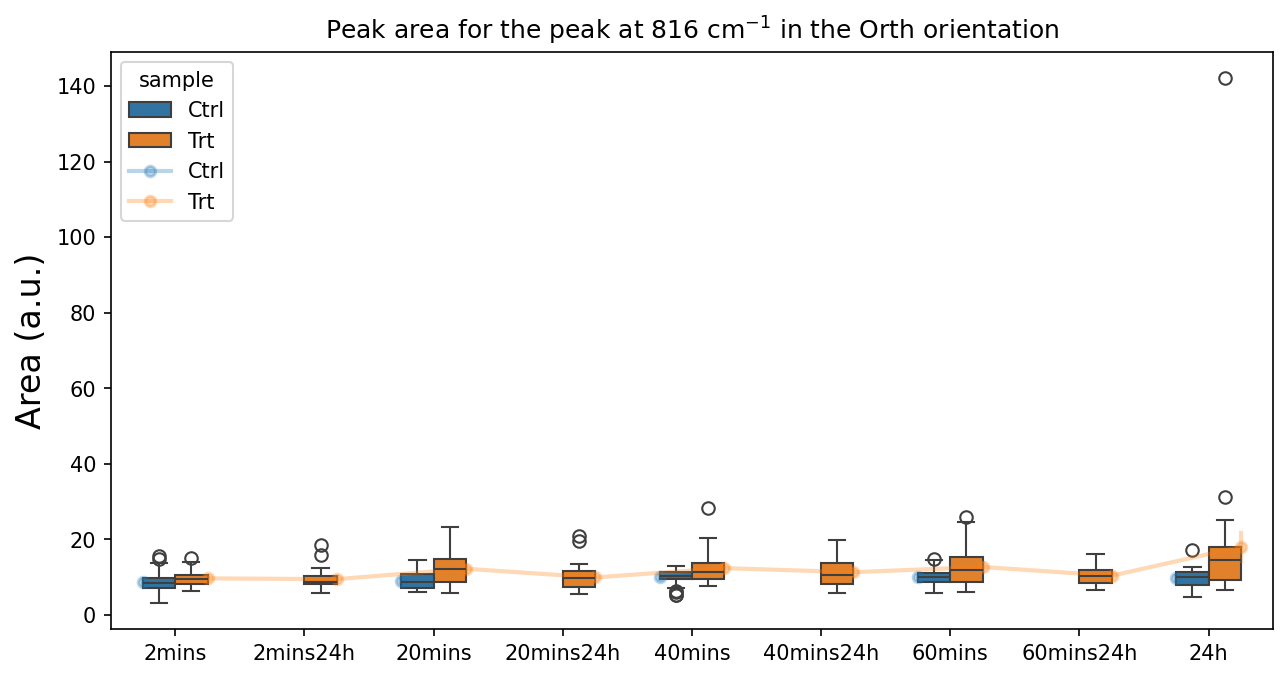

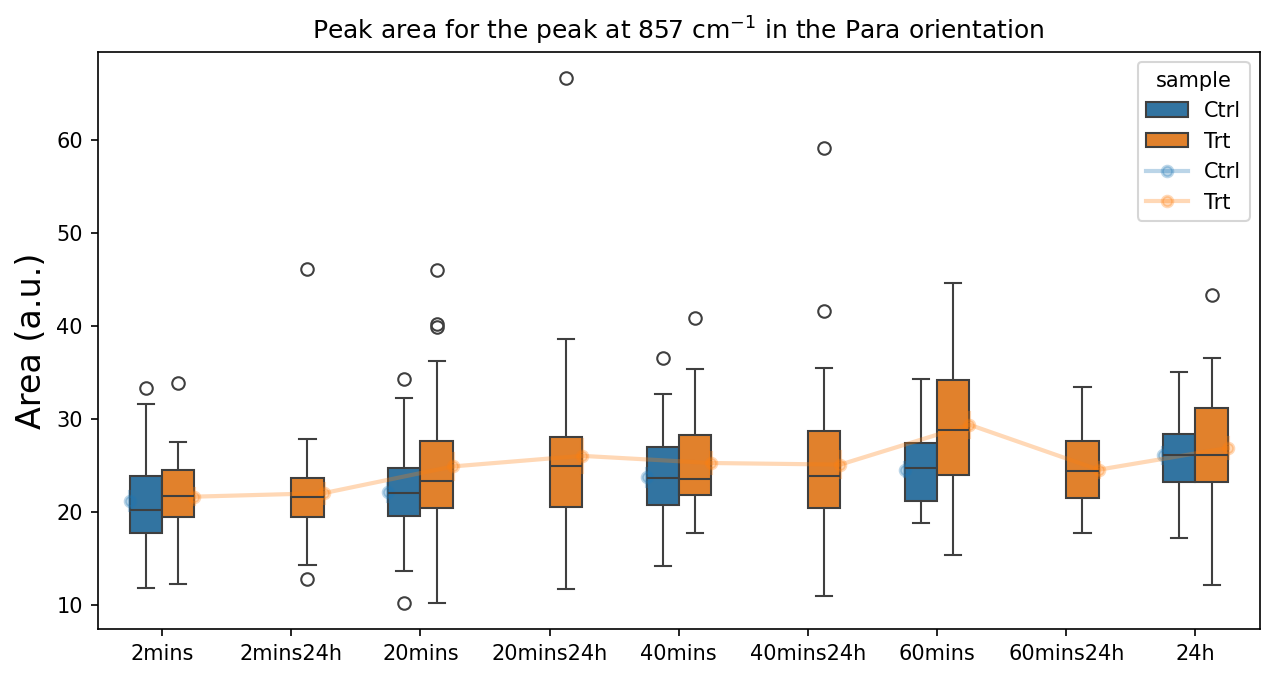

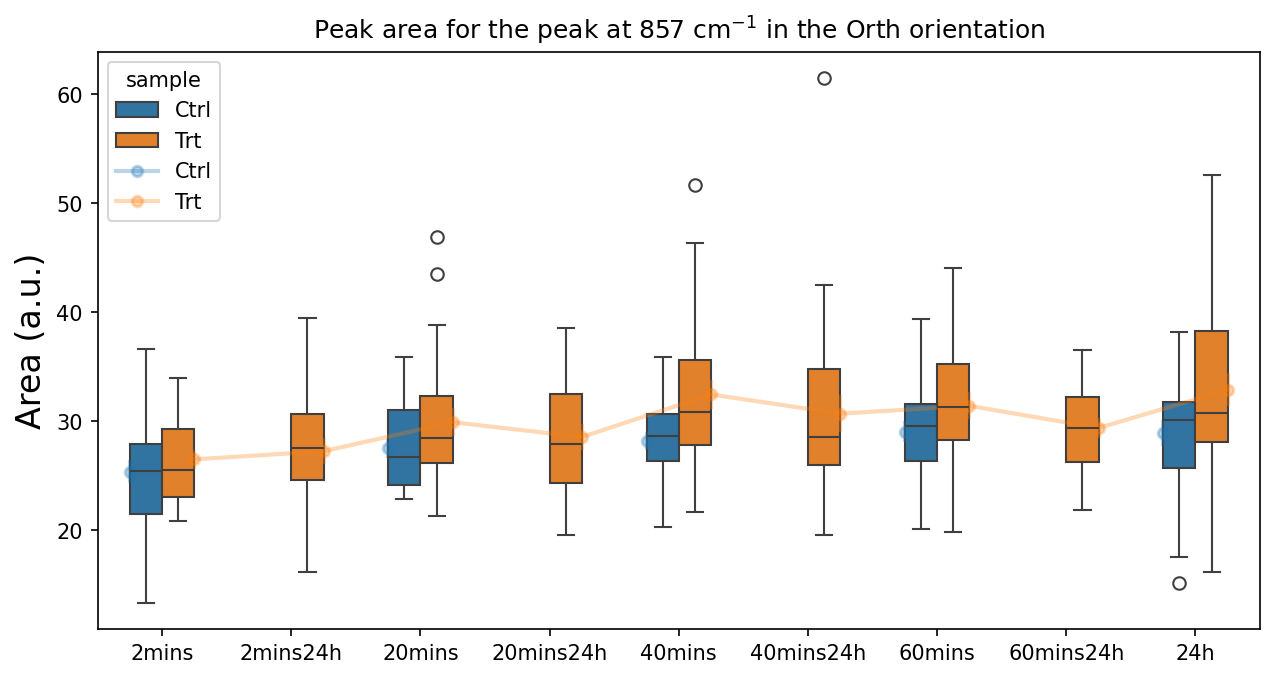

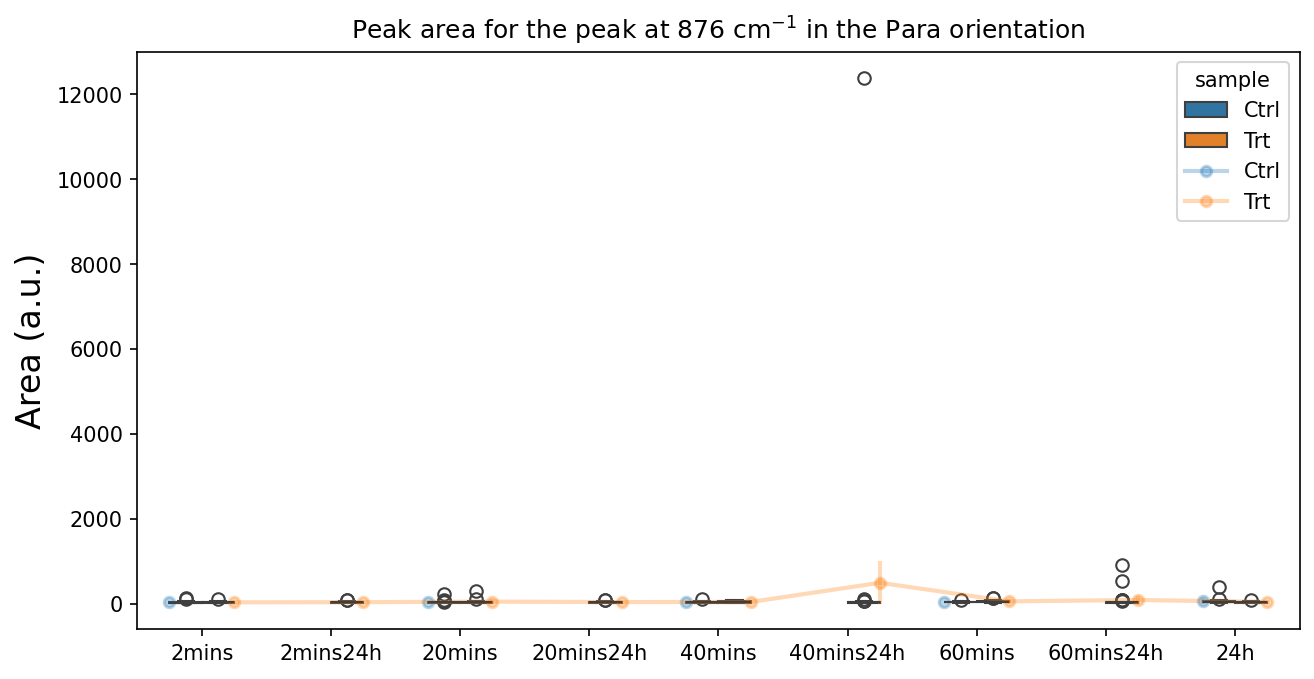

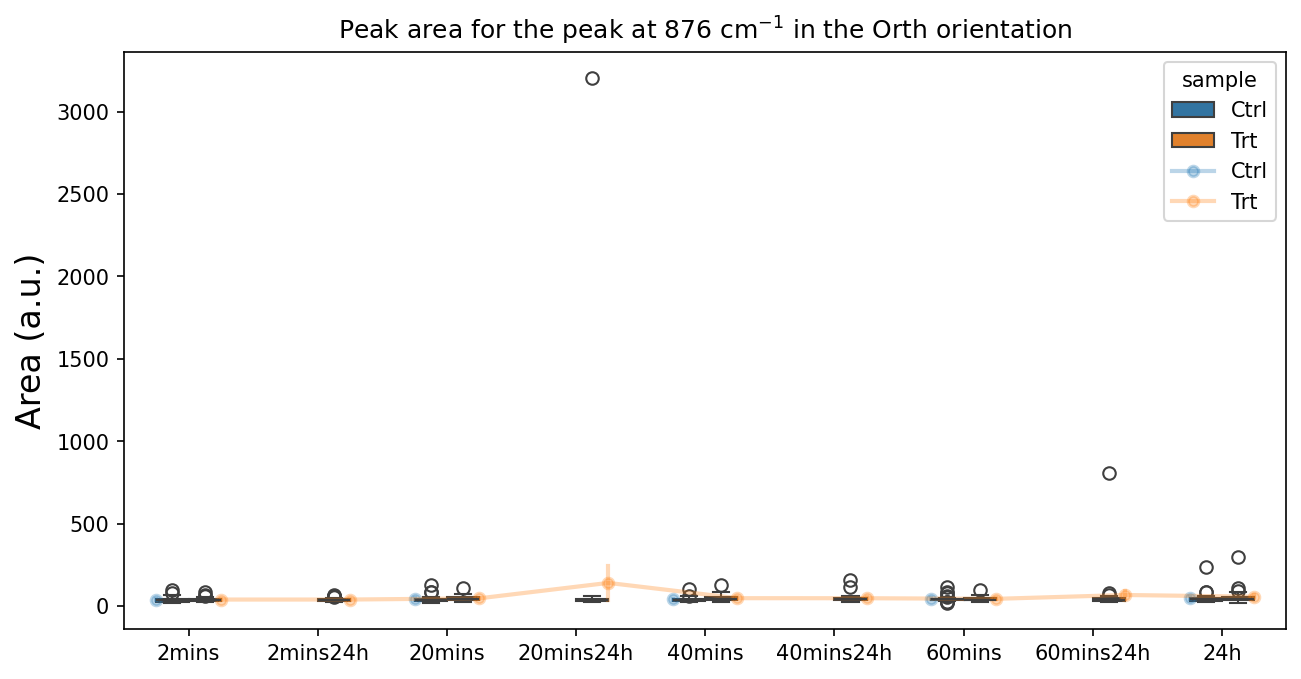

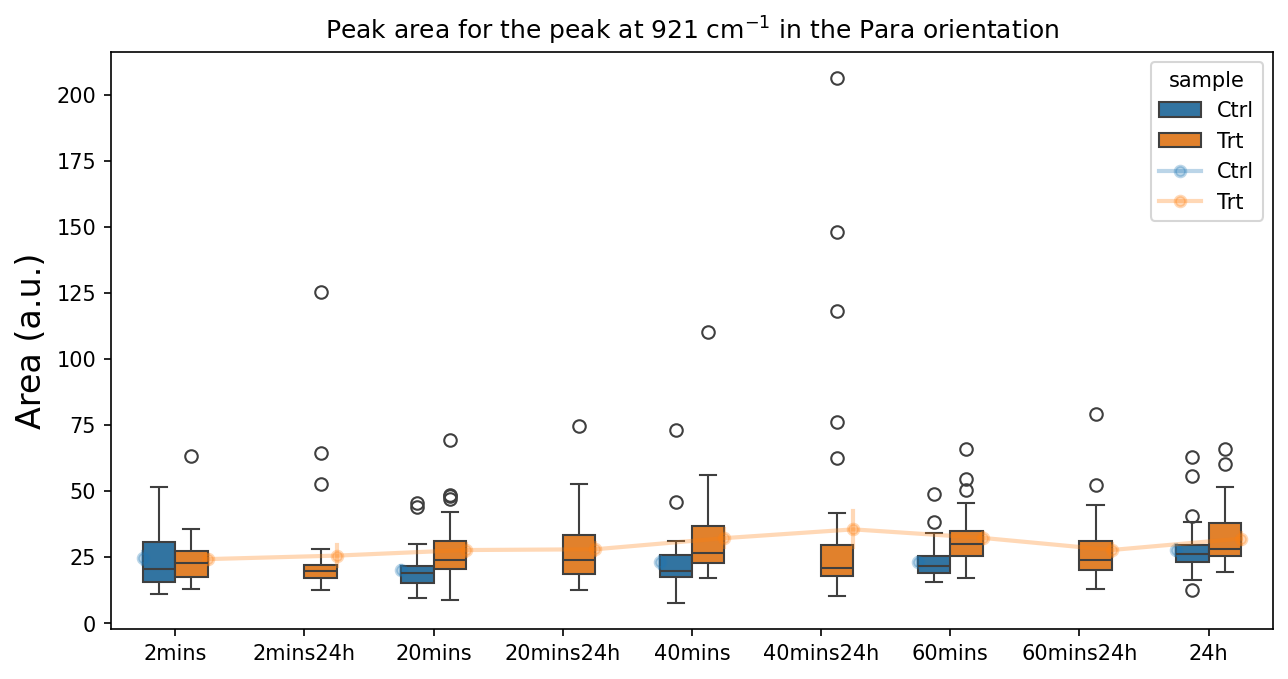

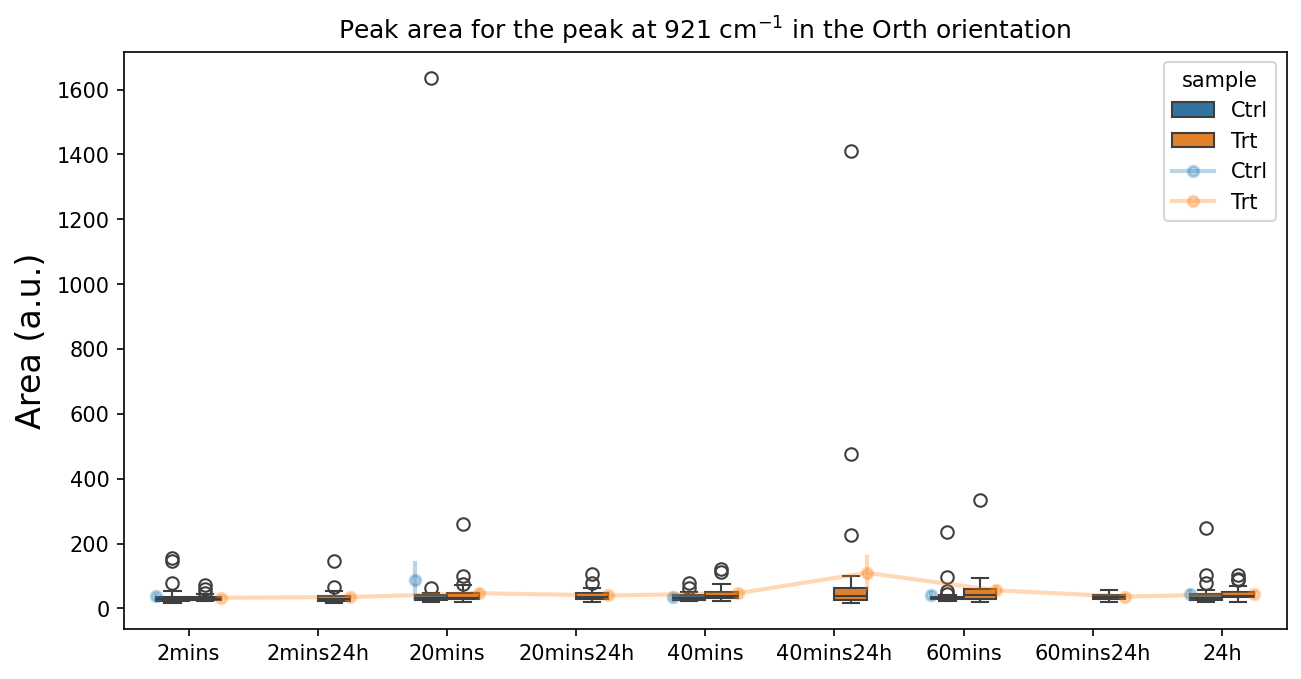

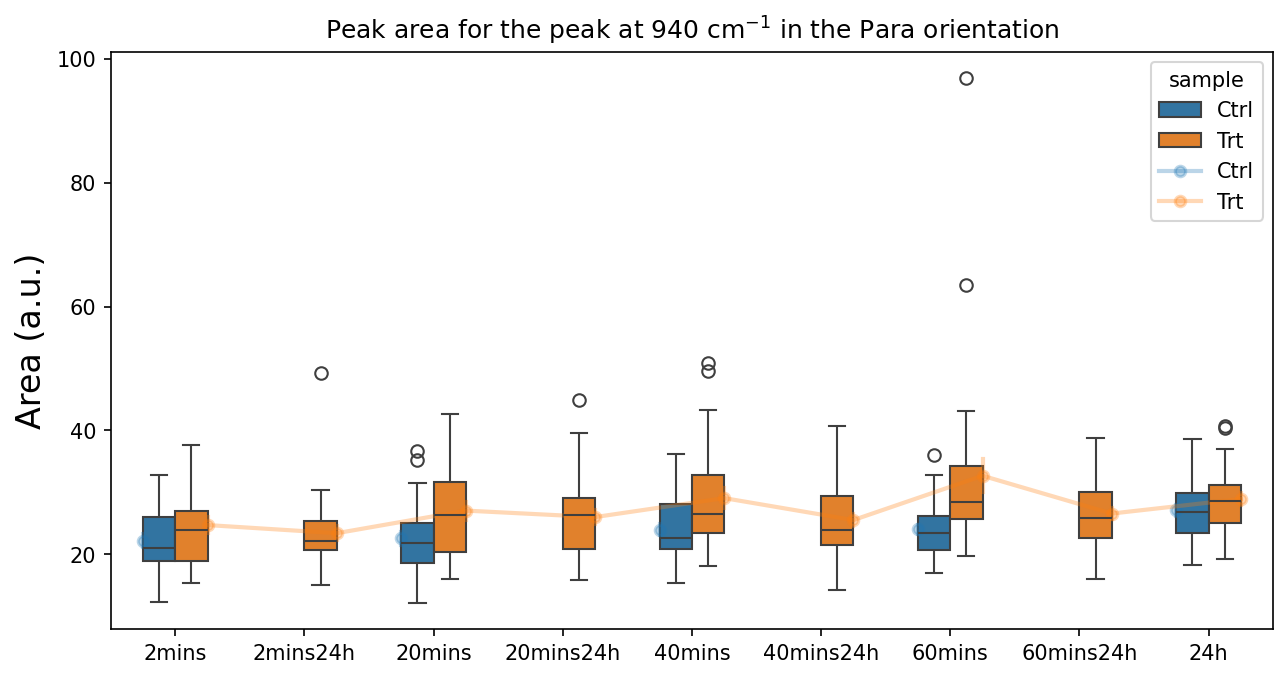

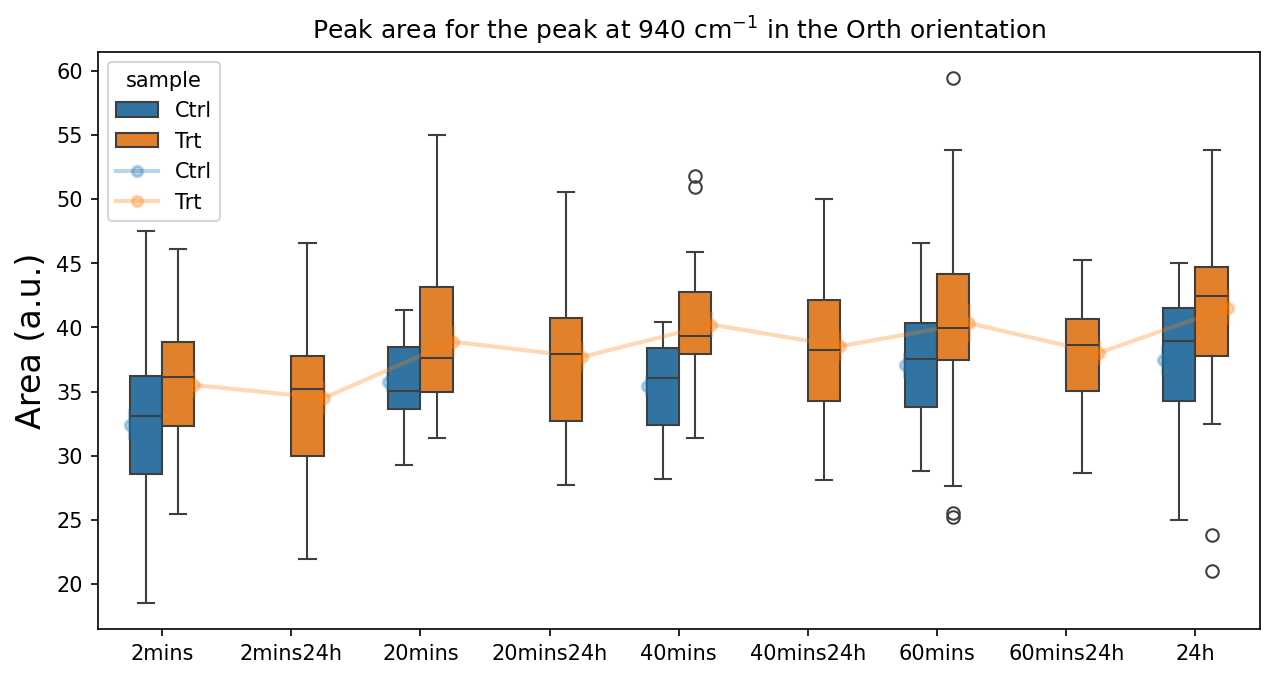

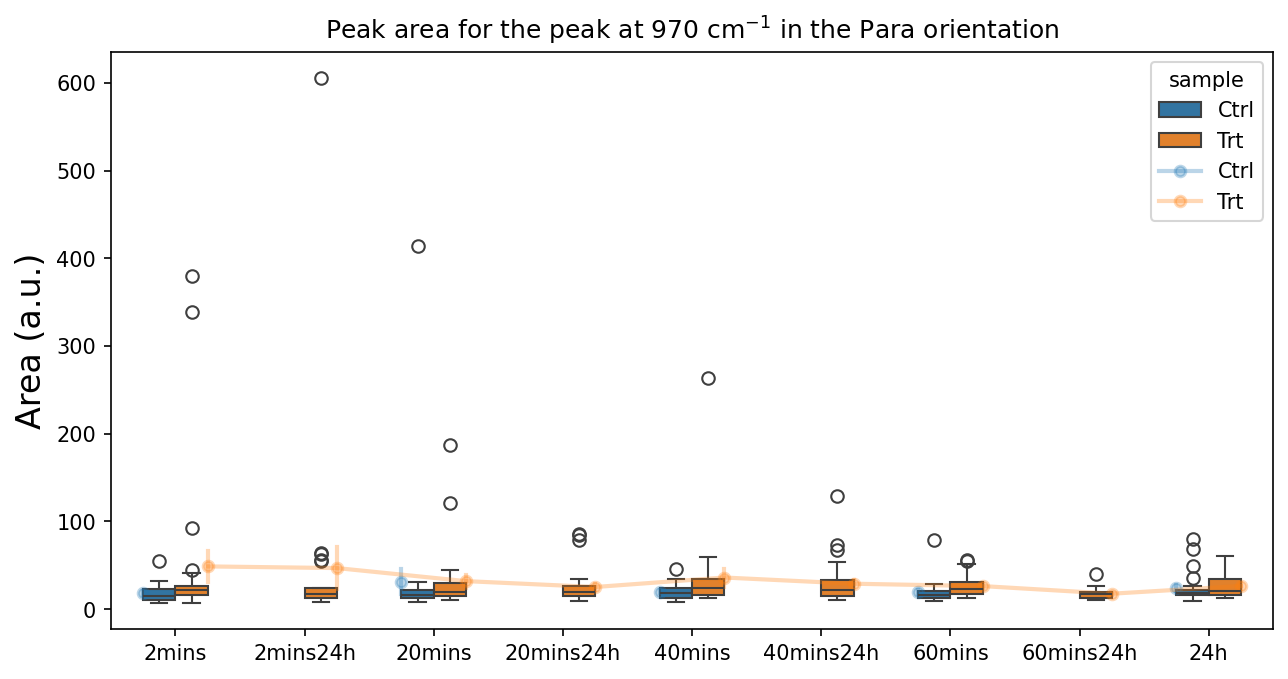

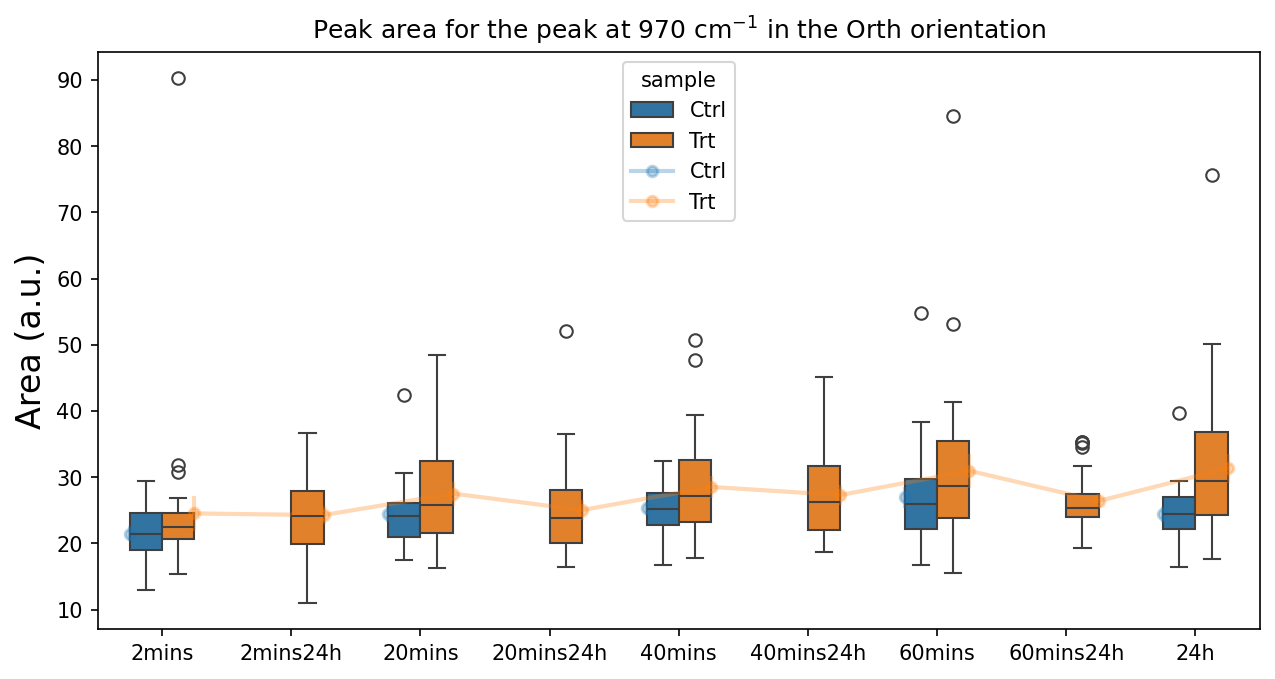

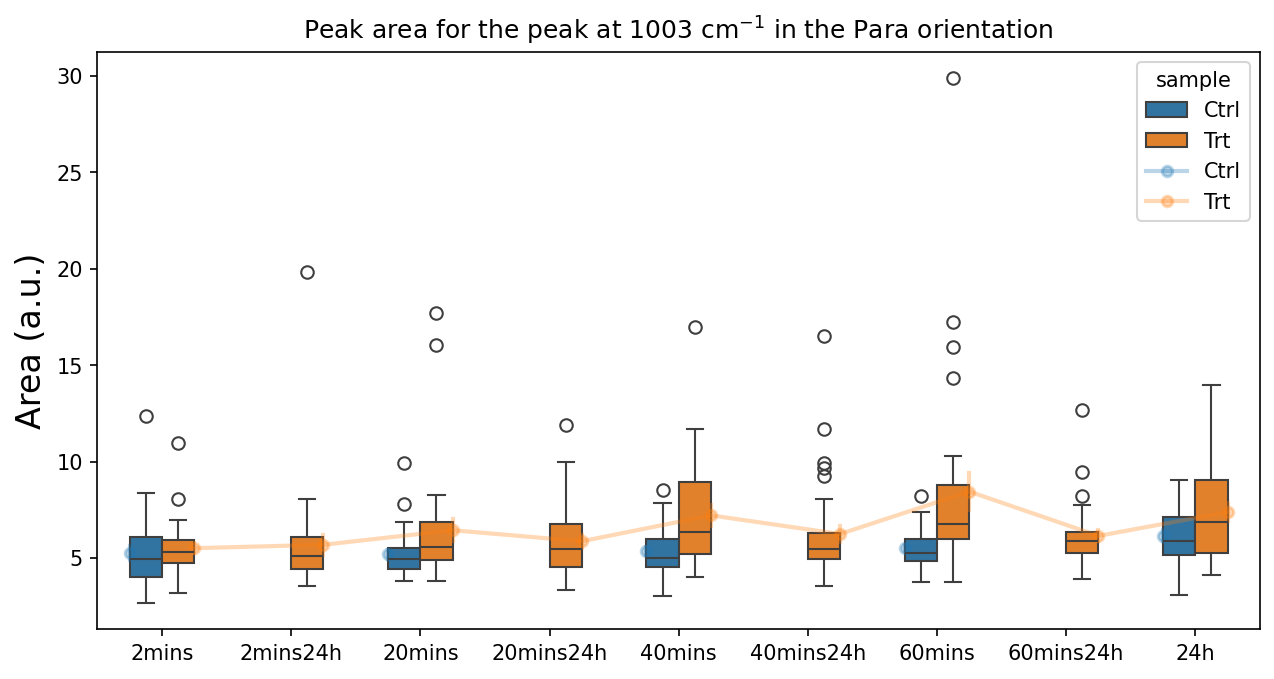

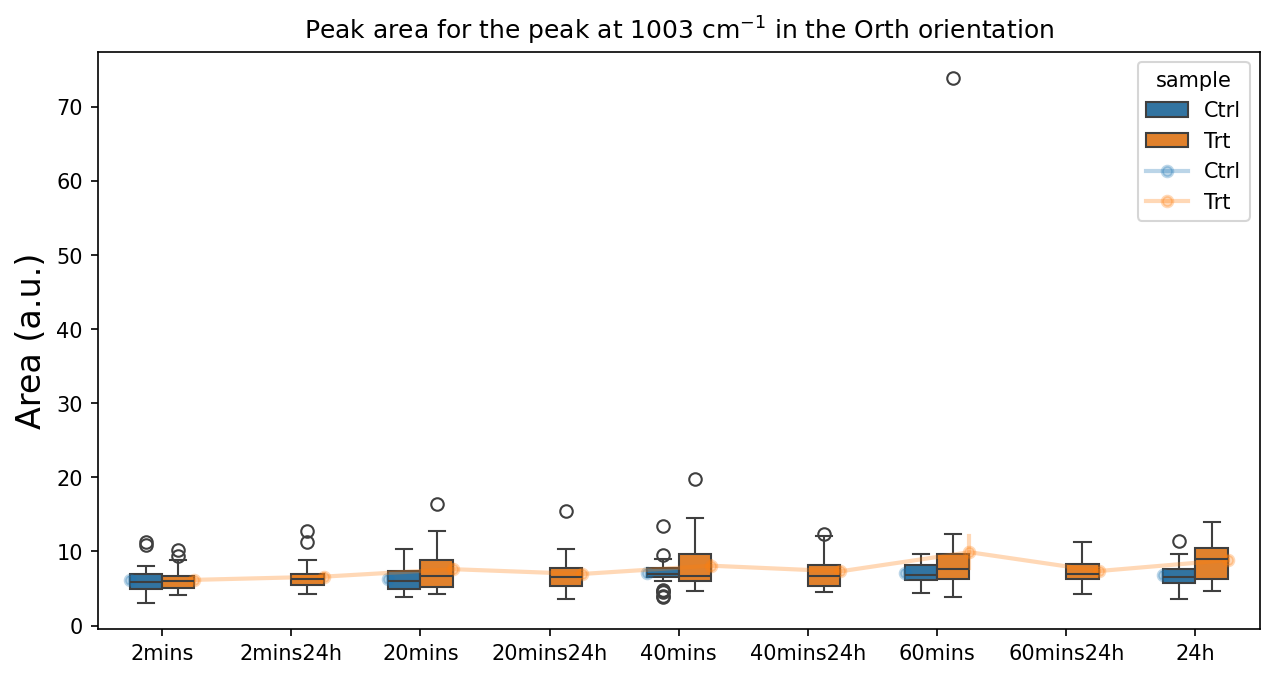

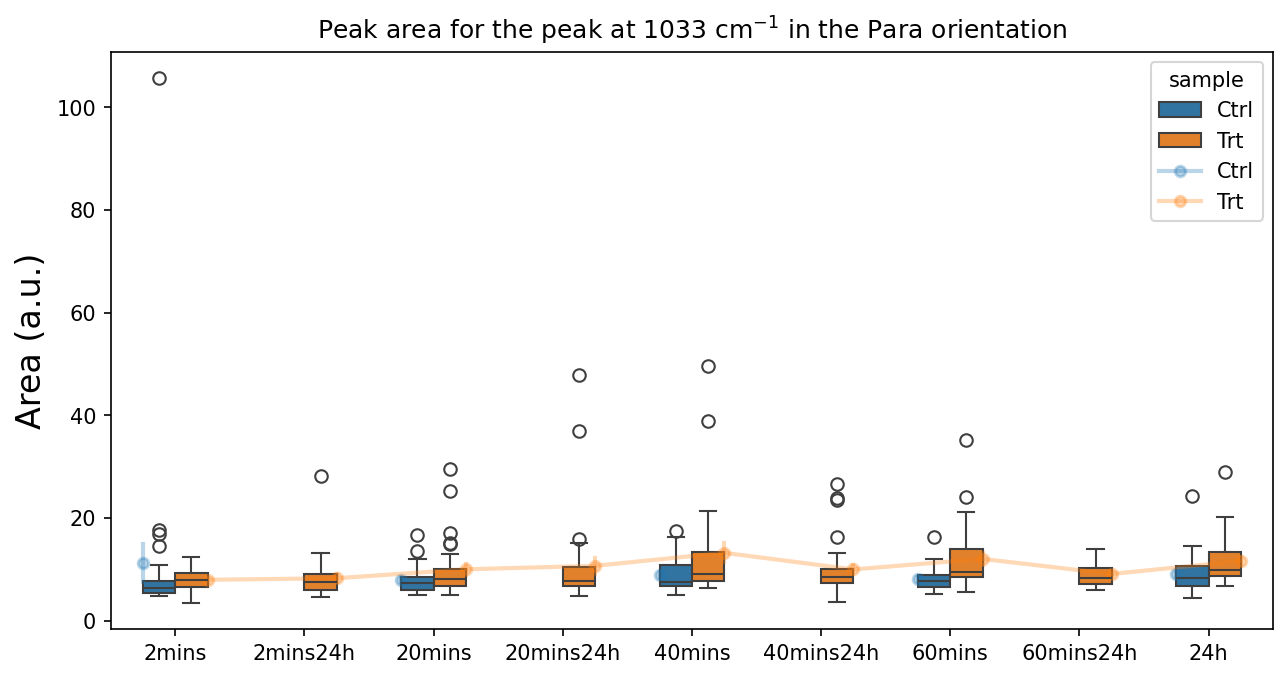

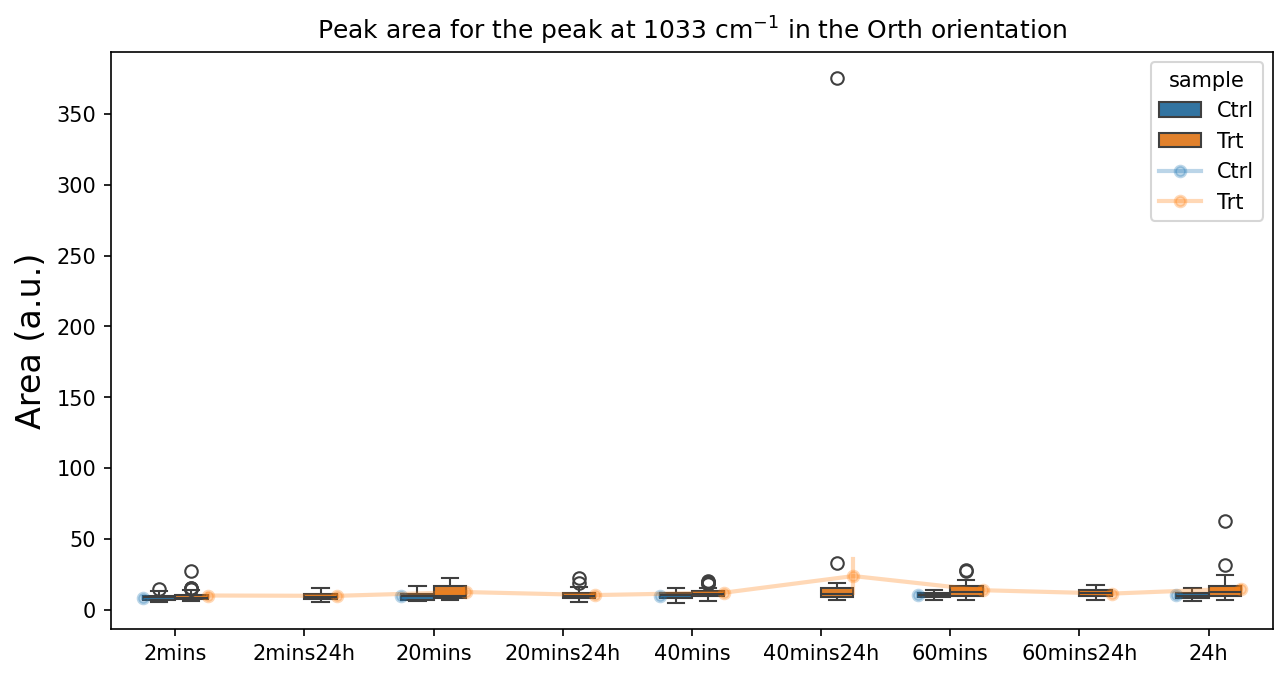

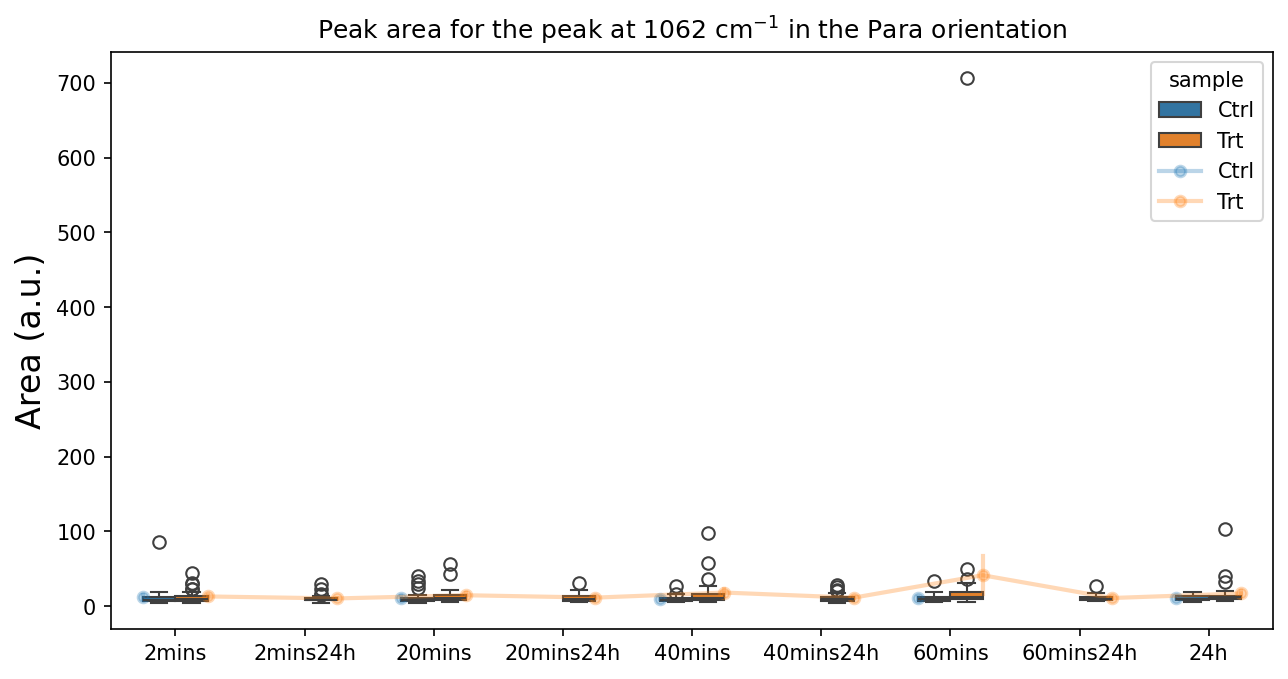

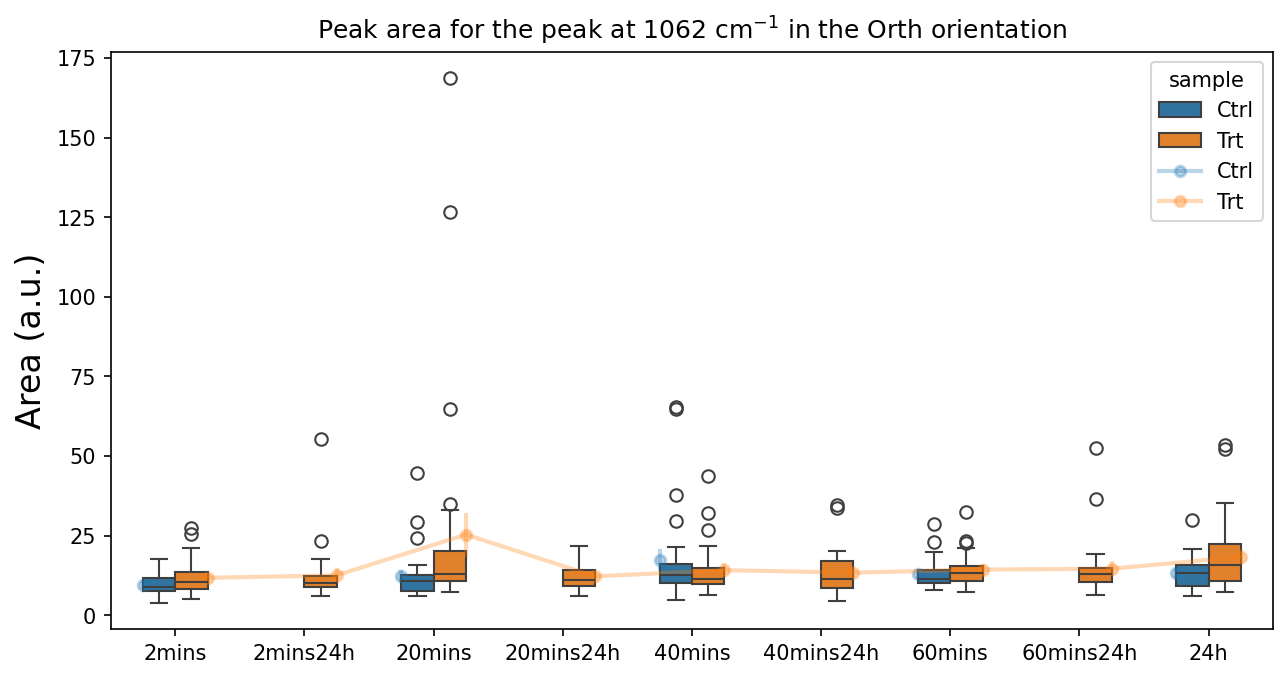

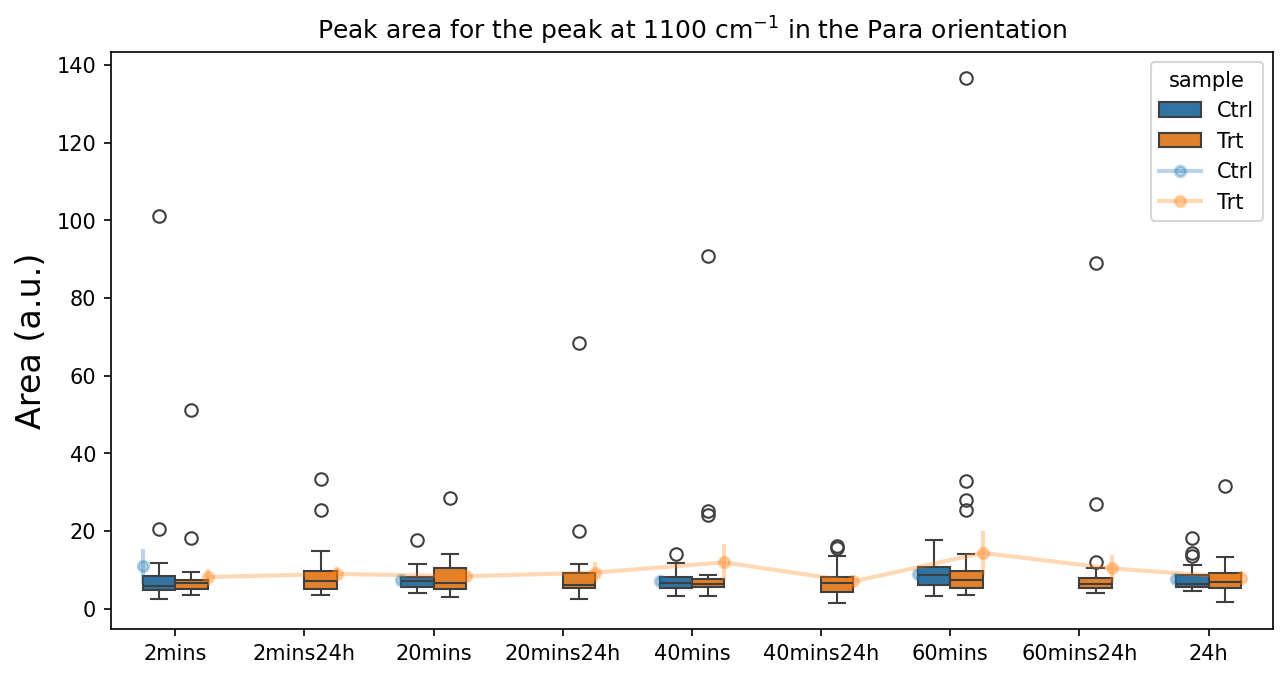

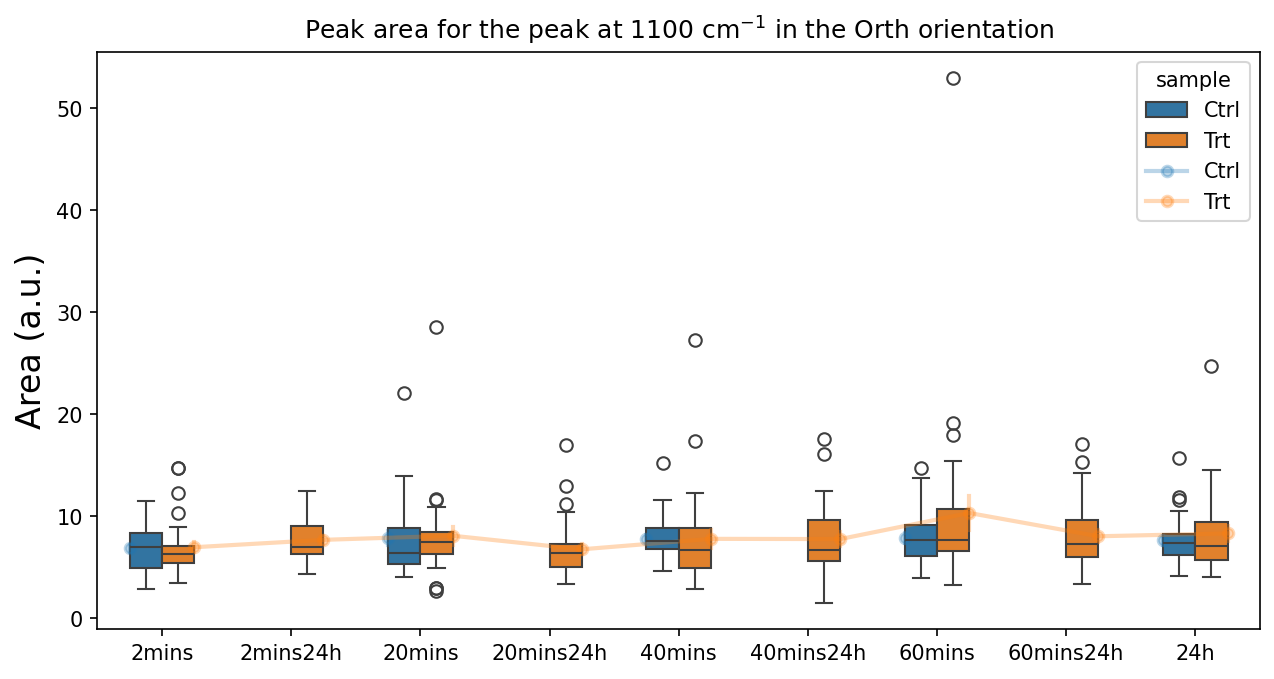

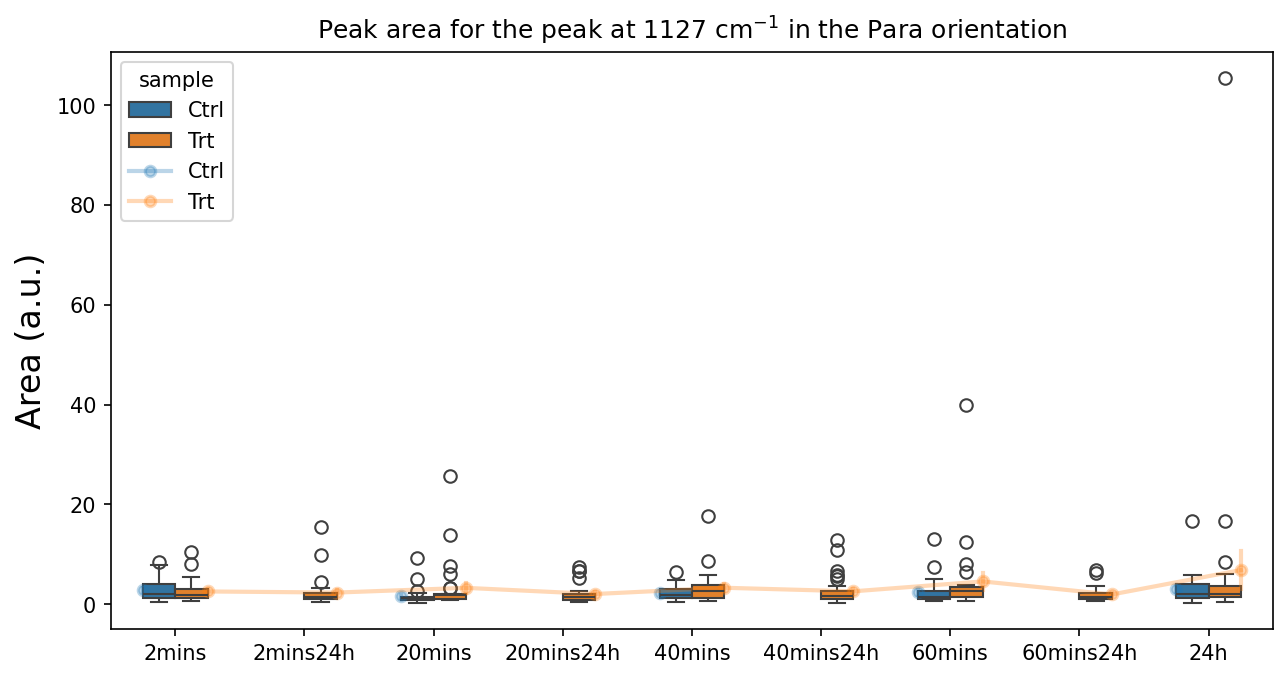

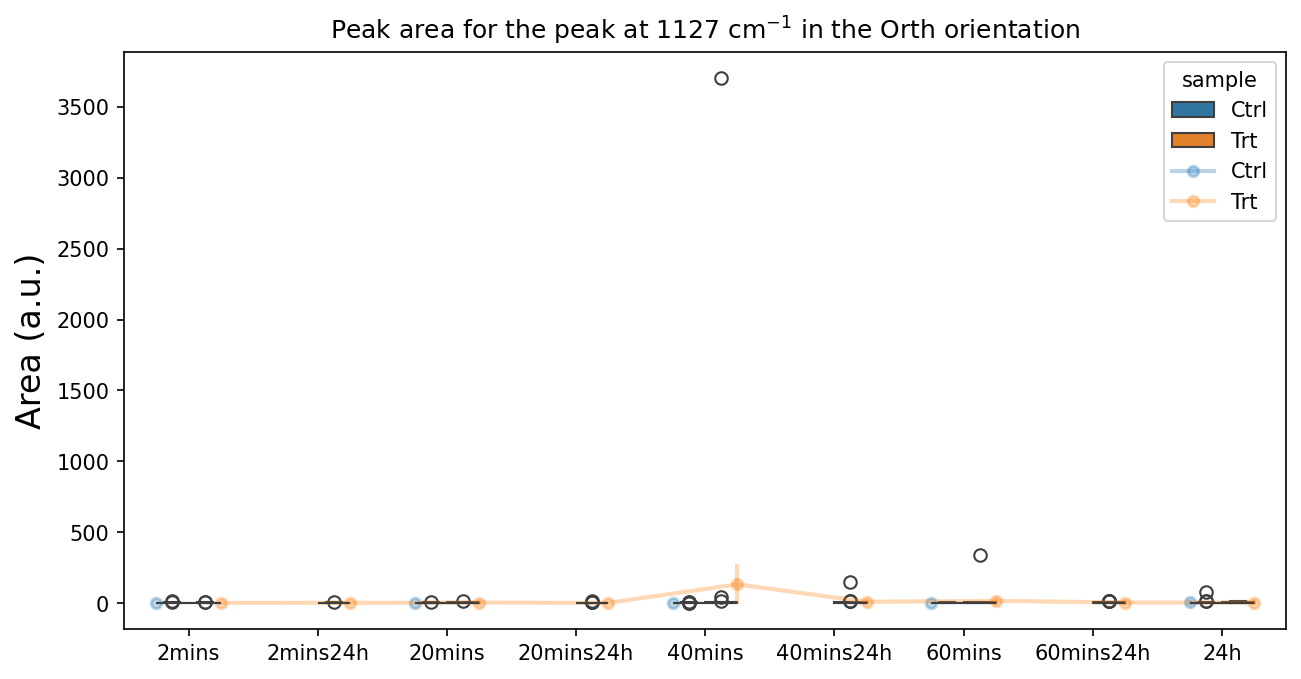

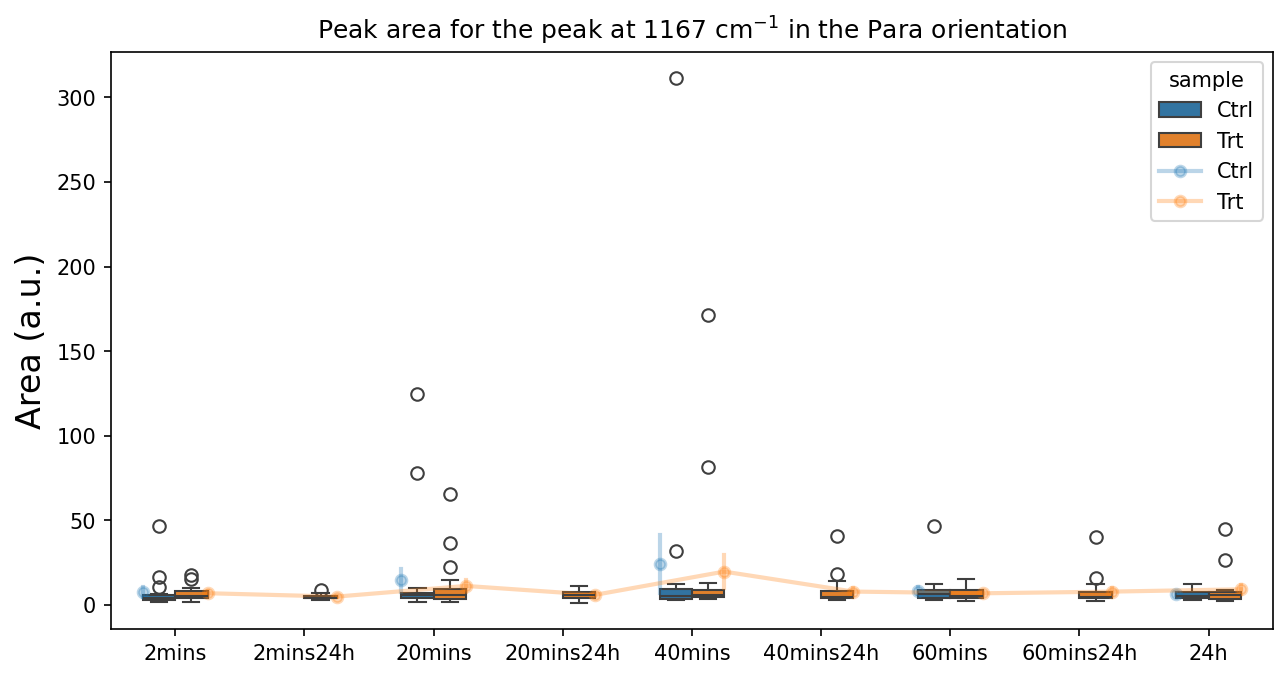

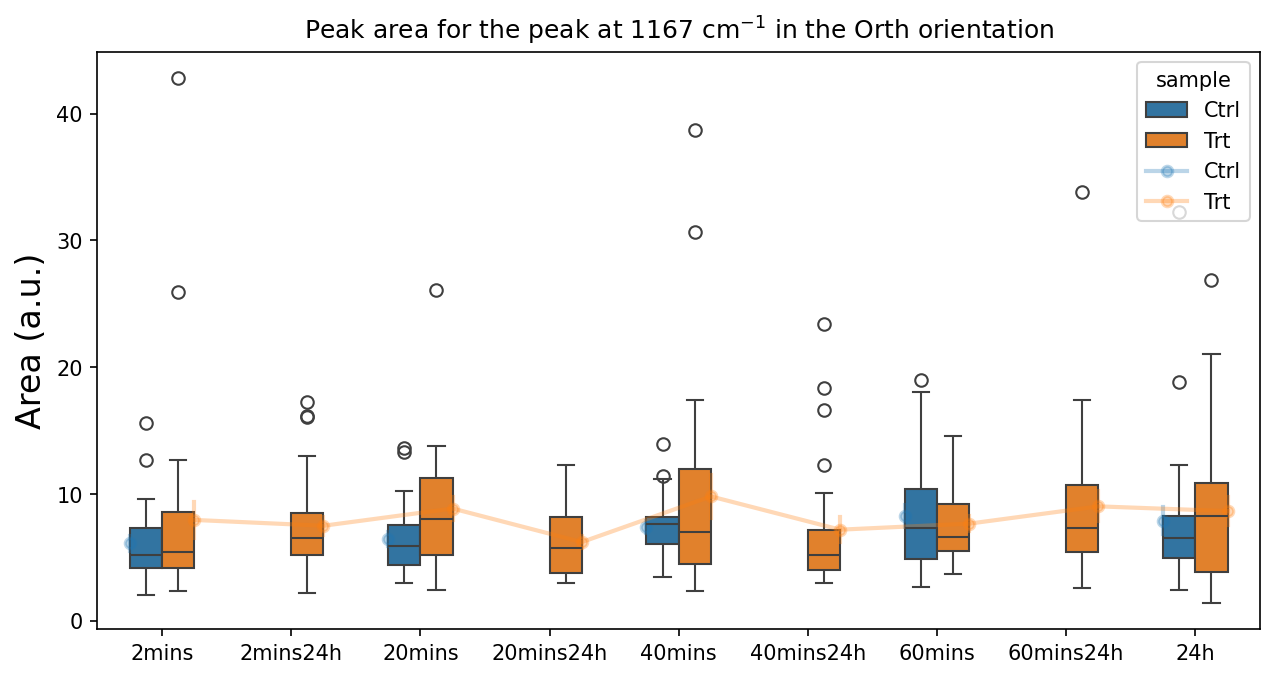

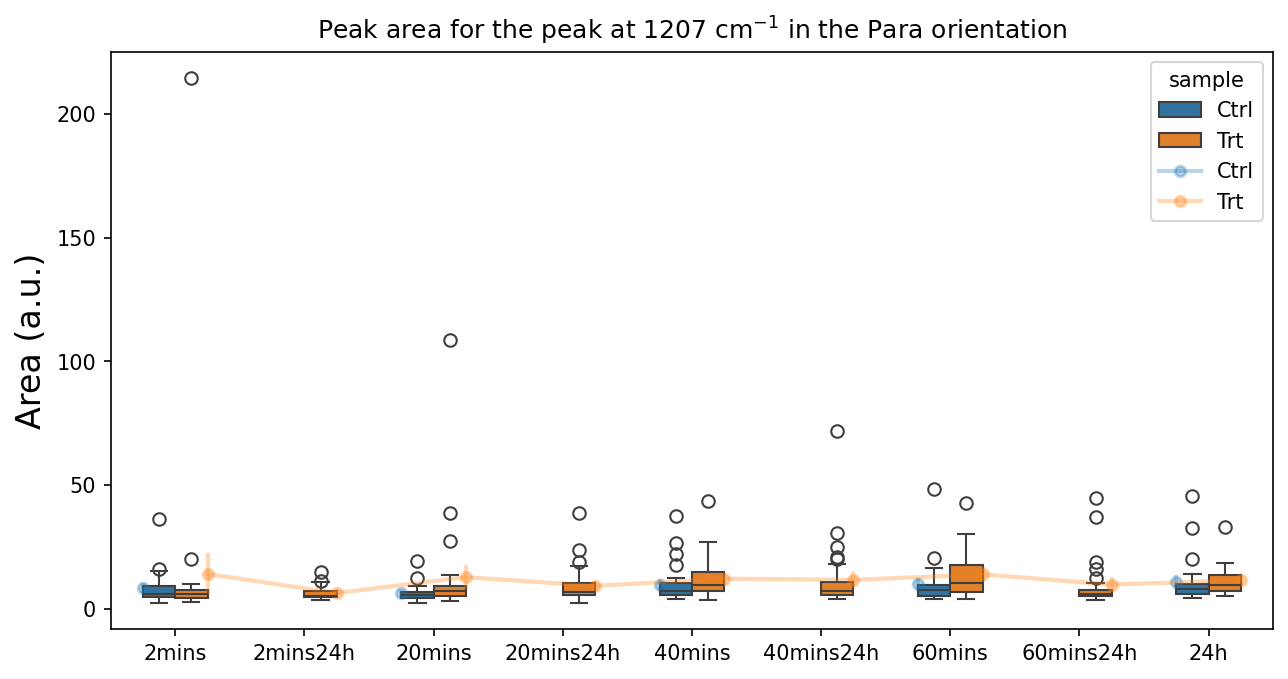

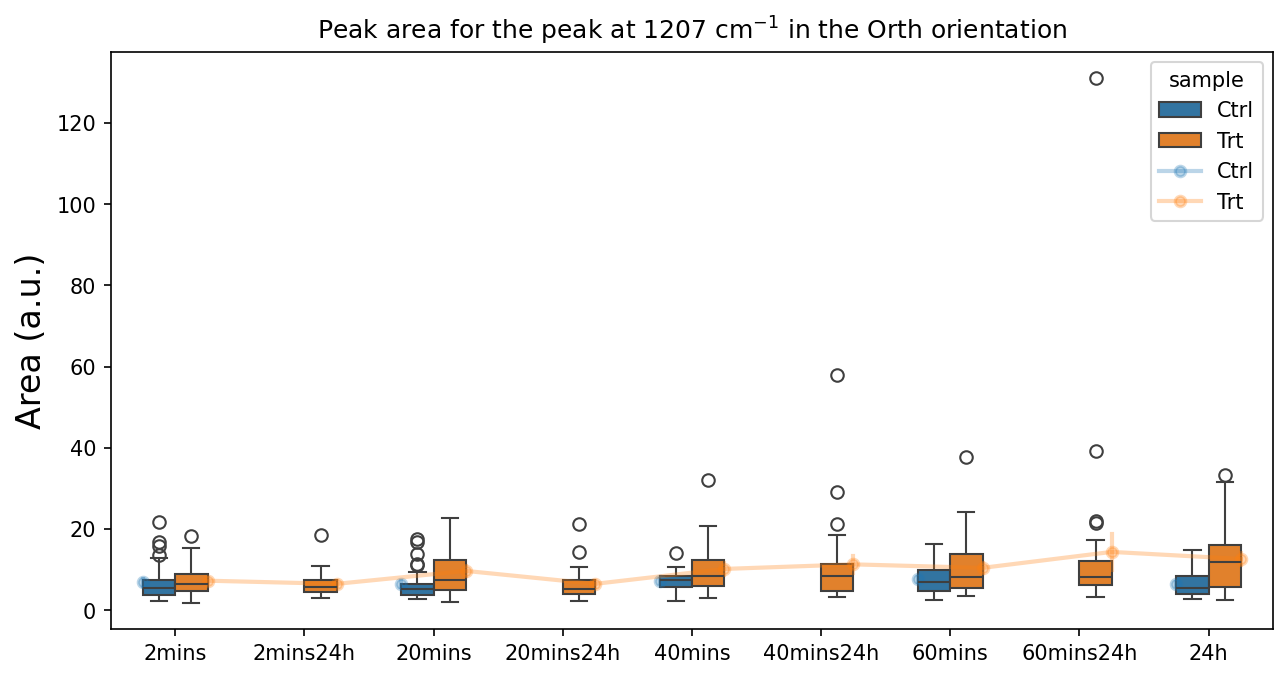

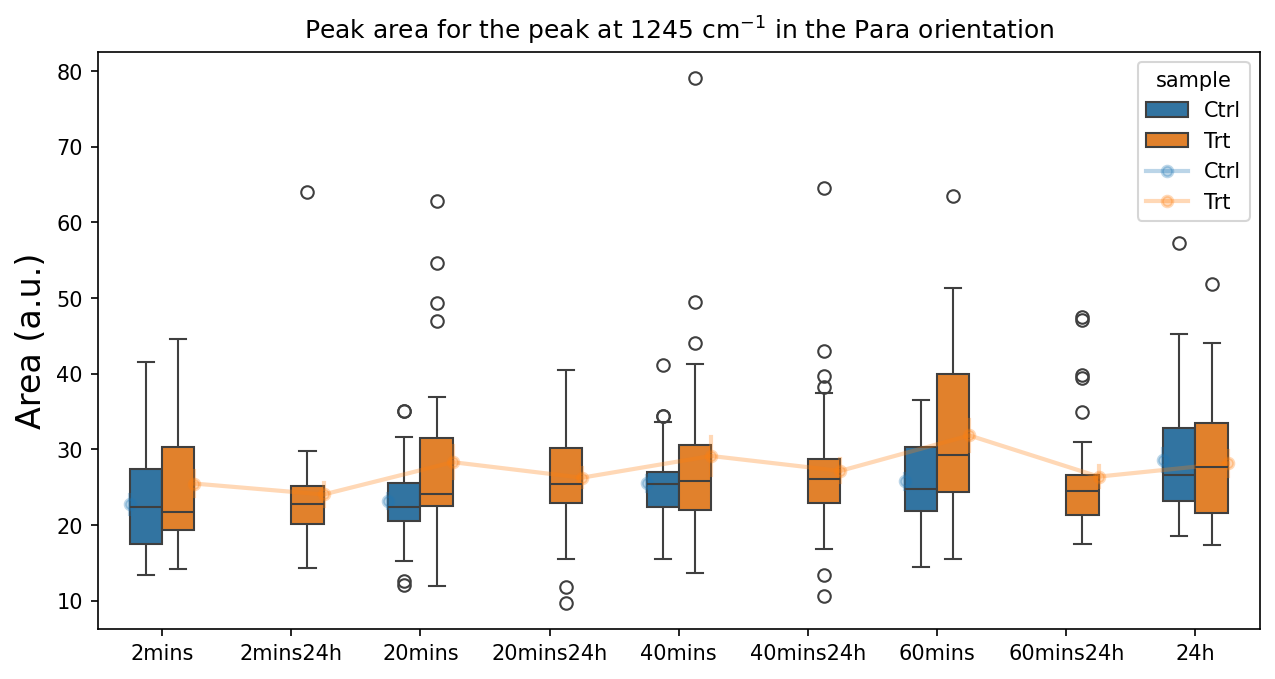

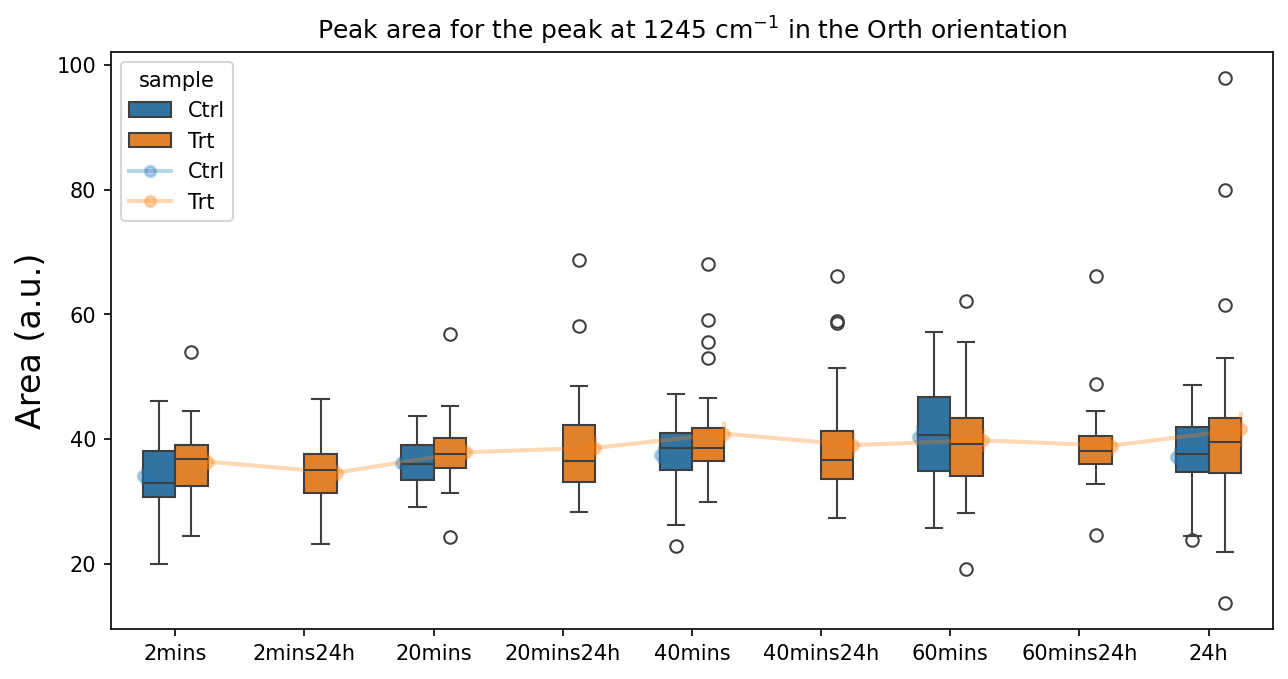

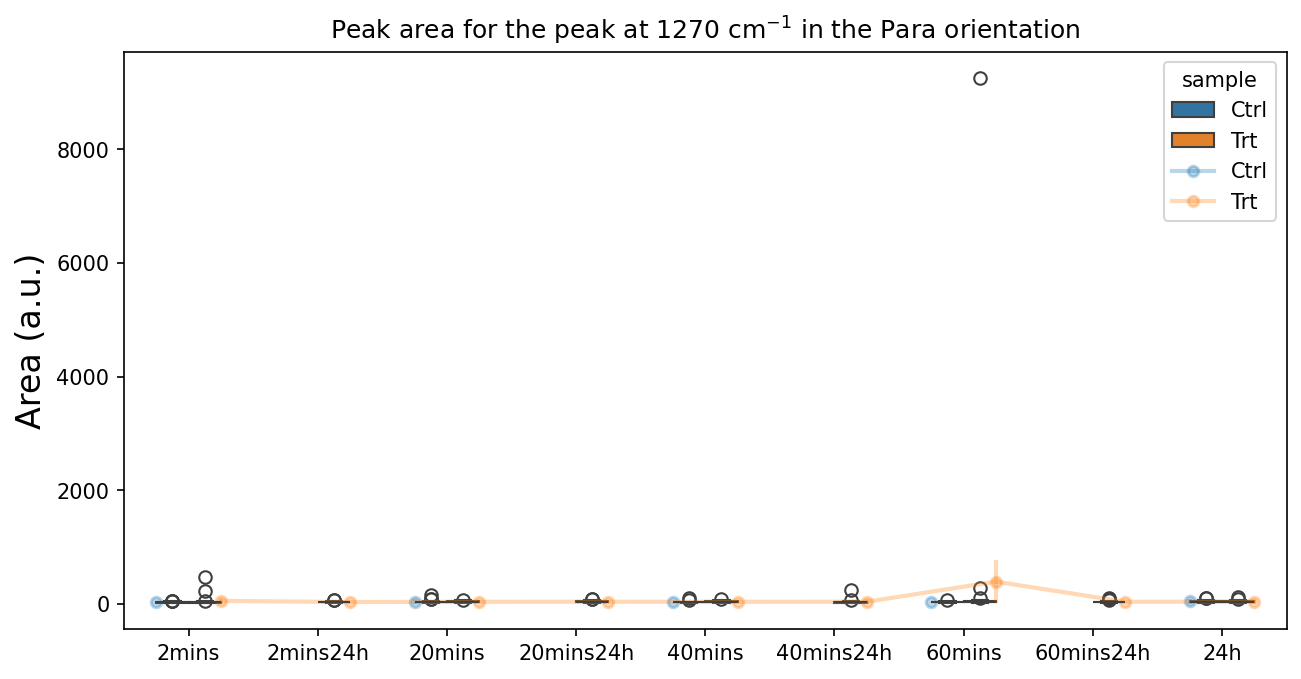

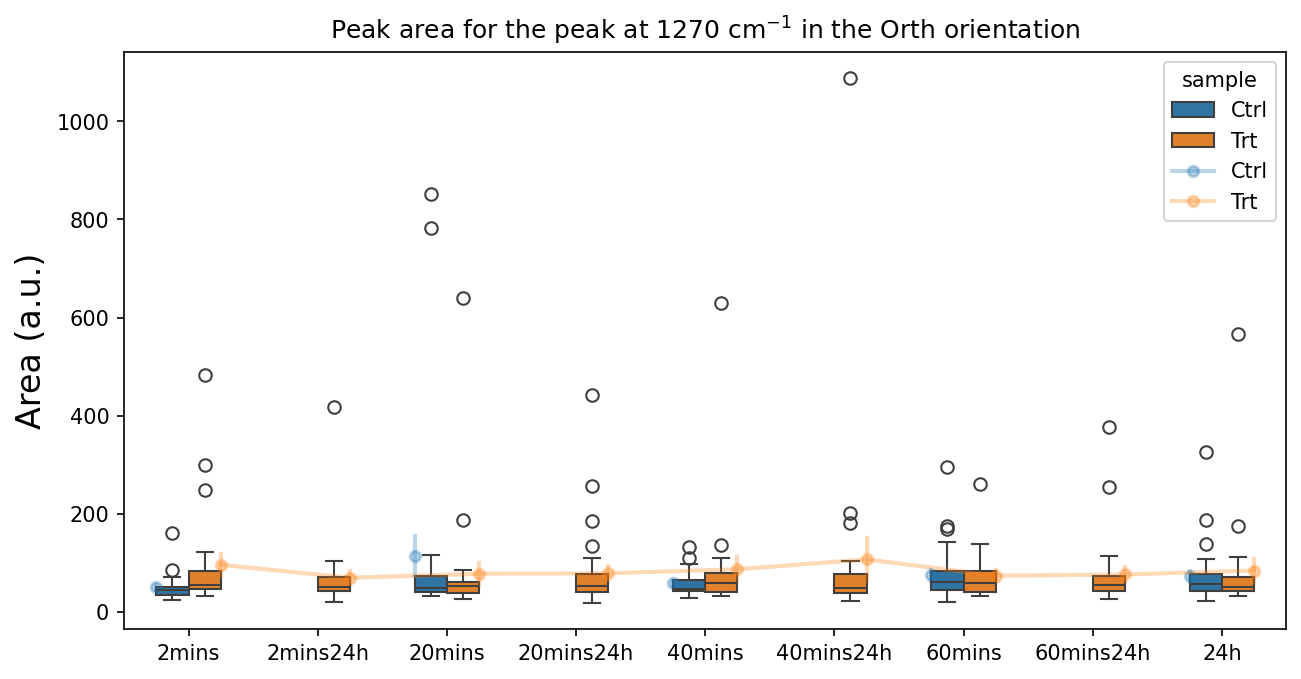

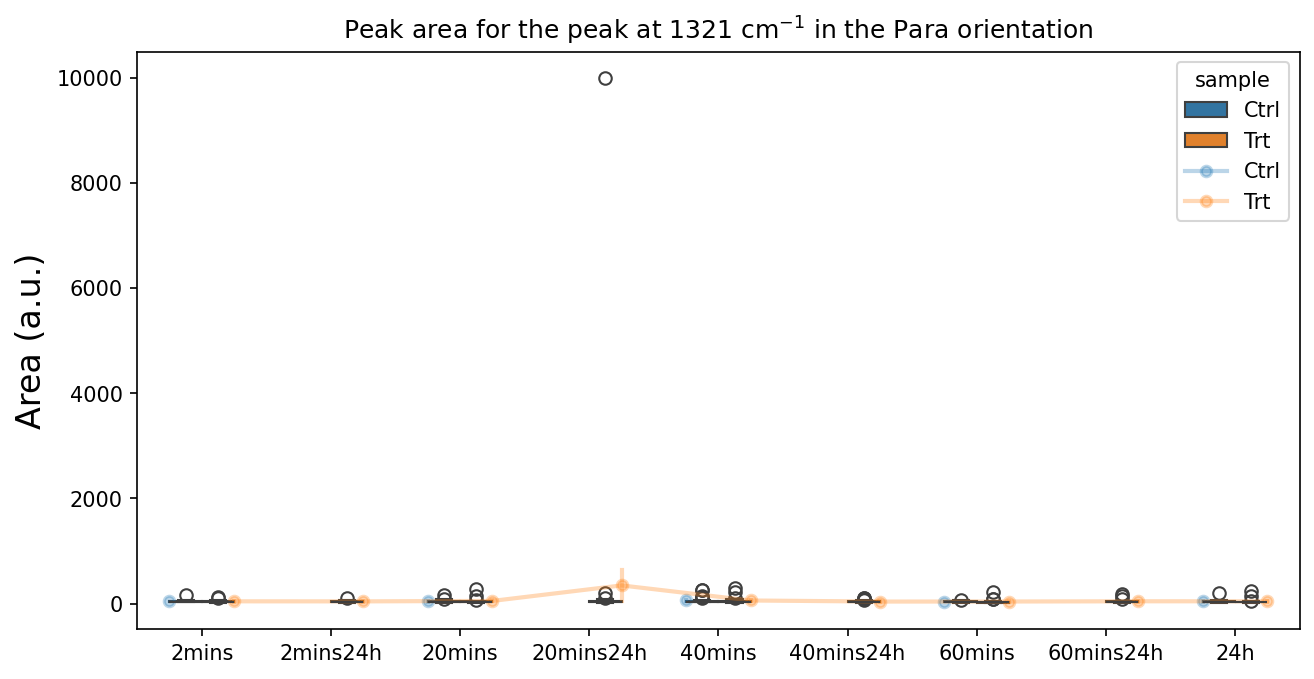

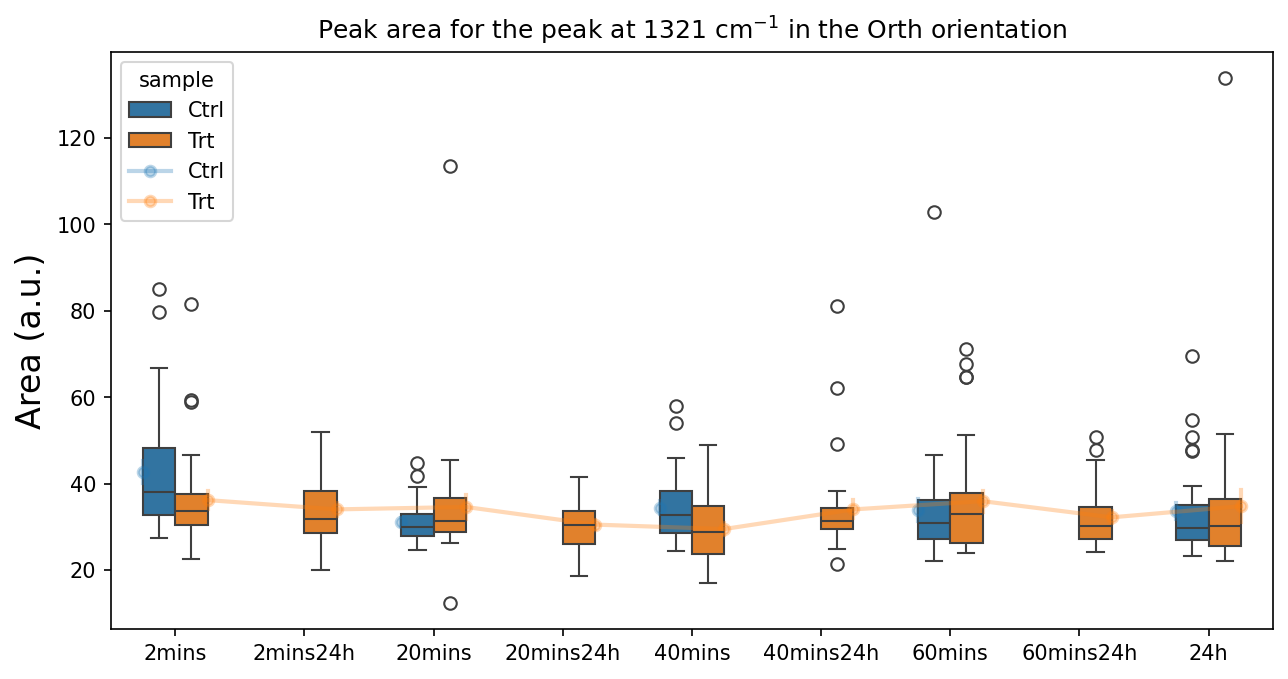

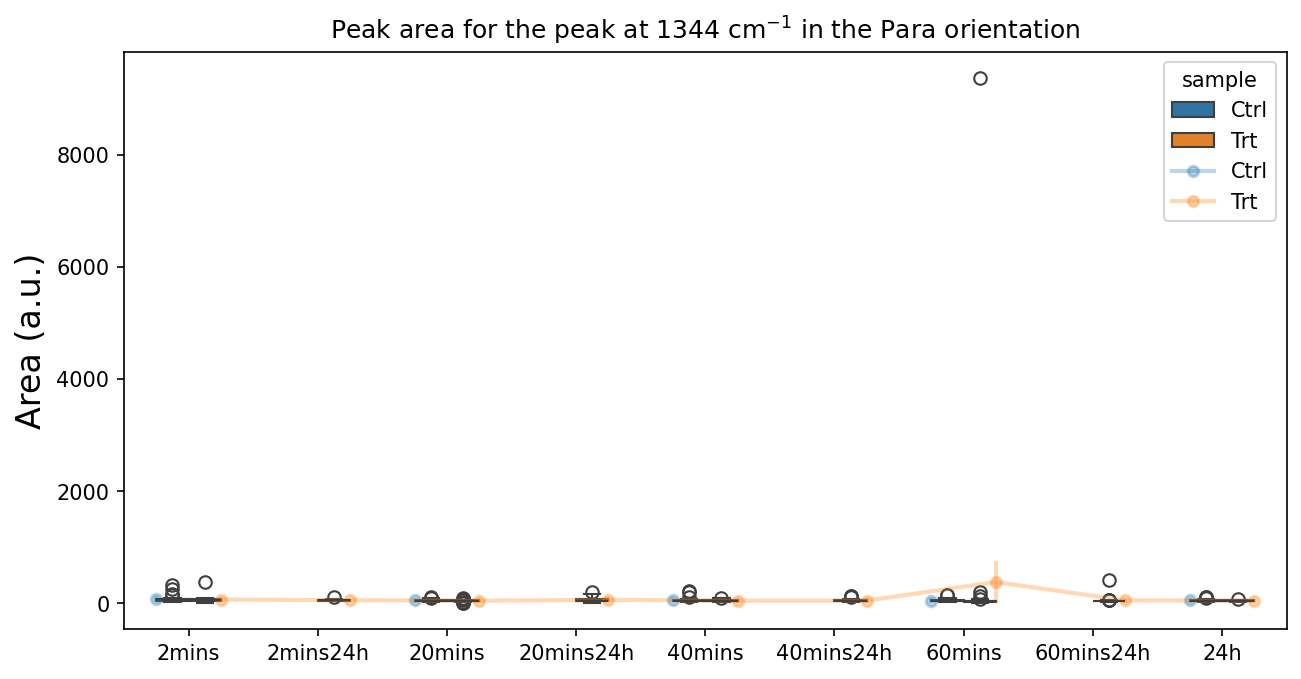

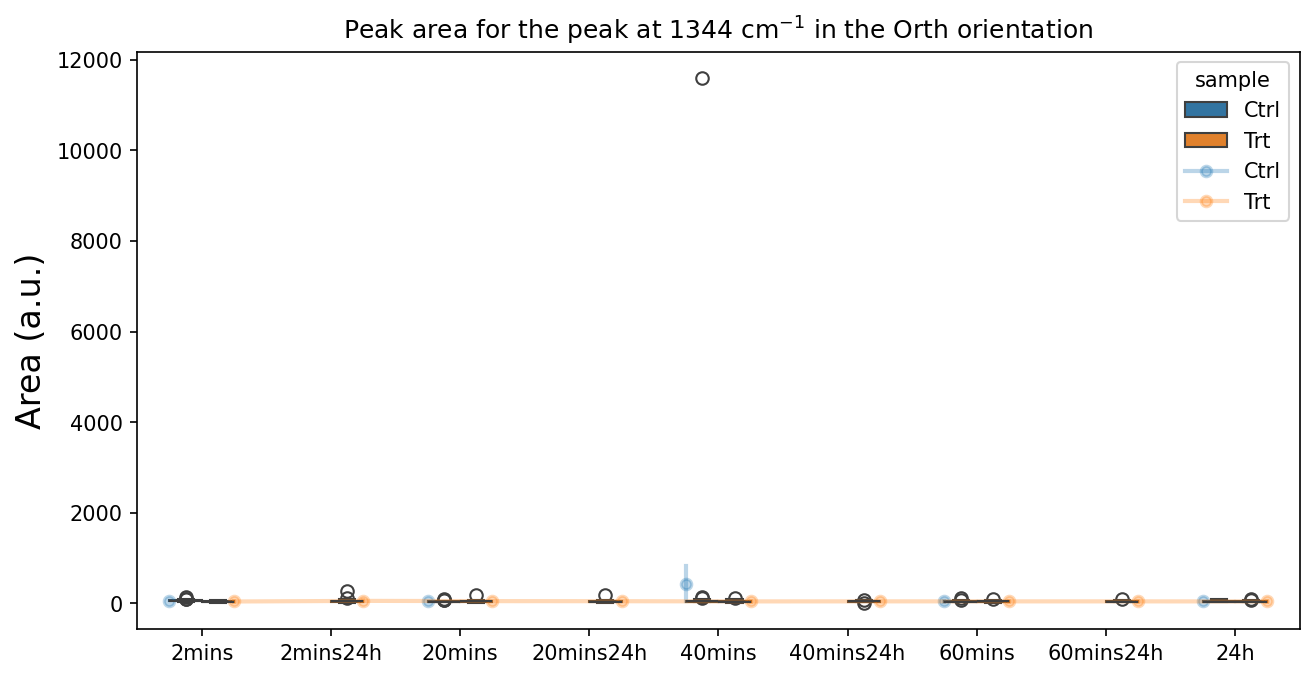

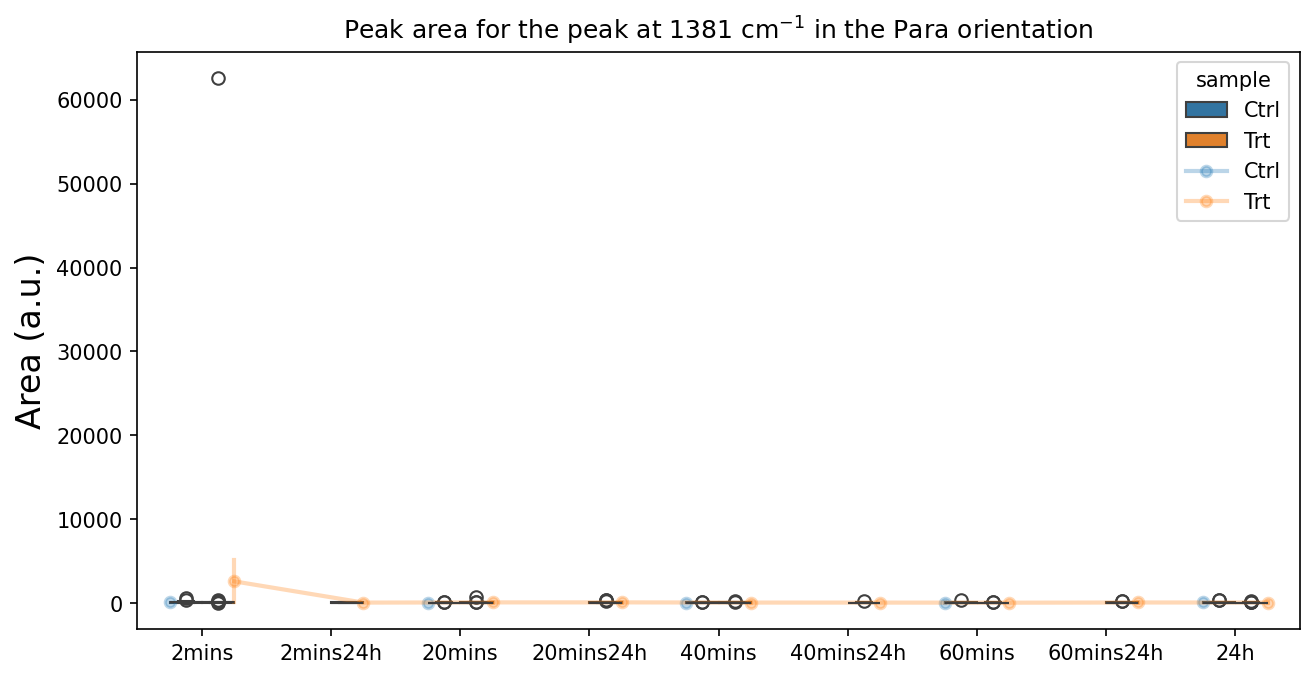

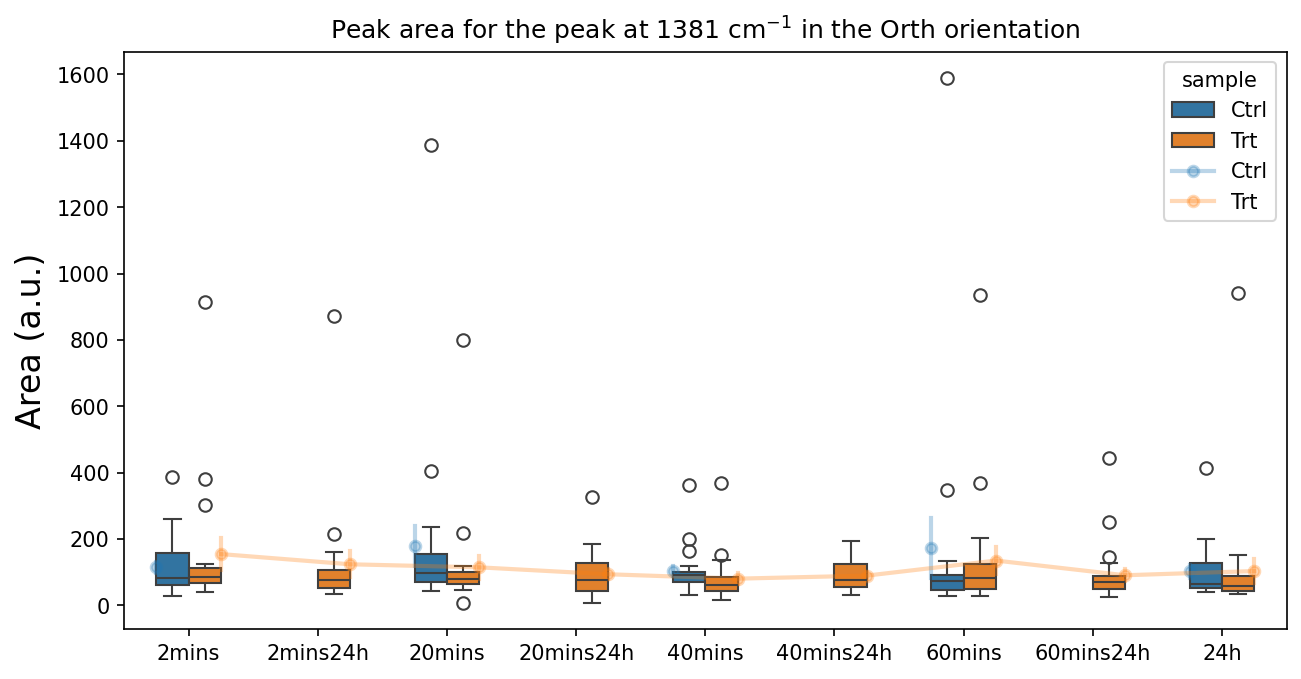

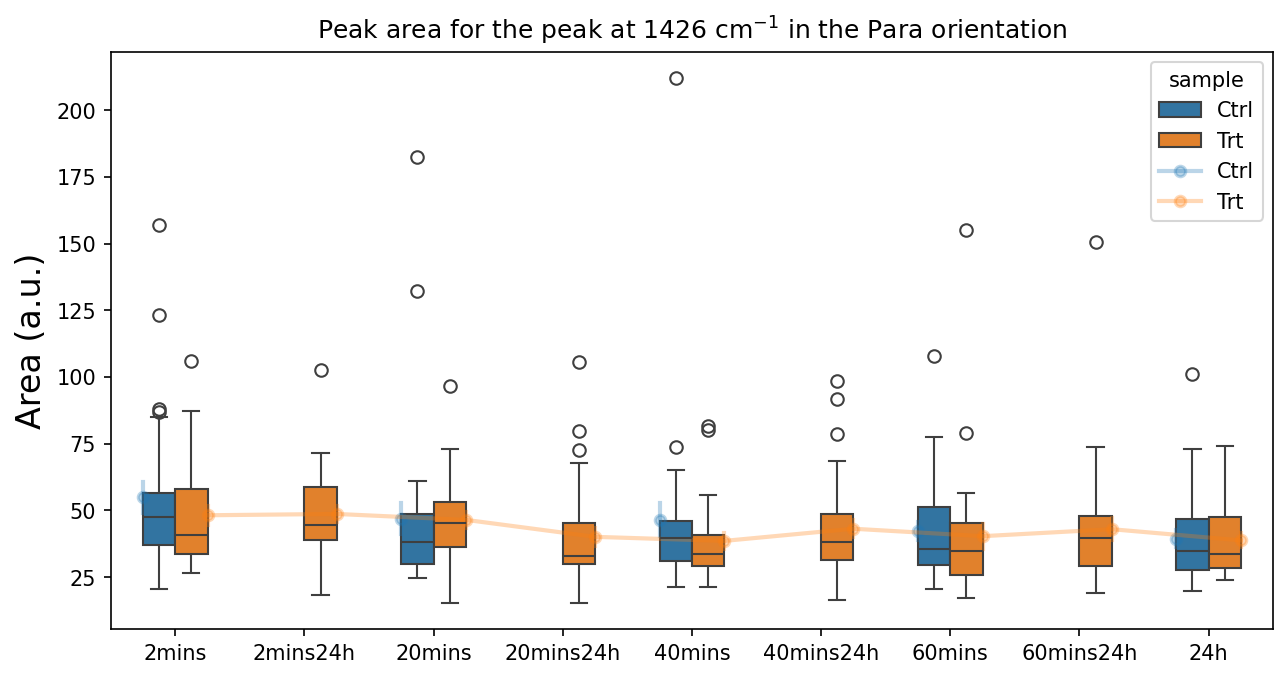

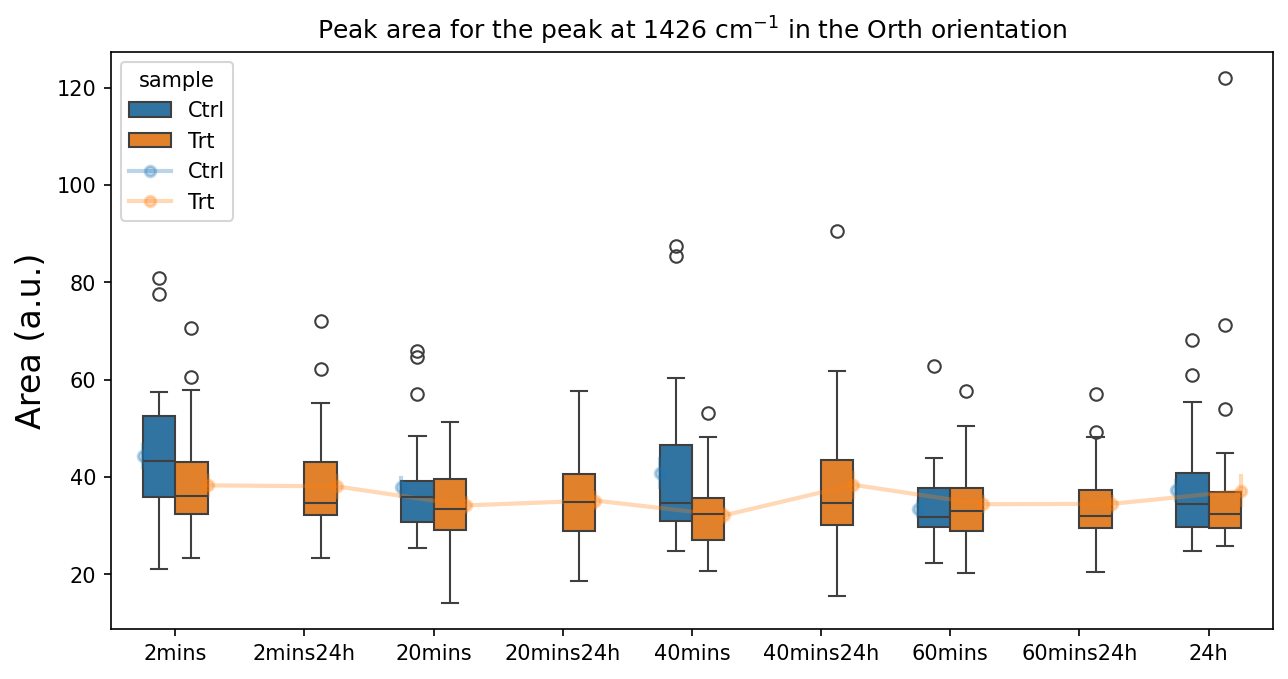

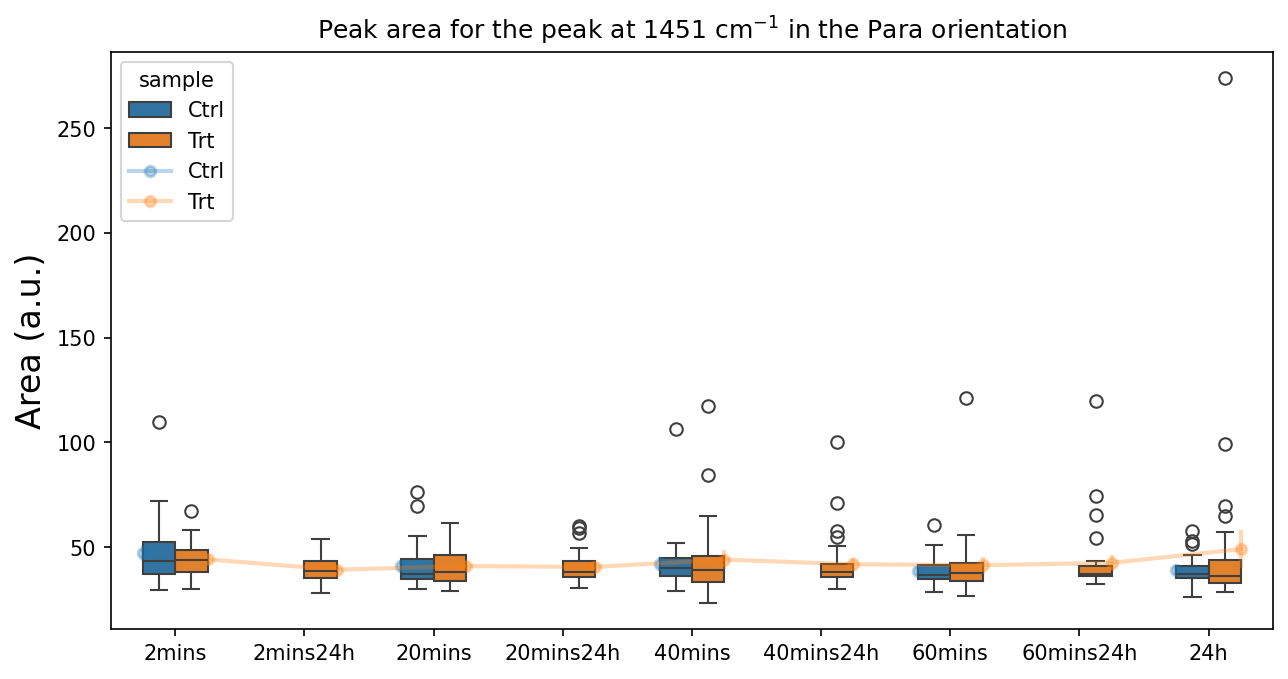

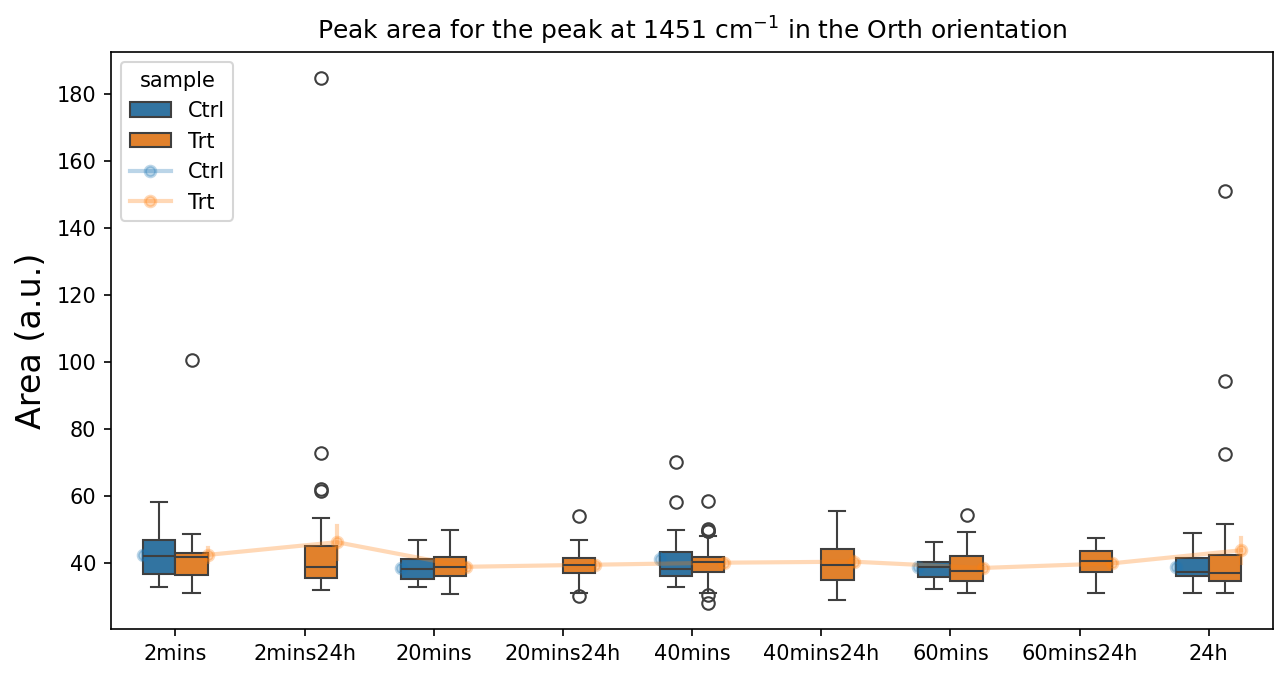

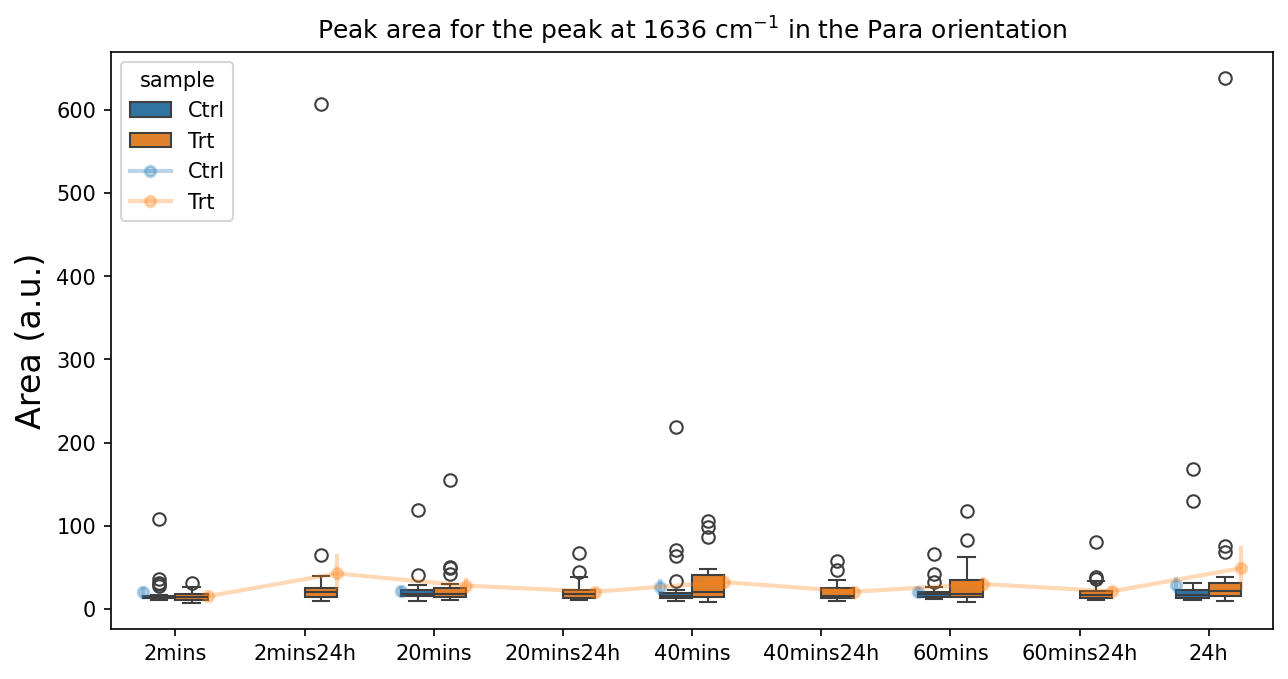

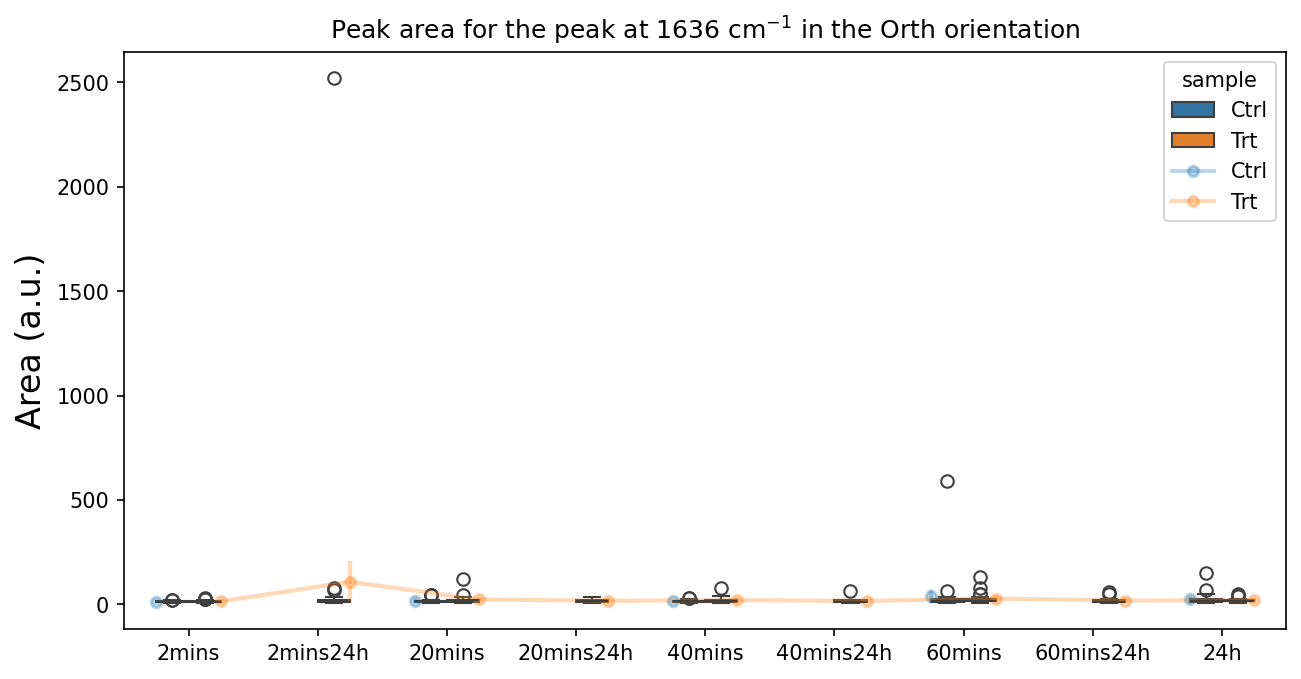

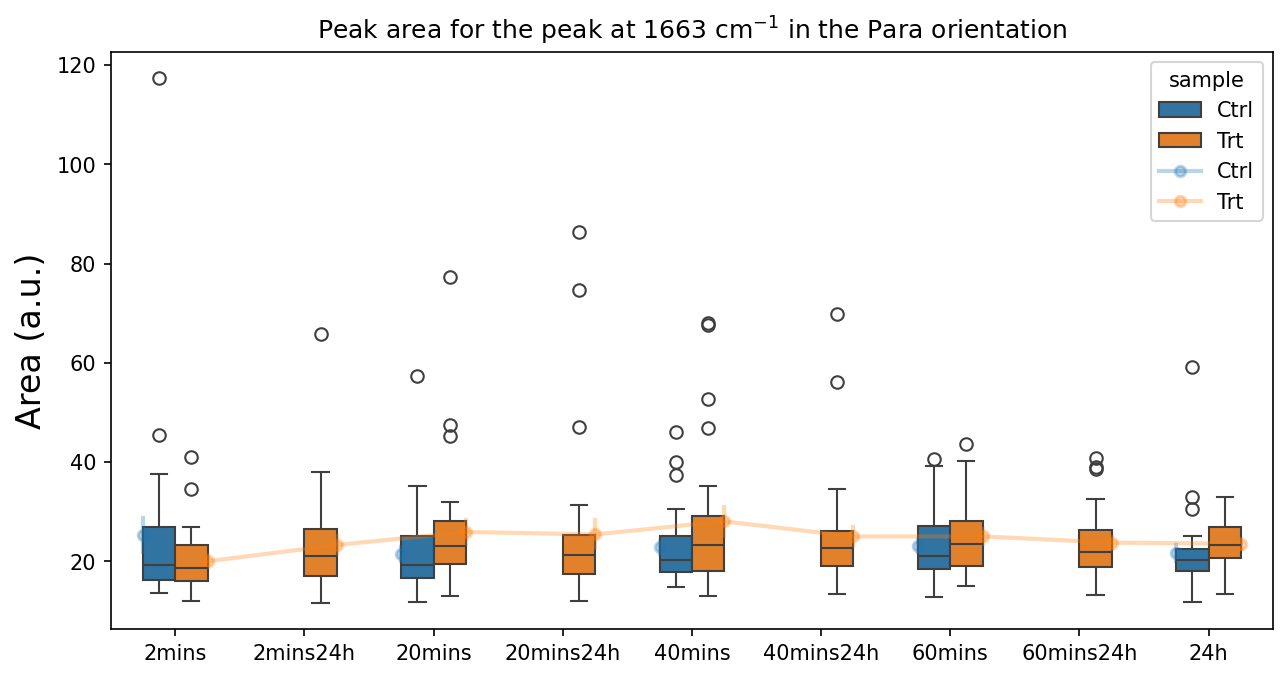

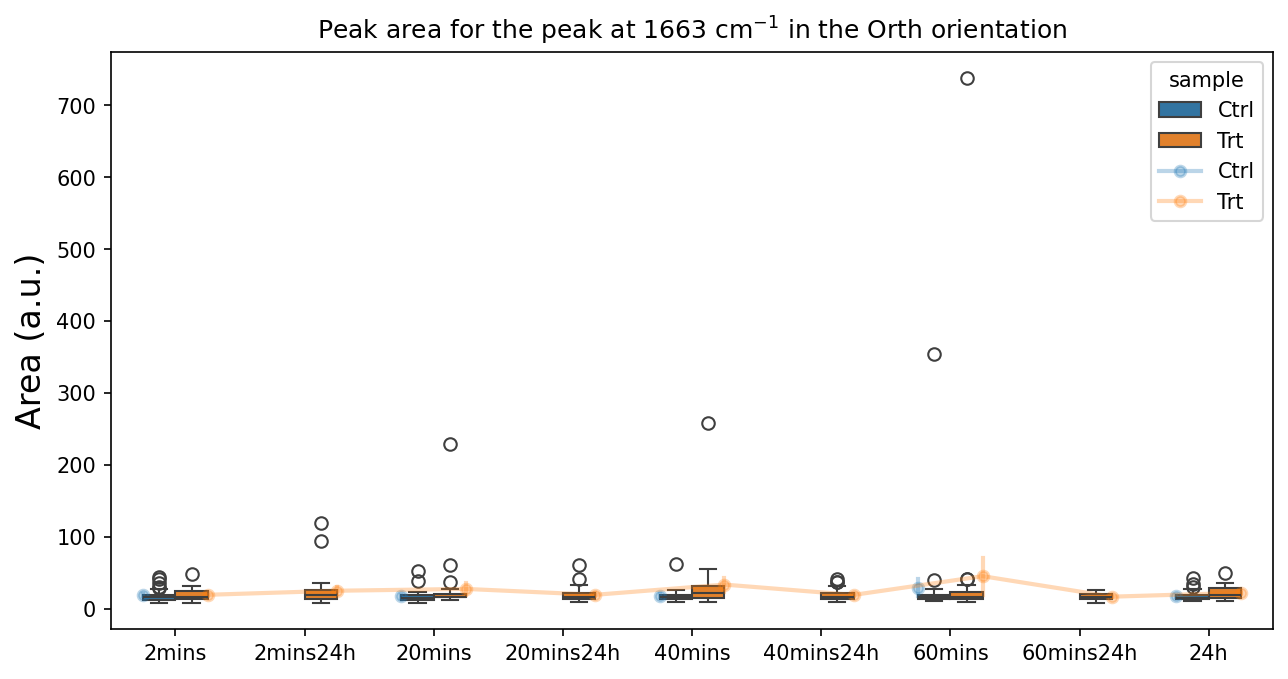

In [ ]:
for p in peak_positions:
    for j, tp in enumerate(['Para', 'Orth']):
        plt.figure(figsize = (10, 5), dpi = 150);
        dtt = result_df[(result_df['orient'].str.contains(tp)) & 
                                    (result_df['peak_pos'] == p) &
                                    (result_df['area']<= 100) #&
                                    #(result_df[''])
                                    ]
                #plt.figure(figsize = (15, 9), dpi = 150);
        sns.boxplot(
                    data = dtt,
                        x = 'trt_time',
                        y = 'area',
                        hue = 'sample',
                        order = ['2mins','2mins24h','20mins', '20mins24h','40mins', '40mins24h',  '60mins', 
                            '60mins24h', '24h'],
                            width = .5,
                           #alpha = .5
                    );
        sns.pointplot(
                    data = dtt,
                        x = 'trt_time',
                        y = 'area',
                        hue = 'sample',
                        order = ['2mins','2mins24h','20mins', '20mins24h','40mins', '40mins24h',  '60mins', 
                            '60mins24h', '24h'],
                            dodge = .5, linewidth = 2,
                            #marker_kws={'edgecolor': 'gray', 'linewidth': 1},
                           alpha = .3,
                           errorbar='se'
                    );
        plt.title(f'Peak area for the peak at {p} cm$^{{-1}}$ in the {tp} orientation')
        plt.ylabel('Area (a.u.)', fontsize = 16)
        plt.xlabel('')

In [141]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
for p in peak_positions:
    dtt = result_df[(result_df['orient'].str.contains('Orth')) & 
                                    (result_df['peak_pos'] == p) #&
                                    #(result_df['area']<= 100)
                                    ]
    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=dtt['area'],
                            groups=dtt['sample'],
                            alpha=0.05)

    #display results
    print(f'Tukey HSD results for peak at {p} cm$^{-1}$ in the Parallel Orientation')
    print(tukey)
    print('*******************************************************************************')

Tukey HSD results for peak at 857 cm$^-1$ in the Parallel Orientation
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Ctrl    Trt   4.8435 0.1107 -1.1118 10.7988  False
----------------------------------------------------
*******************************************************************************
Tukey HSD results for peak at 921 cm$^-1$ in the Parallel Orientation
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper   reject
-----------------------------------------------------
  Ctrl    Trt   89.452 0.0611 -4.2016 183.1055  False
-----------------------------------------------------
*******************************************************************************
Tukey HSD results for peak at 940 cm$^-1$ in the Parallel Orientation
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  

In [62]:
fit_mean = result_df.groupby(['sample', 'trt_time', 'orient', 'peak_pos']).mean(numeric_only=True).reset_index()
fit_mean[fit_mean]

sample   trt_time orient  peak_pos      fit_pos       amp       fwhm  \
0     Ctrl     20mins   Orth       816   816.271744  0.477713  17.637239   
1     Ctrl     20mins   Orth       857   857.371105  1.044817  24.732490   
2     Ctrl     20mins   Orth       876   869.636035  0.800166  48.502113   
3     Ctrl     20mins   Orth       921   931.829312  1.040894  43.102532   
4     Ctrl     20mins   Orth       940   939.909825  1.518372  22.142293   
..     ...        ...    ...       ...          ...       ...        ...   
499    Trt  60mins24h   Para      1381  1380.639999  1.006521  78.969080   
500    Trt  60mins24h   Para      1426  1426.009176  0.867564  46.439438   
501    Trt  60mins24h   Para      1451  1450.422534  1.048991  38.113217   
502    Trt  60mins24h   Para      1636  1638.059460  0.413491  48.799765   
503    Trt  60mins24h   Para      1663  1663.886214  0.572016  39.348225   

          area  
0     9.019748  
1    27.517565  
2    42.369207  
3    86.034180  
4    35.774184  
..         ...  
499  85.305304  
500  42.961632  
501  42.530575  
502  21.181013  
503  23.756807  

[504 rows x 8 columns]

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

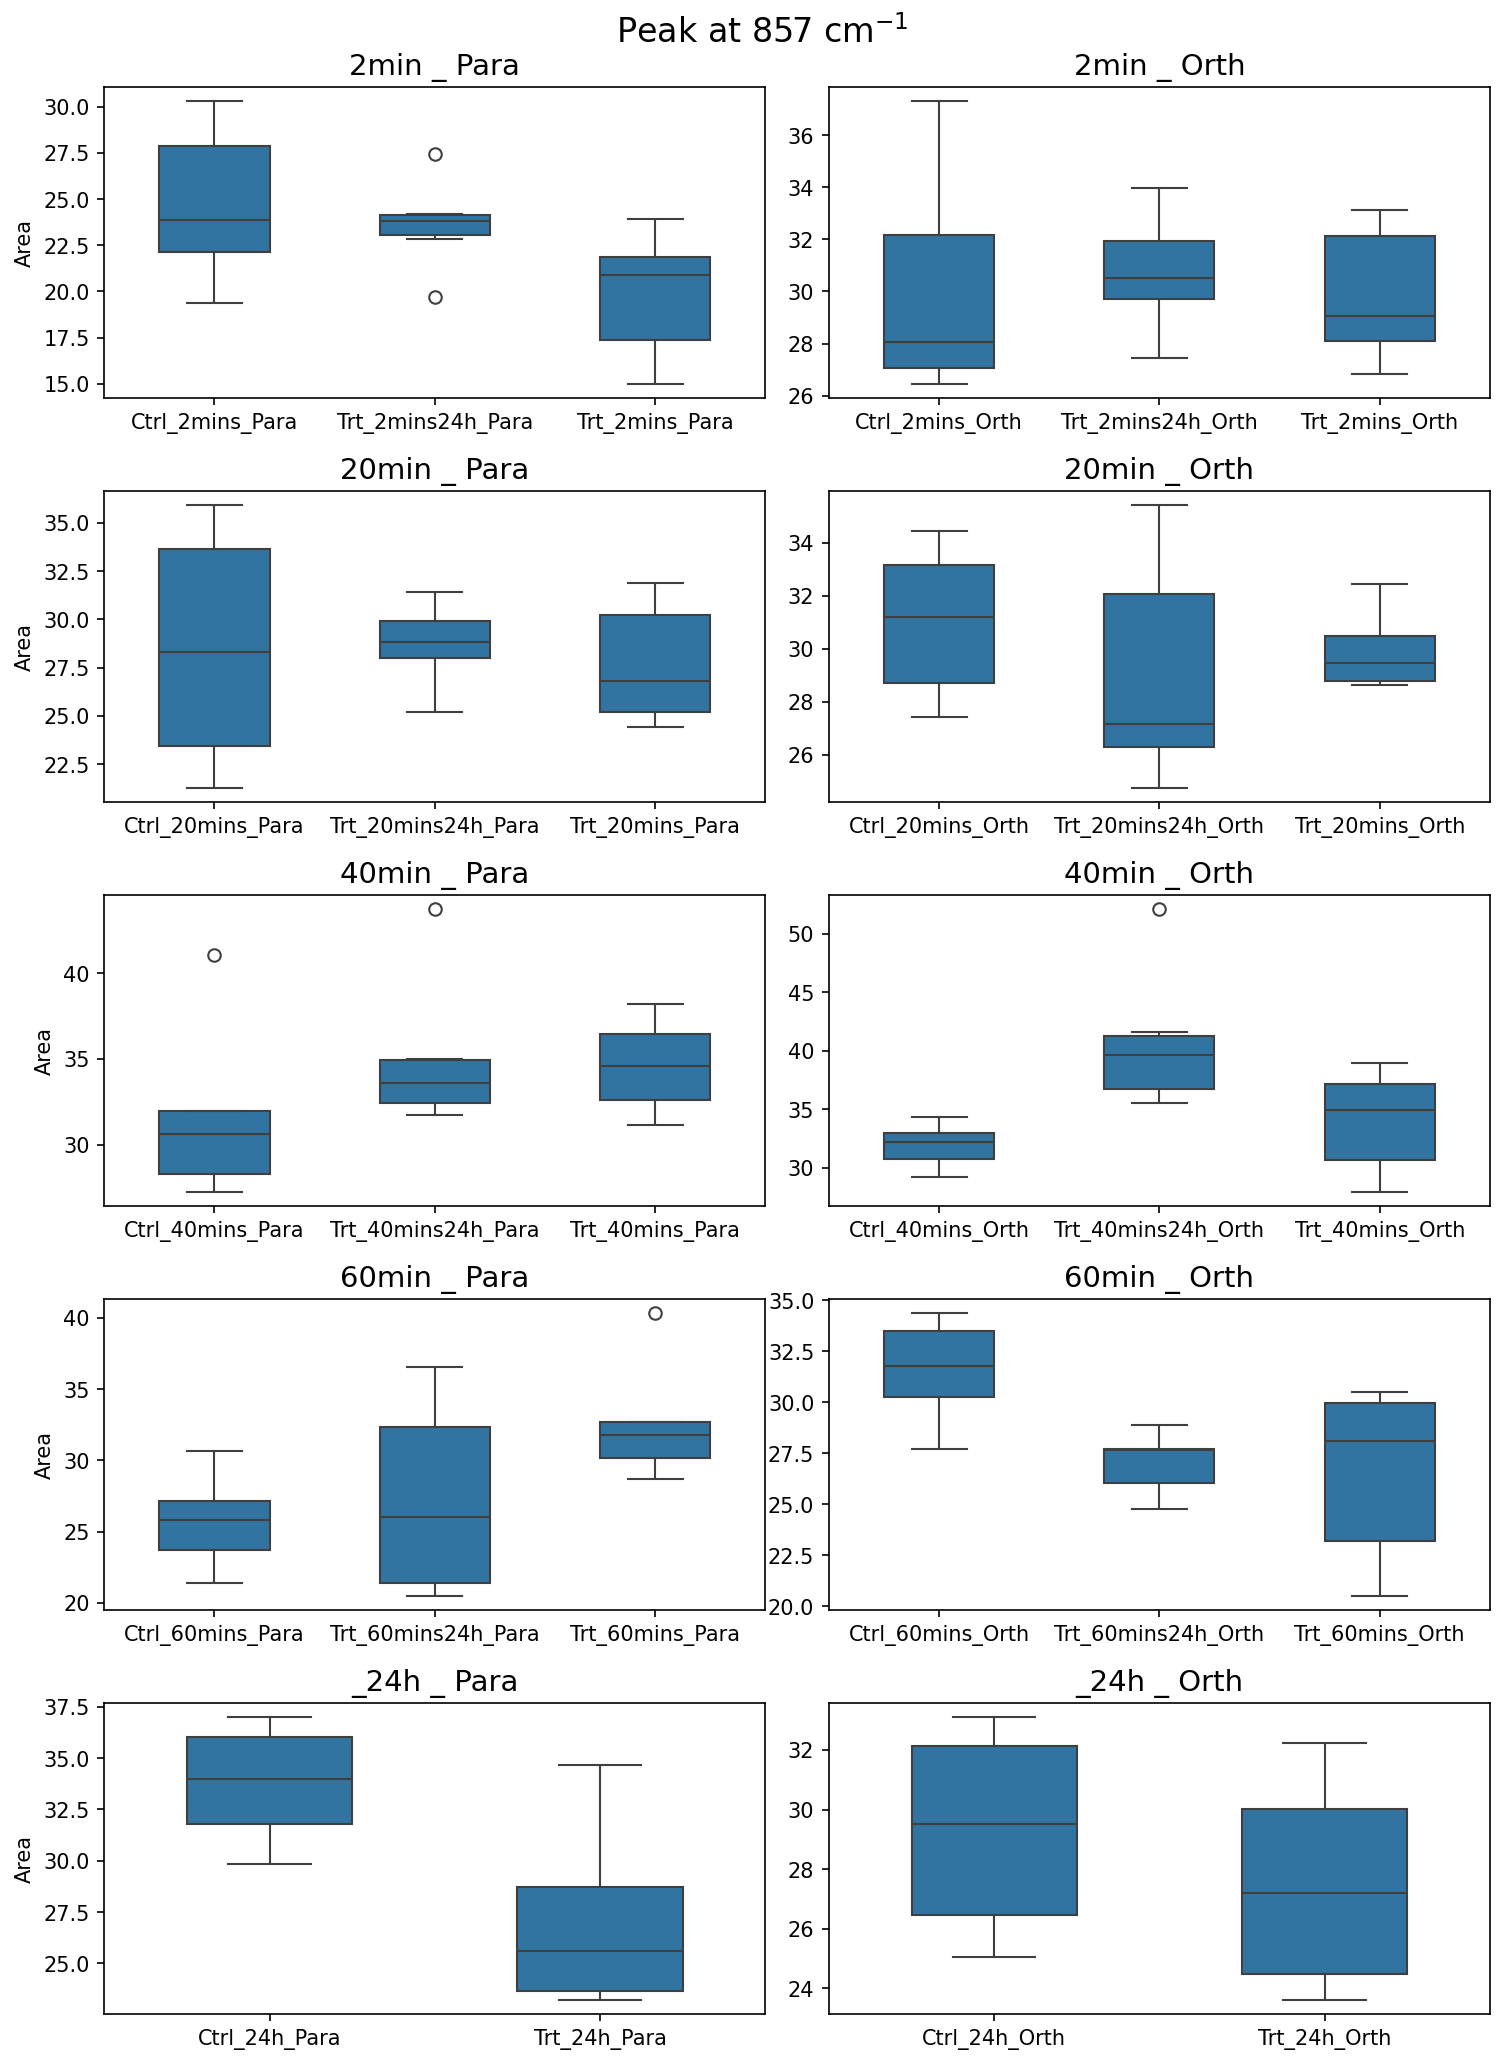

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

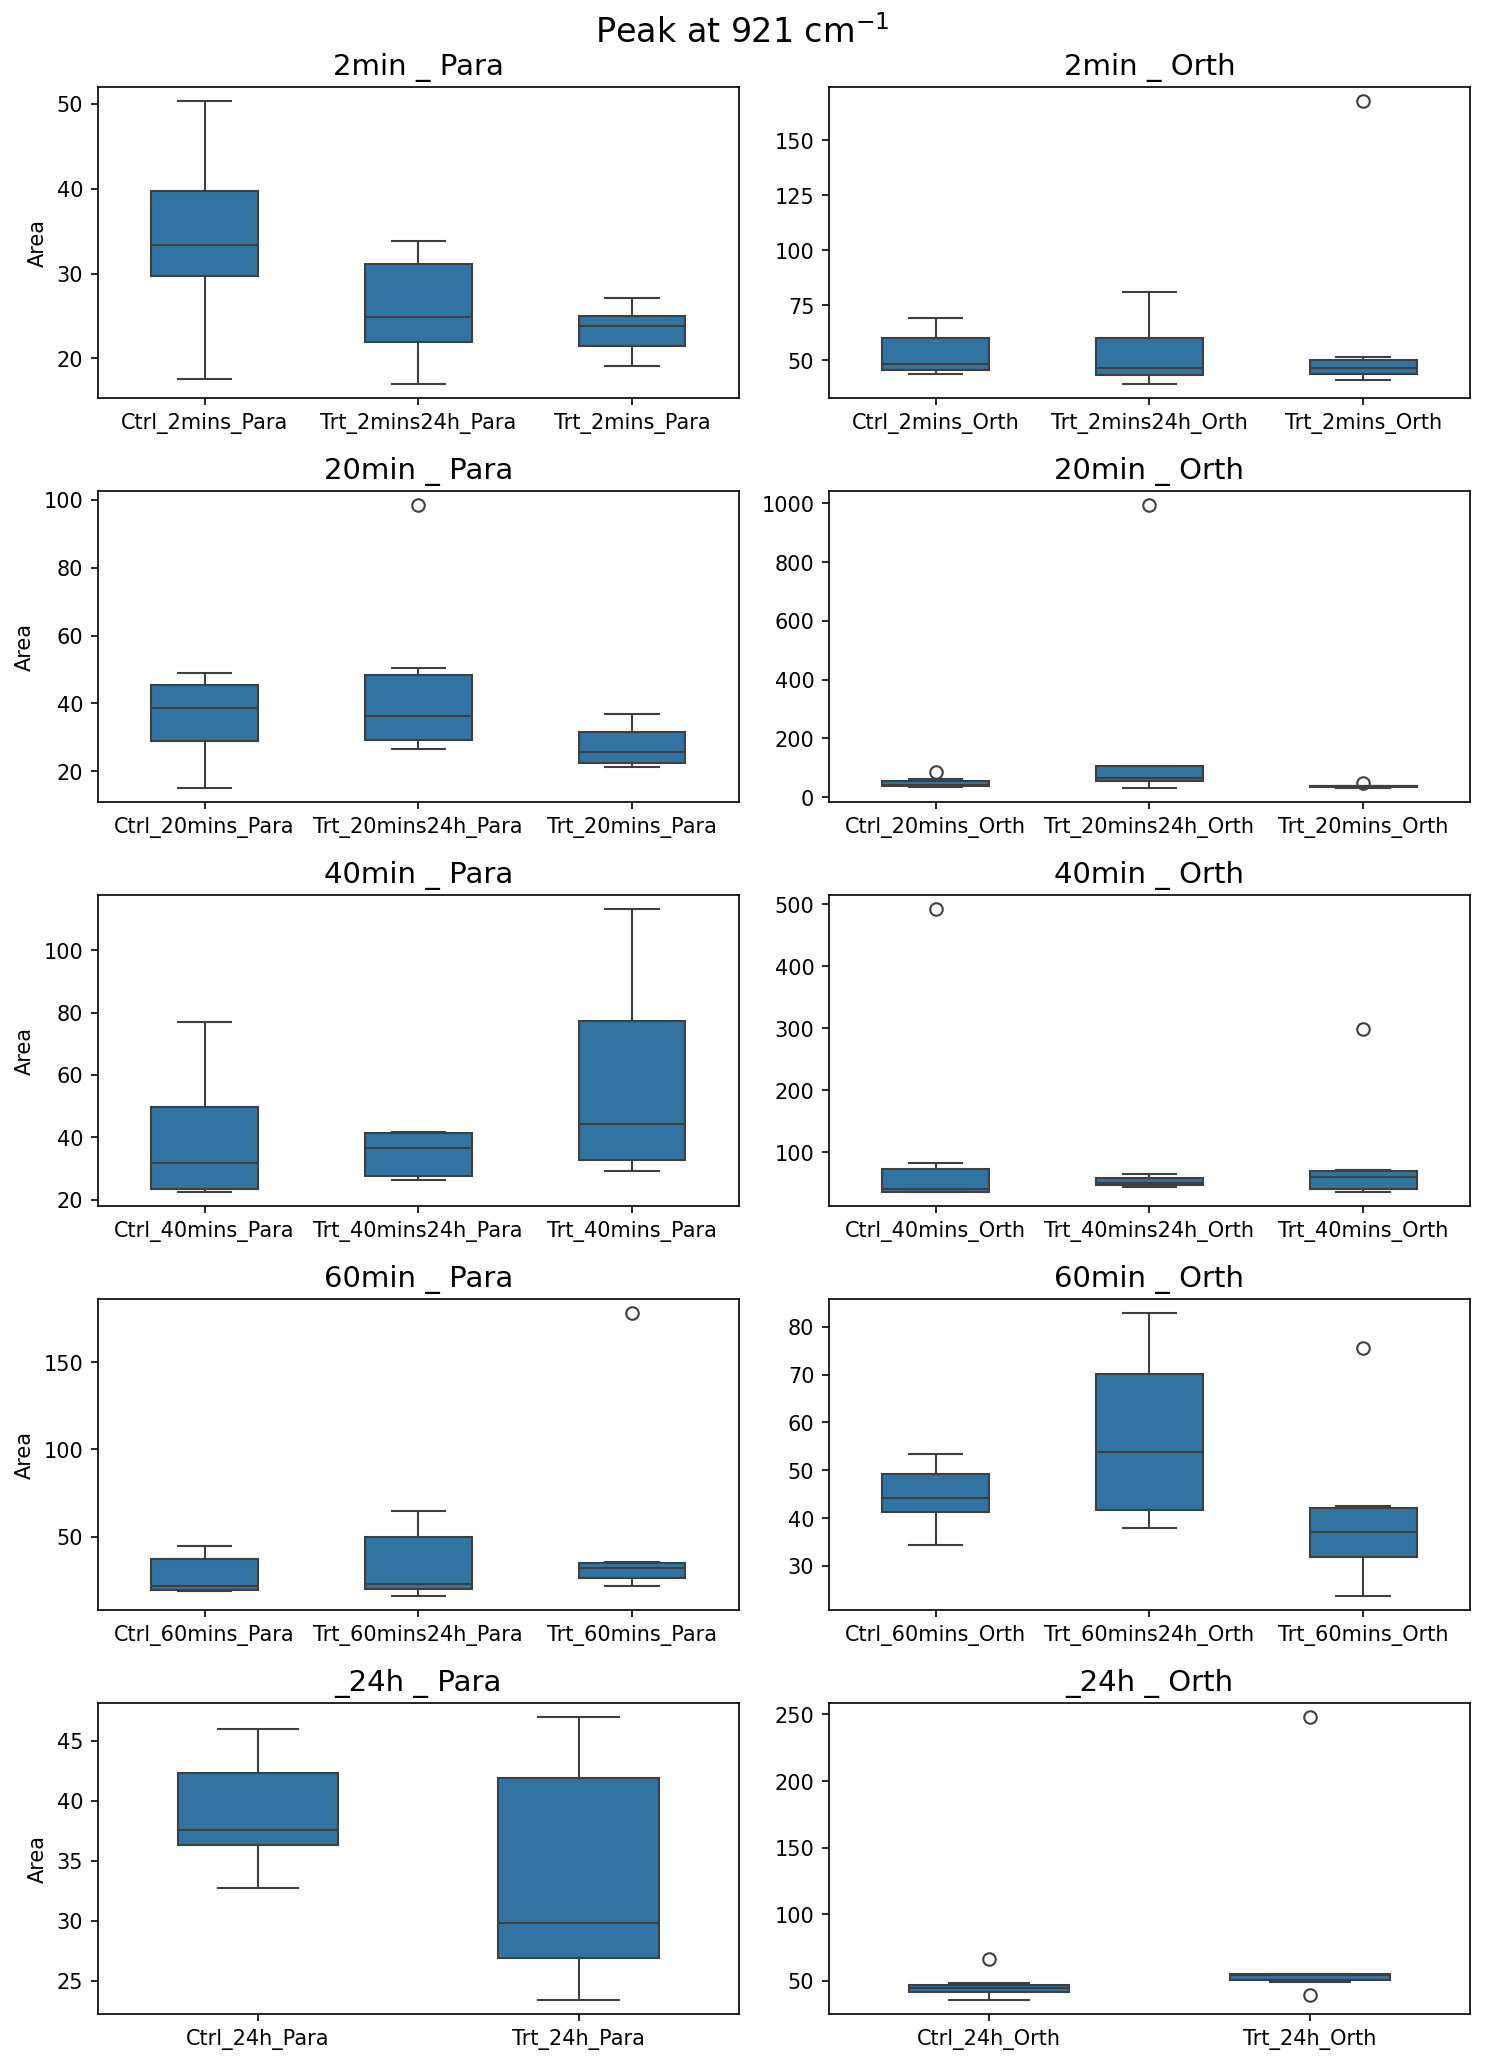

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

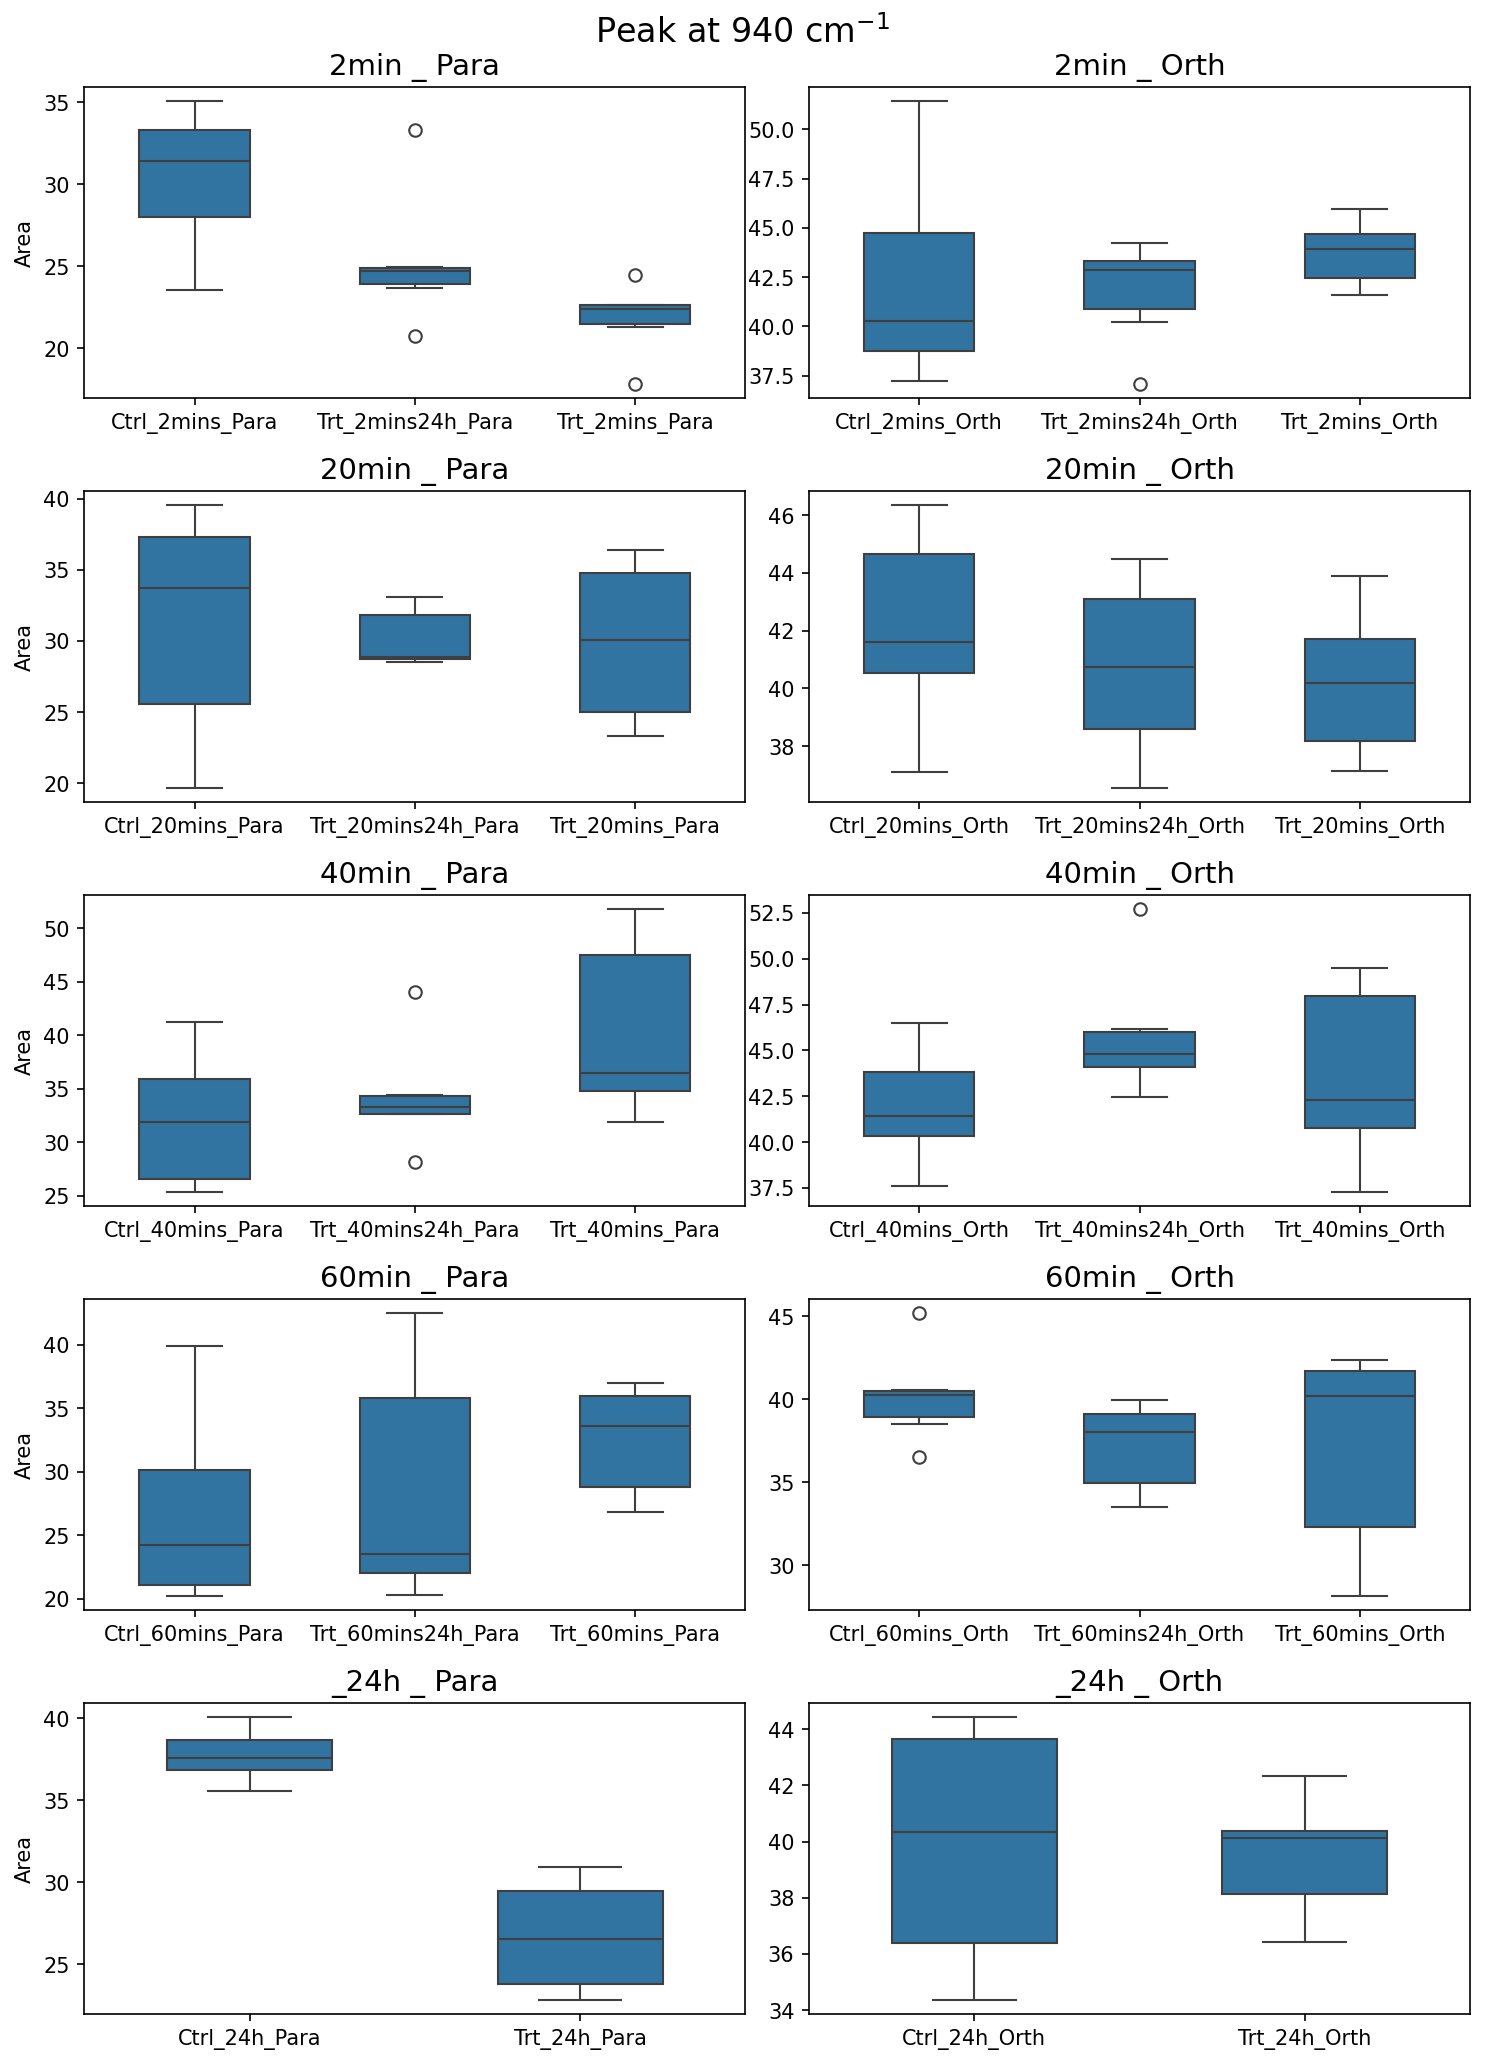

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

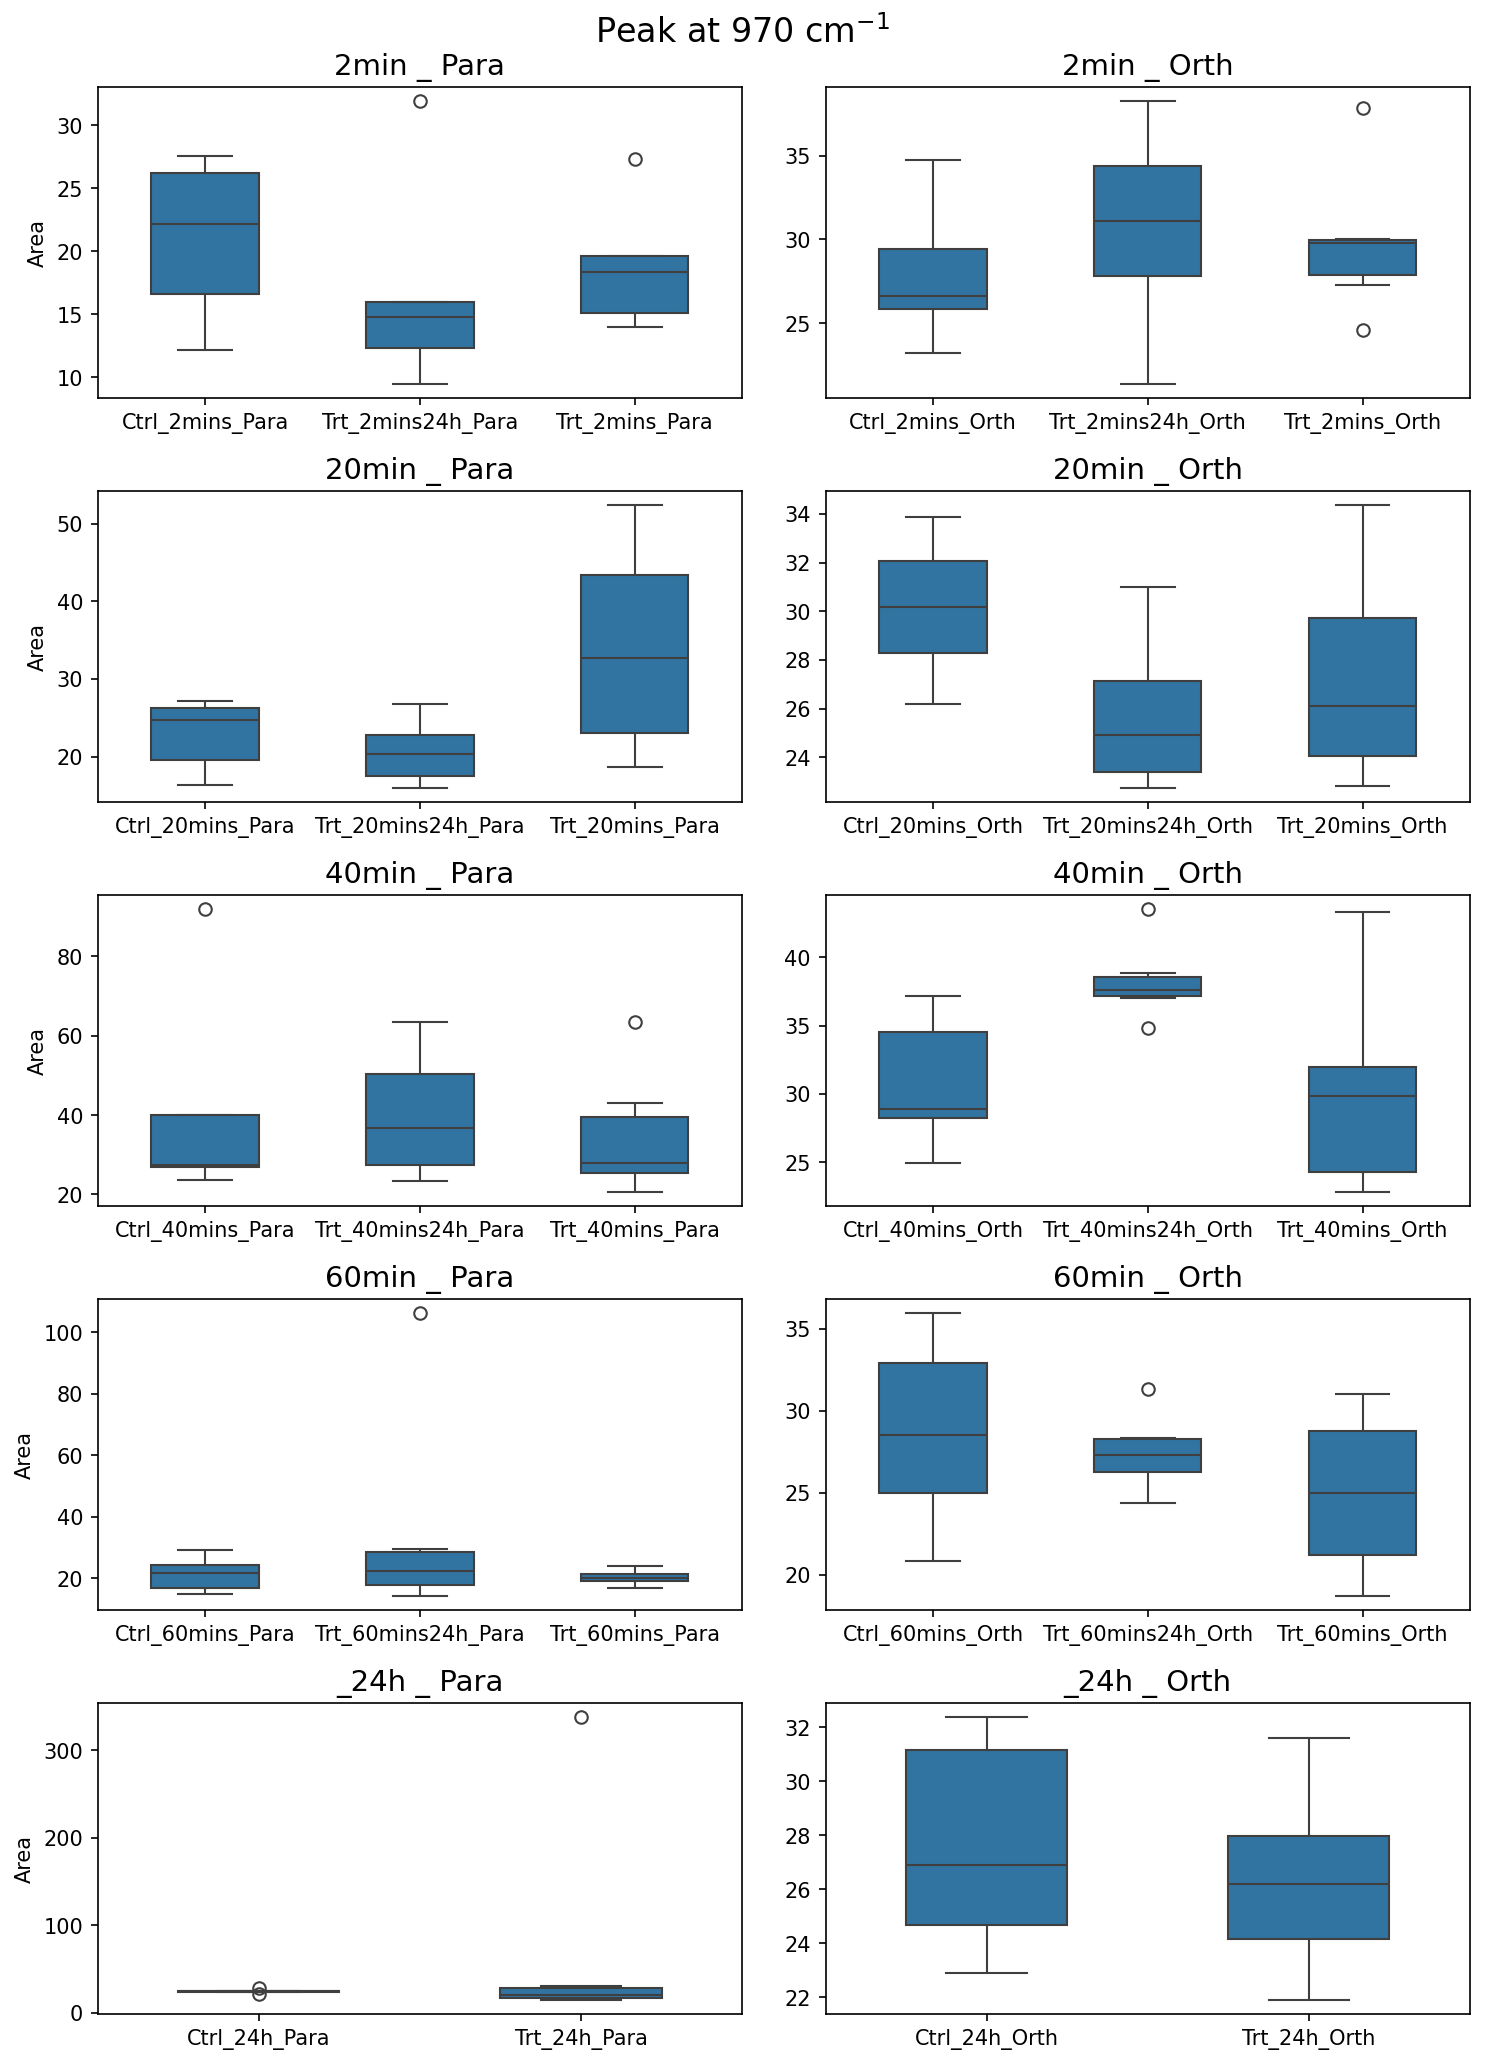

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

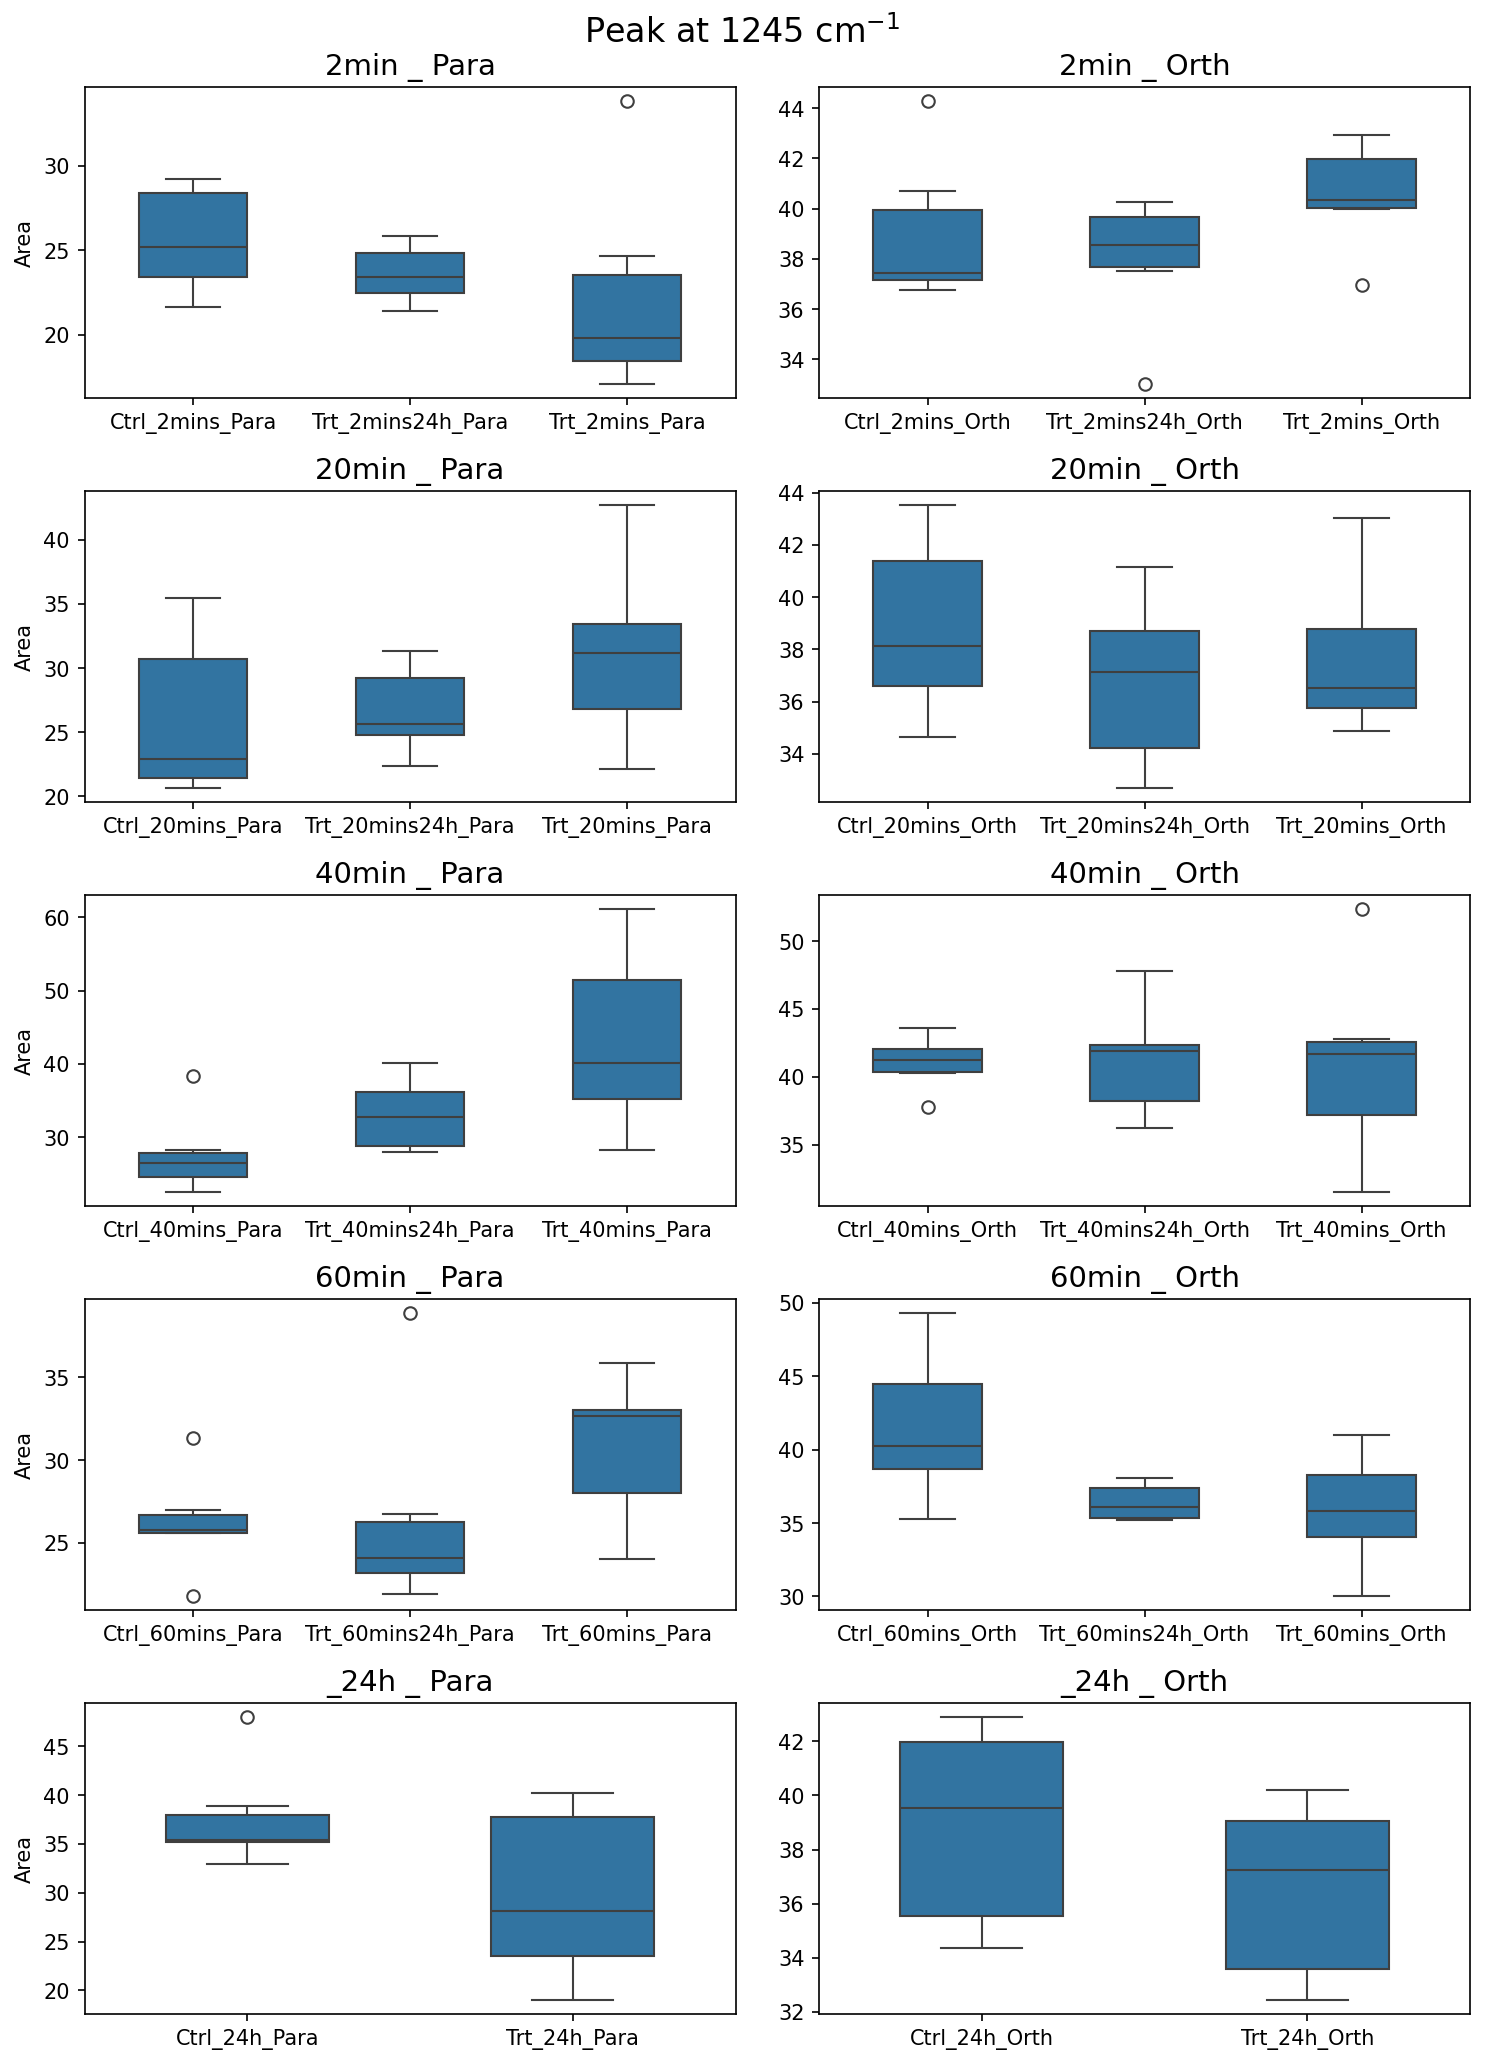

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

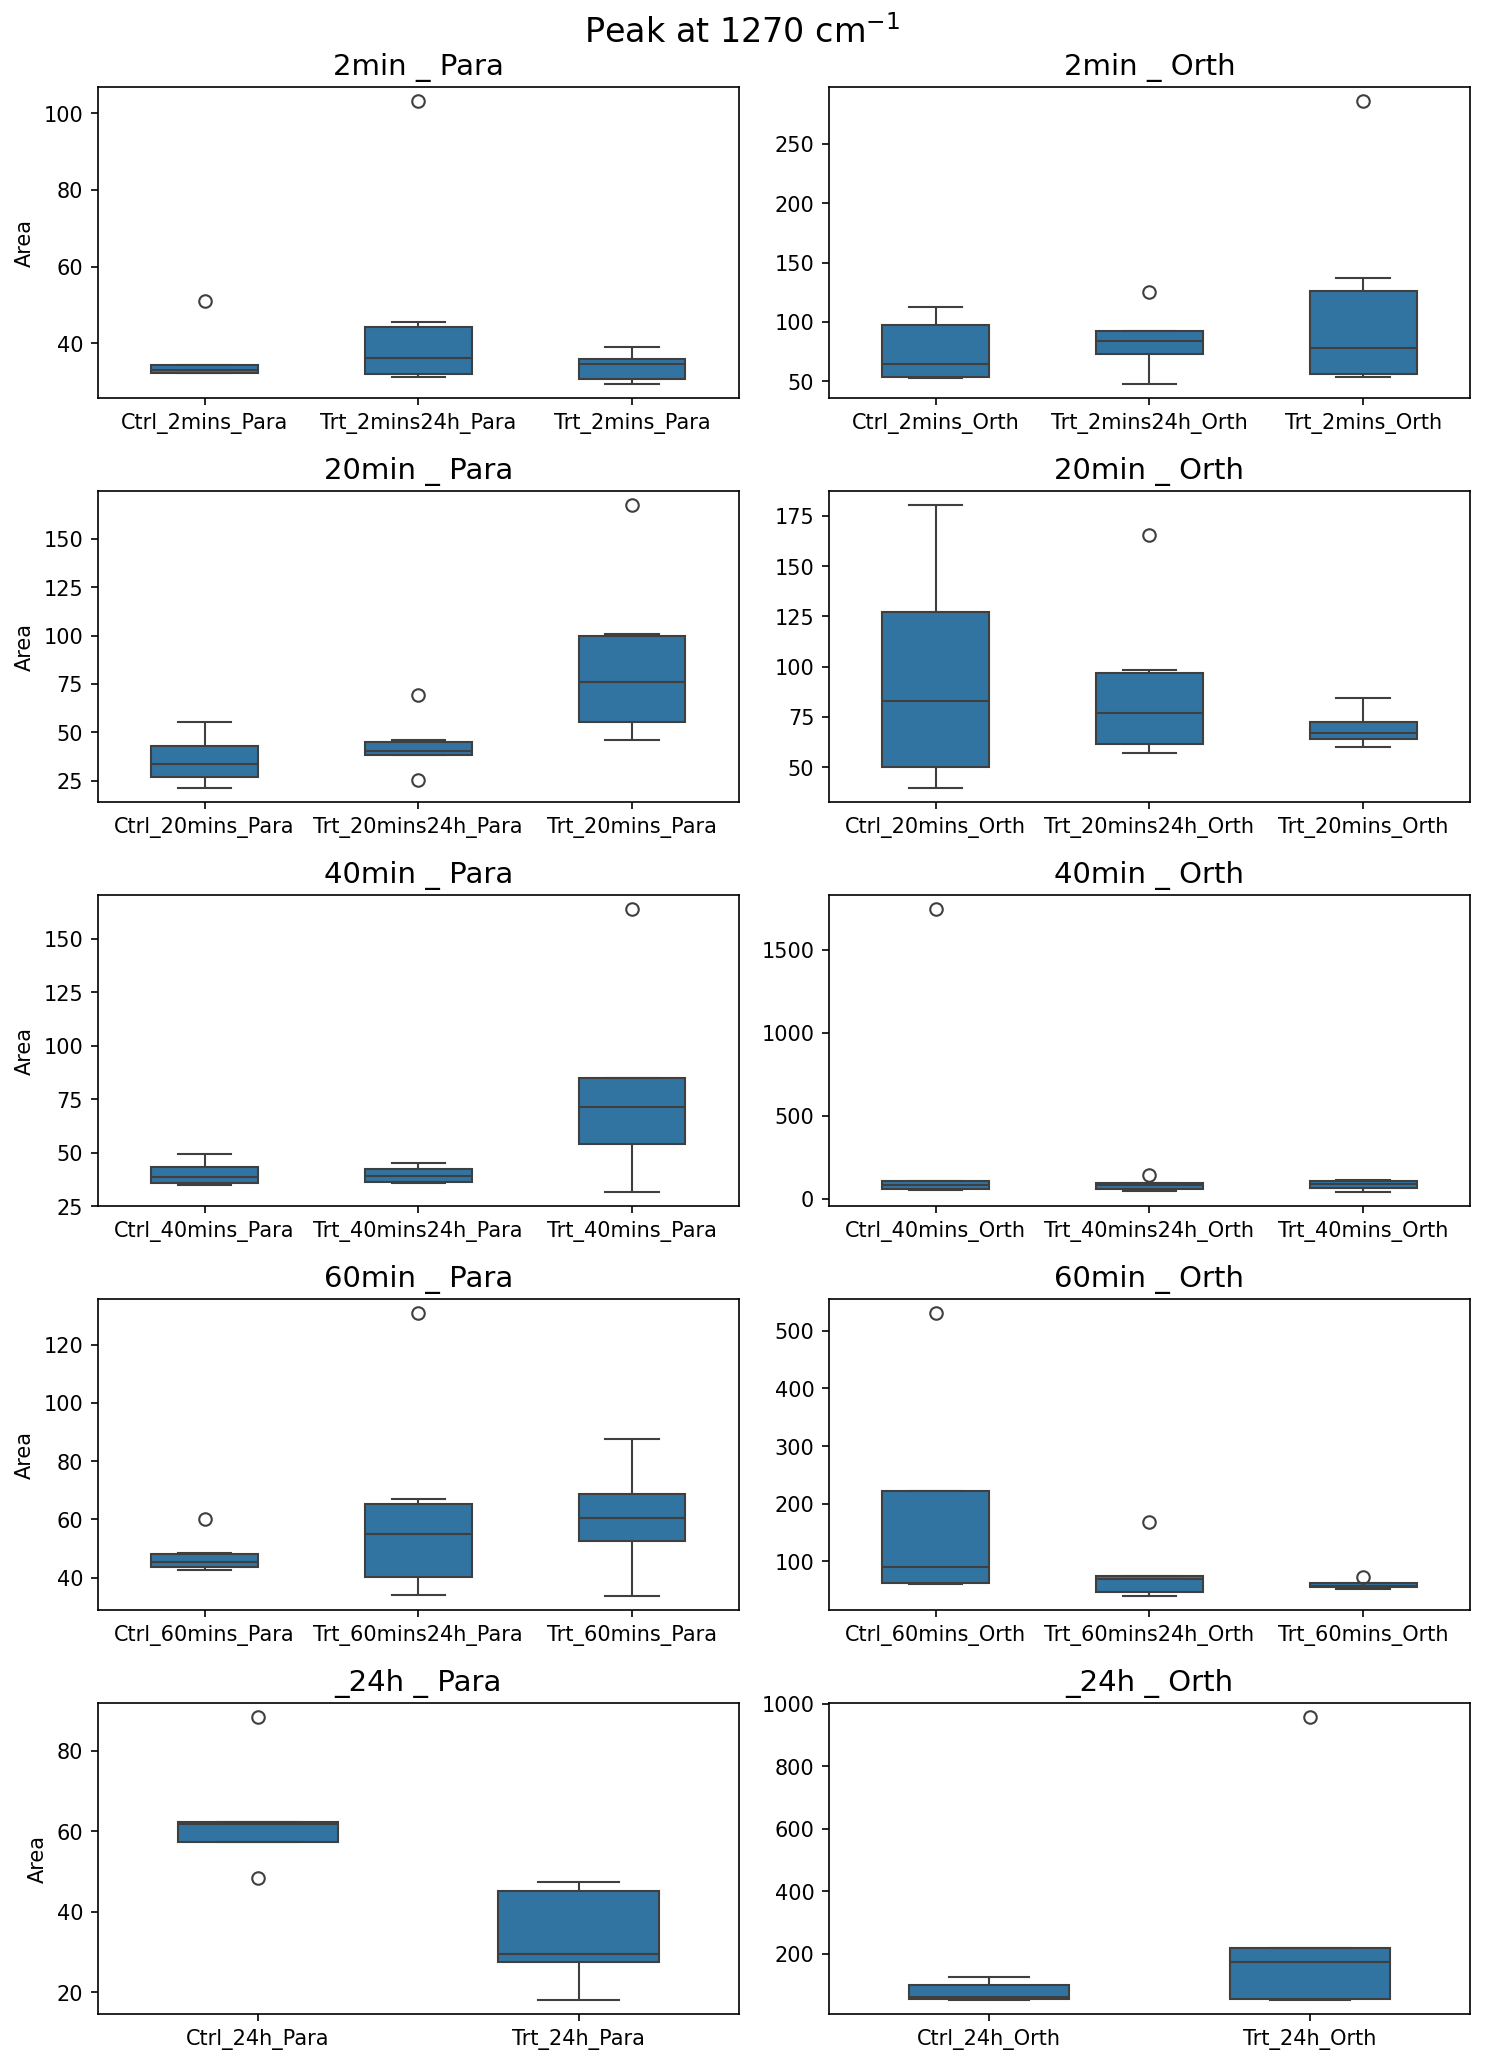

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

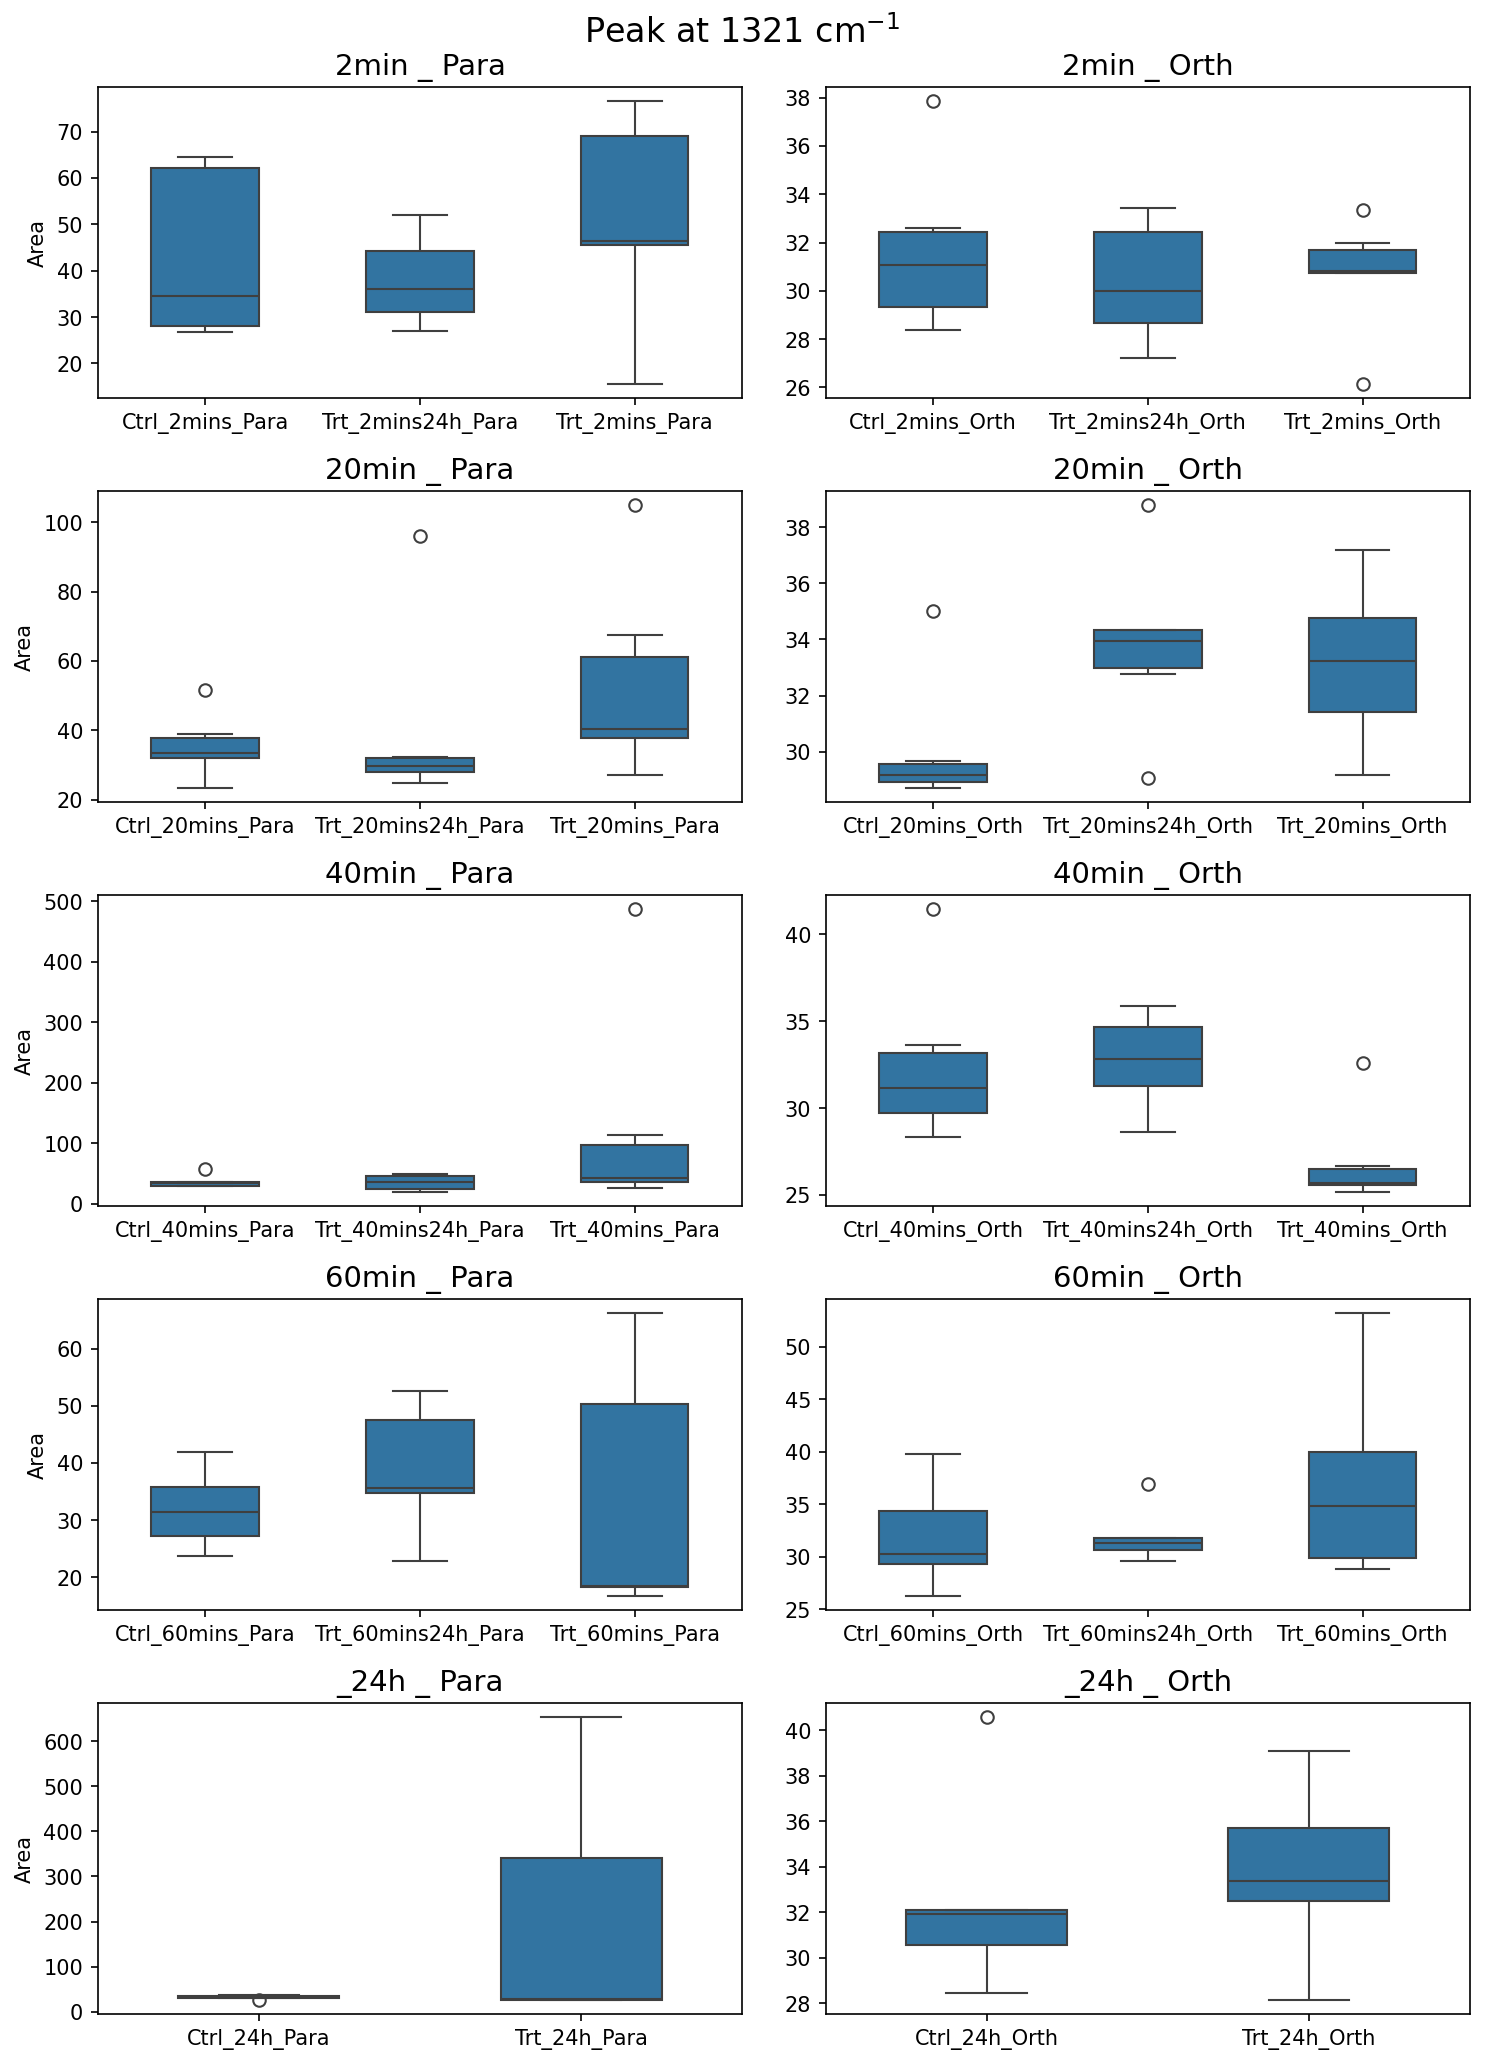

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

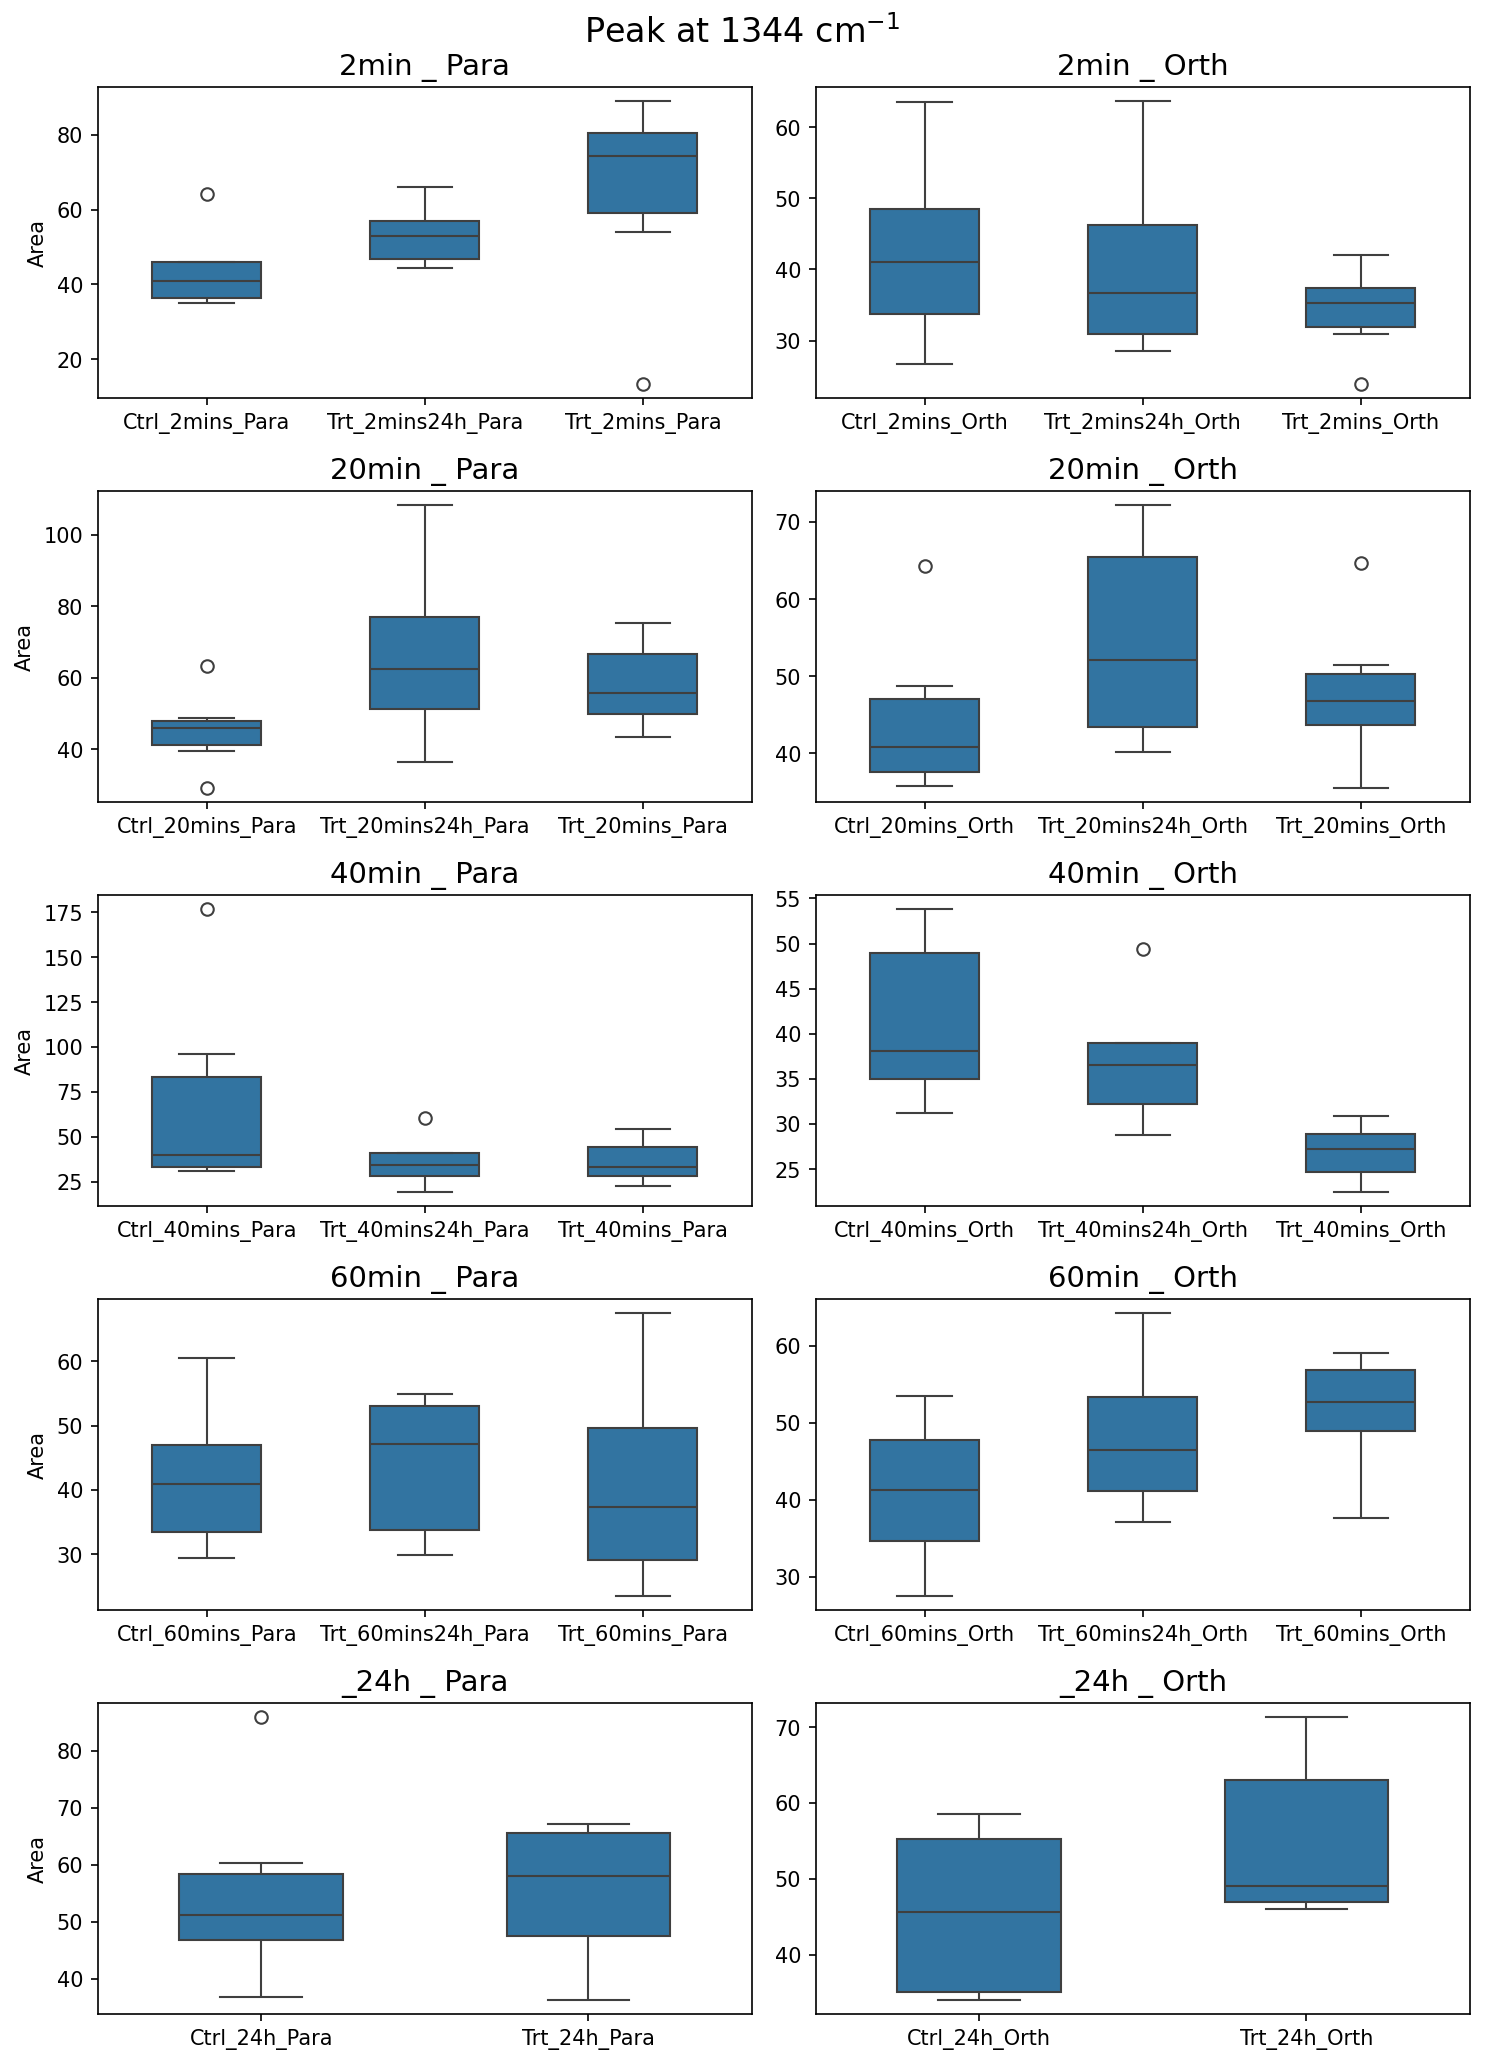

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

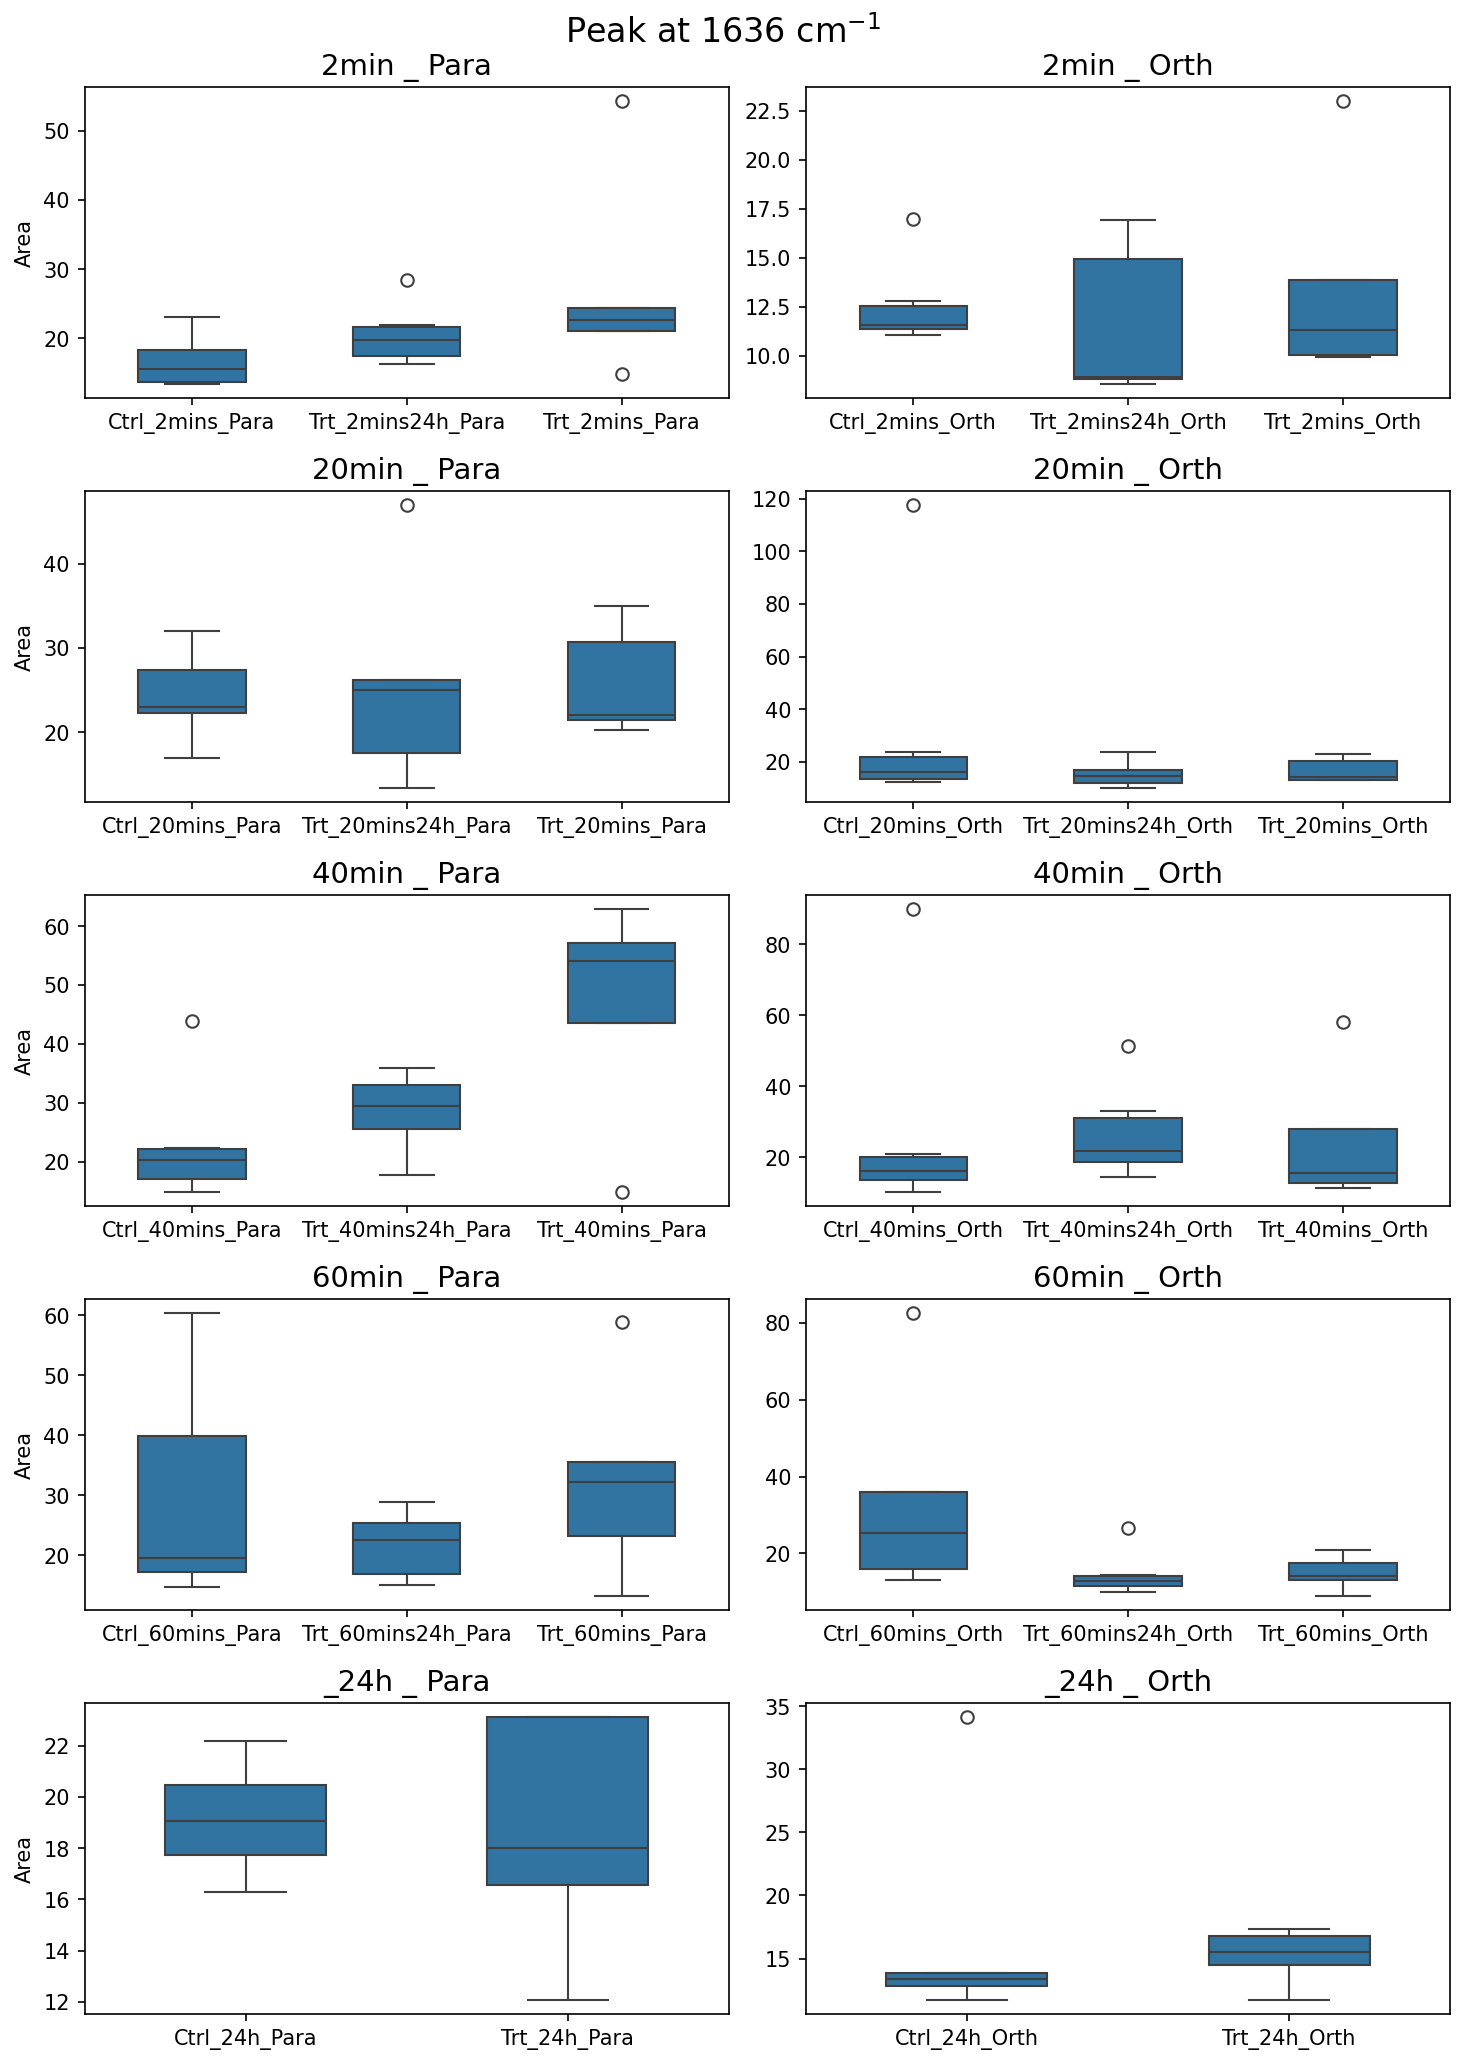

C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
C:\Users\oadeji01\AppData\Local\Temp\ipykernel_27900\2422181490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after s

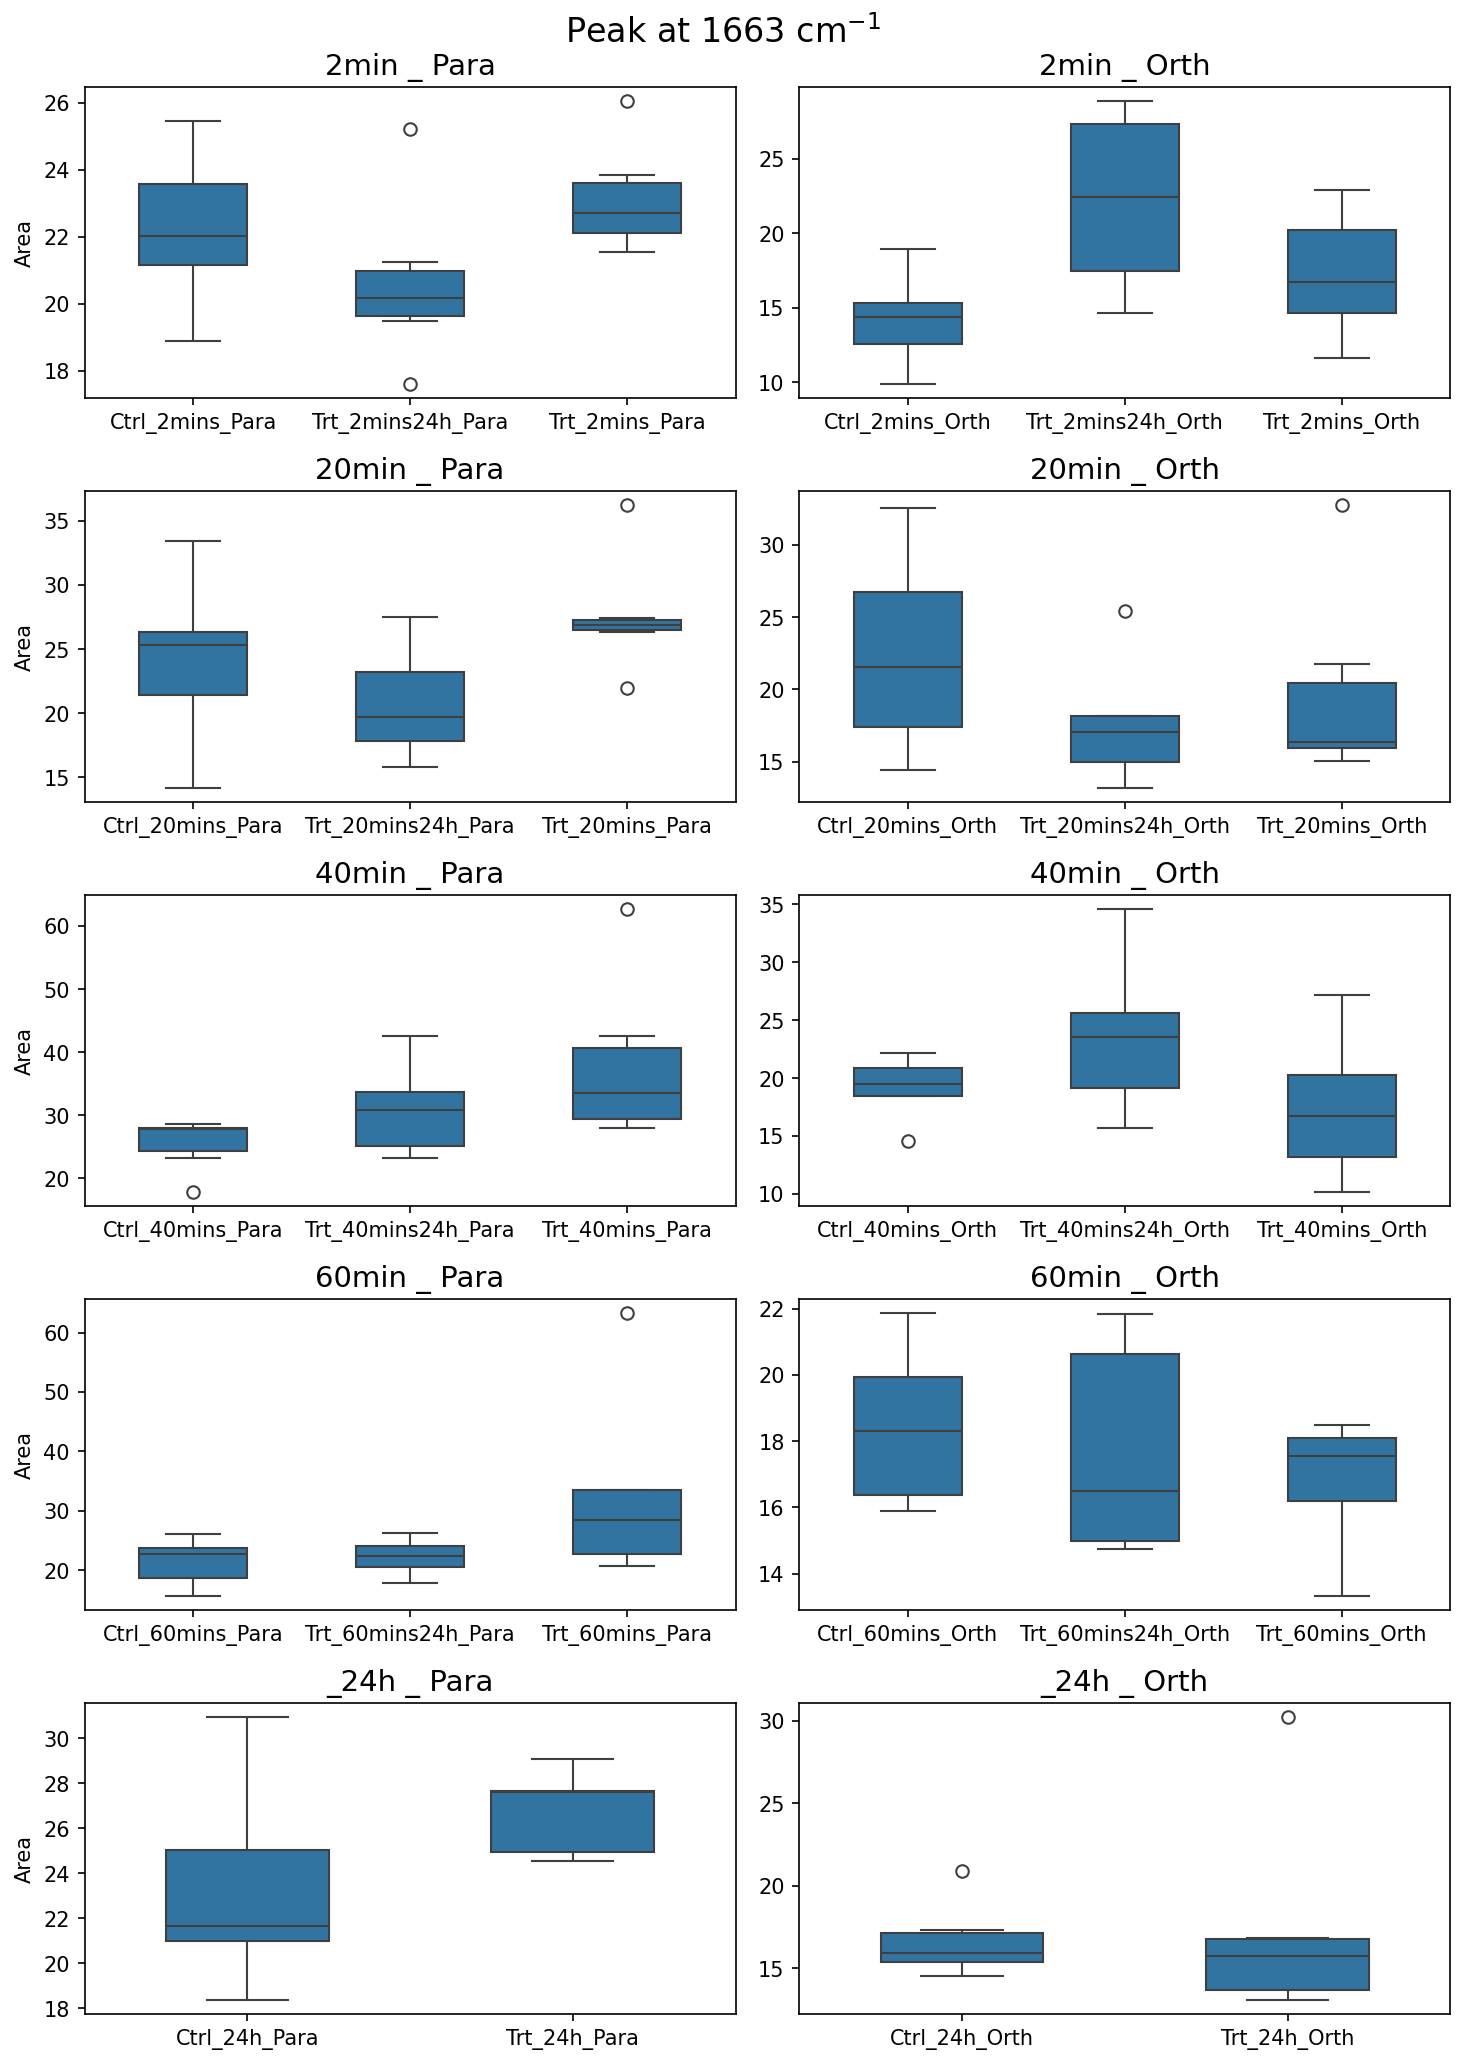

In [ ]:
for p in peak_positions:
    fig, axes = plt.subplots(5, 2, figsize = (10, 14), dpi = 150)
#axes = axes.flatten()


    for i, ort in enumerate(['2min', '20min', '40min', '60min', '_24h']):
        for j, tp in enumerate(['Para', 'Orth']):
            
            ax = axes[i, j]
            subset =  results[
                (results['group'].str.contains(ort)) & 
                (results['group'].str.contains(tp)) & 
                (results['peak_pos'] == p)
                ]
            #print(subset)
            sns.boxplot(
                        data = subset,
                        x = 'group',
                        y = 'area',
                        ax = ax,
                        width = .5
                        );
            ax.set_xticklabels([label.get_text()[9:] for label in ax.get_xticklabels()]);
            ax.set_title(f"{ort} _ {tp}", fontsize=14);
            ax.set_xlabel("");
            ax.set_ylabel("Area" if j == 0 else "");  # only left column shows y-axis label
    plt.suptitle(f"Peak at {p} cm$^{{-1}}$", fontsize = 16);

    plt.tight_layout();
    plt.show();